<a href="https://colab.research.google.com/github/mauricioDallOnder/codigo-futebol/blob/main/MODELO_BRASIL_FINAL_PIKA_DE_CACHORRO_FORTE_TUNADO_oficial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ETAPA 1: Instalação e Importações

In [ ]:
# Instalar bibliotecas necessárias
!pip install pandas numpy matplotlib seaborn scikit-learn requests scipy
!pip install optuna xgboost lightgbm catboost tensorflow
!pip install pyarrow
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.7 MB/s eta 0:00:00


In [ ]:
# ==============================#
# 1. Importações principais
# ==============================#
import os
import gzip
import pickle
import random
import warnings
from io import StringIO
from datetime import datetime, timedelta
from collections import defaultdict
from typing import List, Dict, Tuple, Optional

import math
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import shap
from tqdm.notebook import tqdm
from typing import Any, Dict, Optional, Tuple
# SciPy (funções especiais / stats / optimize) — tenta importar e sinaliza disponibilidade
try:
    from scipy.special import expit, logit, gammaln, iv  # iv = Bessel I (Skellam), gammaln = log-gamma
    from scipy.optimize import minimize
    from scipy.stats import poisson, beta as beta_dist
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False
    # Se necessário, quem usar expit/logit pode importar de scipy ou implementar fallback
    # (aqui não definimos fallbacks automáticos para não mascarar erros)

# Google Colab (se não estiver no Colab, comente esta linha)
from google.colab import drive  # se não estiver no Colab, comente esta linha
import re
# ==============================#
# Machine Learning (scikit-learn + libs)
# ==============================#
from sklearn.base import clone
from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    brier_score_loss,
    classification_report,
    confusion_matrix,
    f1_score,
    log_loss,
    roc_auc_score,
)
from sklearn.model_selection import TimeSeriesSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from sklearn.multiclass import OneVsRestClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, early_stopping
from catboost import CatBoostClassifier
from scipy.optimize import minimize

# ==============================#
# Deep Learning (TensorFlow / Keras — opcional)
# ==============================#
try:
    import tensorflow as tf
    from tensorflow.keras import layers, models, callbacks, regularizers, optimizers
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    from tensorflow.keras.optimizers import Adam

    tf.get_logger().setLevel("ERROR")
    TENSORFLOW_AVAILABLE = True
except Exception:
    print("⚠️ TensorFlow não está disponível. Instale 'tensorflow' para usar a MLP.")
    TENSORFLOW_AVAILABLE = False

# ==============================#
# Configurações gerais
# ==============================#
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
plt.style.use("default")
sns.set_palette("husl")
optuna.logging.set_verbosity(optuna.logging.WARNING)

print("✅ Bibliotecas importadas com sucesso!")

# ==============================#
# Constantes / Flags
# ==============================#
USE_CALIB_ENSEMBLE_PARA_STAKE = True        # Kelly sempre com p calibrada
#SHRINKCLIP_GUARD = False                    # aplicar shrink/clip só se melhorar Brier (e não piorar LogLoss)


✅ Bibliotecas importadas com sucesso!


## ETAPA 2: Configuração do Modo de Operação

In [ ]:
# ==========================================
# 2. CONFIGURAÇÃO PRINCIPAL
# ==========================================

MODO_OPERACAO = "dados_reais"  # "simulacao" ou "dados_reais"
DATA_BUSCA = "2025-10-22"  # None para hoje ou "YYYY-MM-DD"
#LIGAS_INTERESSE = ["ENGLAND 1", "GERMANY 1", "SPAIN 1", "BRAZIL 1"]
LIGAS_INTERESSE = ["BRAZIL 1"]

# OTIMIZAÇÃO 1: Filtro de anos recentes
ANOS_RECENTES = [2022,2023,2024,2025]  # Apenas dados recentes

print(f"🎯 MODO SELECIONADO: {MODO_OPERACAO.upper()}")
print(f"📅 Data para busca: {DATA_BUSCA or 'Hoje'}")
print(f"🏆 Ligas de interesse: {LIGAS_INTERESSE}")
print(f"📊 Anos para treinamento: {ANOS_RECENTES}")


🎯 MODO SELECIONADO: DADOS_REAIS
📅 Data para busca: 2025-10-22
🏆 Ligas de interesse: ['BRAZIL 1']
📊 Anos para treinamento: [2022, 2023, 2024, 2025]


In [ ]:
# ======================================================================
# ETAPA 3 — Configurações Gerais (ajuste conforme o seu painel de controle)
# ======================================================================

USE_CALIB_ENSEMBLE_PARA_STAKE = True   # Kelly deve usar probabilidade calibrada
KELLY_FRAC_GLOBAL = 0.75               # Fracionado Kelly
STAKE_CAP_GLOBAL = 0.05                # Teto % banca
EV_MIN_GLOBAL = 0.03                   # EV mínimo
EDGE_MIN_GLOBAL = 0.02                 # Edge mínimo
ODDS_MIN = 2.01                        # Odds mínimas
ODDS_MAX = 3.20                        # Odds máximas
MIN_STAKE_REAIS = 0.5                  # Stake min real
STAKE_ROUND_TO = 1.0                   # Arredonda para múltiplos de 1.0 (ex: R$1, R$2)
ENFORCE_MIN_STAKE = True               # Force para min se <min
ENT_WEIGHT = 0.1
KELLY_BASE_GLOBAL= 0.8
CONSENSO_STD_GLOBAL = 0.15
# Lower bound Beta para stake (Kelly com incerteza)
LB_N0 = 200                            # "força" do prior (100–400)
LB_ALPHA = 0.10                        # quantil inferior (10%)

# Dixon-Coles (manter só o usado; comente se expandir)
DC_MAX_GOALS = 10                      # limite superior de gols na grade de probabilidade

# Kelly adaptativo (drawdown)
DRAWDOWN_ATUAL = 0.0                   # atualize a cada dia/semana
DD_CAP = 0.30
# Novo: Defaults para cfg_consenso (pesos, agregador)
CFG_CONSENSO_DEFAULT = {
    "pesos": {"Prob_NB": 1.0, "Prob_LGBM": 1.5, "Prob_DC": 0.8},  # Pesos por modelo
    "agregador": "trimmed_mean", "trim": 0.1,
    "max_std": 0.20,  # Relaxado,
    "prob_source": "mean",   # ou consenso ou "final" ou "mean"
    "ev_switch_margin": 0.03     # 3 p.p.: só viro contra o outcome_model se o ganho de EV superar isso
}

# Novo: Defaults para cfg Kelly (para passar em aplicar_kelly_ev)
CFG_KELLY_DEFAULT = {
    "min_ev": EV_MIN_GLOBAL,
    "edge_min": EDGE_MIN_GLOBAL,
    "kelly_frac": KELLY_FRAC_GLOBAL,
    "stake_cap_pct": STAKE_CAP_GLOBAL,
    "odds_min": ODDS_MIN,
    "odds_max": ODDS_MAX,
    "min_stake_reais": MIN_STAKE_REAIS,
    "min_stake_pct_banca": 0.002,  # 0.2% banca min
    "stake_step": STAKE_ROUND_TO,  # Arredonda
    "round_dec": 4,
    "use_lower_bound_beta": True,
    "check_log_growth_after_round": True,
    "lb_n0": 200, "lb_alpha": 0.20,
    "choose_by": "EV",
    "ent_weight": ENT_WEIGHT,
    "kelly_base": KELLY_BASE_GLOBAL,
    "dd_cap": DD_CAP,
    "consenso_std": CONSENSO_STD_GLOBAL,
}

CFG_KELLY_DEFAULT.update({
    # fonte das probabilidades na etapa EV/Kelly
    "prob_source": "consenso",   # 'consenso' | 'final' | 'mean'

    # odds por classe (libera favoritos de casa + empates mais amplos)
    "odds_min_H": 1.30, "odds_max_H": 6.00,
    "odds_min_D": 1.80, "odds_max_D": 7.00,
    "odds_min_A": 1.40, "odds_max_A": 6.00,

    # Kelly e cap por classe (se não setar, usa os globais)
    "kelly_frac": 0.50,
    "kelly_frac_H": 0.50,
    "kelly_frac_D": 0.40,
    "kelly_frac_A": 0.40,
    "stake_cap_pct": 0.05,       # cap global
    # "stake_cap_pct_H": 0.05,   # (opcional por classe)
    # "stake_cap_pct_D": 0.04,
    # "stake_cap_pct_A": 0.04,

    # mínimos
    "min_ev": 0.03,
    "edge_min": 0.02,
    "min_stake_pct_banca": 0.02,   # 2% da banca (ajuste ao seu gosto)
    "stake_step": 1.0,              # se quiser arredondar em reais inteiros

    # anti-empate superalto sob dispersão
    "anti_draw_superhigh": {
        "enabled": True,
        "p_consenso_min": 0.55,   # trava acima de 55% para X
        "pstd_min": 0.18,         # e com std alto (discordância)
        "action": "reject",   # 'block' para vetar; 'extra_ev' p/ exigir EV extra
        "extra_ev": 0.10
    }
})

# pesos/limiares do consenso (ajuste fino depois)
CFG_CONSENSO_DEFAULT = {
    "dc_shrink_thresh_hi": 0.30,
    "dc_shrink_thresh_lo": 0.15,
    "dc_alpha_hi": 0.30,
    "dc_alpha_lo": 0.60,
    "dc_weight_hi": 0.20,
    "dc_weight_lo": 0.50,

    # Novo: robustez/âncora
    "w_anchor": 1.50,           # peso da âncora no blend
    "tukey_c": 1.0,             # corte (em |logit-diff| agregado)
    "max_weight_ratio": 3.0,    # evita 1 modelo dominar
    "consenso_power": 0.90,     # power <1 suaviza extremos (Dirichlet power)
    "cap_lo": 0.06,             # clamp final do consenso
    "cap_hi": 0.85,

    "min_models": 3             # mínimo p/ formar consenso
}

# opcional: confiança por base (0–1). Comece tudo 1.0 e refine com backtest.
TRUST_SCORES_1X2 = {
    "NB": 1.00, "LGBM": 1.00, "MLP": 1.00, "CAT": 1.00, "XGB": 1.00, "DC": 0.80
}


# Buckets e gates (por outcome)
BUCKETS = [(1.20,1.60),(1.60,2.00),(2.00,2.50),(2.50,3.20),(3.20,100.0)]


# Alpha por bucket (blend cal/raw do stack) — default
ALPHA_BUCKETS = {b: 0.75 for b in BUCKETS}

# Gates por outcome (odds liberadas e mínimos de EV/Edge)
GATES_BUCKETS = {
    "H": {b: {"MIN_EV":EV_MIN_GLOBAL, "EDGE_MIN":0.03, "ODD_MIN":2.01, "ODD_MAX":3.20} for b in BUCKETS},  # Relaxado
    "D": {b: {"MIN_EV":EV_MIN_GLOBAL, "EDGE_MIN":0.02, "ODD_MIN":2.80, "ODD_MAX":4.50} for b in BUCKETS},
    "A": {b: {"MIN_EV":EV_MIN_GLOBAL, "EDGE_MIN":0.02, "ODD_MIN":1.70, "ODD_MAX":3.50} for b in BUCKETS},
}

CFG_CONSENSO_DEFAULT = {
    # limites de "outlier" do DC (gap em probabilidade)
    "dc_shrink_thresh_hi": 0.30,   # gap > 0.30  -> encolhe forte
    "dc_shrink_thresh_lo": 0.15,   # 0.15–0.30   -> encolhe médio
    # mistura (alpha) do DC com o âncora; menor = mais ancorado
    "dc_alpha_hi": 0.30,           # gap alto
    "dc_alpha_lo": 0.60,           # gap médio
    # pesos do DC no consenso quando outlier
    "dc_weight_hi": 0.20,          # gap alto
    "dc_weight_lo": 0.50,          # gap médio
}

CFG_PRIORS = {
  "gamma_prior": { "use": True, "shape": 2.5, "rate": 50.0, "weight": 0.25 },  # média ~0.05
  "t_weight": 1.0,   # força do Student-t
  "t_nu": 3.0,       # cauda pesada moderada
  "t_scale": 0.4,    # escala dos efeitos (ajuste fino por liga)
}


def tighten_gates(GATES_BUCKETS, bucket, cls, *, min_ev=None, edge_min=None):
    if (cls in GATES_BUCKETS) and (bucket in GATES_BUCKETS[cls]):
        if min_ev is not None:
            GATES_BUCKETS[cls][bucket]["MIN_EV"] = max(GATES_BUCKETS[cls][bucket]["MIN_EV"], min_ev)
        if edge_min is not None:
            GATES_BUCKETS[cls][bucket]["EDGE_MIN"] = max(GATES_BUCKETS[cls][bucket]["EDGE_MIN"], edge_min)
    else:
        print(f"⚠️ Gate não encontrado para {cls}/{bucket} — usando default.")

# Exemplos de tighten (ajuste ou remova se relaxar for suficiente)
tighten_gates(GATES_BUCKETS, (1.60, 2.00), "H", min_ev=EV_MIN_GLOBAL, edge_min=0.02)
tighten_gates(GATES_BUCKETS, (3.20, 100.0), "A", edge_min=0.02)


def usar_thresholds_globais():
    """
    Exporta para o escopo global nomes que outras células costumam usar
    (MIN_EV, EDGE_MIN, KELLY_FRAC, STAKE_CAP, ODDS_COL_EVENT1).
    Assim, basta referenciar estes nomes nas células de ROI/ETAPA 10.
    """
    g = globals()
    g["MIN_EV"]        = EV_MIN_GLOBAL
    g["EDGE_MIN"]      = EDGE_MIN_GLOBAL
    g["KELLY_FRAC"]    = KELLY_FRAC_GLOBAL
    g["STAKE_CAP"]     = STAKE_CAP_GLOBAL
    g["MIN_STAKE_REAIS"]= MIN_STAKE_REAIS
    g["STAKE_ROUND_TO"]= STAKE_ROUND_TO
    g["ENFORCE_MIN_STAKE"]= ENFORCE_MIN_STAKE
    g["DC_MAX_GOALS"]= DC_MAX_GOALS
    g["ENT_WEIGHT"]= ENT_WEIGHT
    g["KELLY_BASE_GLOBAL"]= KELLY_BASE_GLOBAL
    g["ODDS_MIN"]= ODDS_MIN
    g["ODDS_MAX"]= ODDS_MAX
    g["CONSENSO_STD_GLOBAL"]= CONSENSO_STD_GLOBAL
    print(
        f"✅ Thresholds travados | EV_min={EV_MIN_GLOBAL:.0%} | edge_min={EDGE_MIN_GLOBAL:.0%} | "
        f"Kelly={KELLY_FRAC_GLOBAL:.0%} | Cap={STAKE_CAP_GLOBAL:.0%}"  # Remova odds_col
    )

usar_thresholds_globais()

✅ Thresholds travados | EV_min=3% | edge_min=2% | Kelly=75% | Cap=5%


In [ ]:


# ---------- helpers ----------
def brier_multiclass(y_true: np.ndarray, P: np.ndarray) -> float:
    y_true = np.asarray(y_true, int)
    P = np.asarray(P, float)
    K = P.shape[1]
    Y = np.eye(K, dtype=float)[y_true]
    return float(np.mean(np.sum((Y - P)**2, axis=1)))


def _logit_clip(p, eps=1e-9):
    p = np.clip(p, eps, 1-eps)
    return np.log(p) - np.log1p(-p)

def _dirichlet_power(P, alpha):
    Pp = np.power(np.clip(P, 1e-9, 1-1e-9), float(alpha))
    return Pp / Pp.sum(axis=-1, keepdims=True)


def devig_3way(o1: float, oX: float, o2: float,
               clip: Tuple[float,float]=(1e-6, 1-1e-6)) -> Tuple[float,float,float]:
    """Fair probs 1X2 removendo vig por normalização 1/odd; valida entradas."""
    o1, oX, o2 = map(float, (o1, oX, o2))
    if np.any(np.array([o1, oX, o2]) <= 1) or not np.all(np.isfinite([o1,oX,o2])):
        return (1/3, 1/3, 1/3)
    ip = np.array([1/o1, 1/oX, 1/o2], dtype=float)
    s = ip.sum()
    if s <= 0 or not np.isfinite(s):
        return (1/3, 1/3, 1/3)
    p = np.clip(ip / s, *clip)
    p /= p.sum()
    return float(p[0]), float(p[1]), float(p[2])

def _tukey_weight(d, c=0.30):
    """
    Retorna peso robusto de Tukey para discrepância d com cutoff c.
    Aceita escalar ou array. Sempre clipe dentro de [0,1].
    """
    c = float(c) if c is not None else 1.0
    c = max(c, 1e-9)

    r = np.asarray(d, dtype=float) / c
    # trata NaN/Inf como 'muito longe' => peso 0
    r = np.where(np.isfinite(r), r, np.inf)

    w = (1.0 - r**2)**2
    w = np.where(r >= 1.0, 0.0, w)
    w = np.clip(w, 0.0, 1.0)

    # se a entrada era escalar, devolve float; se era vetor, devolve array
    return float(w) if w.ndim == 0 else w


def _ensure_keys_for_selection(df: pd.DataFrame) -> pd.DataFrame:
    """
    Garante colunas 'jogo' e 'outcome_model' para etapas de seleção/EV/Kelly.
    - 'jogo' = "Home vs Away"
    - 'outcome_model' = argmax das melhores probs disponíveis (P_* ou p_consenso_*)
    """
    df = df.copy()

    # jogo
    if "jogo" not in df.columns and {"Home","Away"} <= set(df.columns):
        df["jogo"] = df["Home"].astype(str) + " vs " + df["Away"].astype(str)

    if "outcome_model" not in melhores.columns:
        melhores = melhores.merge(base_model, on="jogo", how="left")
    # outcome_model
    if "outcome_model" not in df.columns:
        tags = np.array(["H","D","A"])
        base = None
        if all(c in df.columns for c in ("P_H","P_D","P_A")):
            base = df[["P_H","P_D","P_A"]].to_numpy()
        elif all(c in df.columns for c in ("p_consenso_H","p_consenso_D","p_consenso_A")):
            base = df[["p_consenso_H","p_consenso_D","p_consenso_A"]].to_numpy()
        # fallback uniforme se nada existir ainda
        if base is None:
            base = np.full((len(df), 3), 1/3.0)
        df["outcome_model"] = tags[np.argmax(base, axis=1)]

    return df


def _ensure_xg_implied(df: pd.DataFrame) -> pd.DataFrame:
    if all(c in df.columns for c in ("Home_xG_Implied","Away_xG_Implied")):
        return df
    ou_aliases = {
        'Odd_Over25': 'Odd_Over25_FT',
        'Odd_Under25': 'Odd_Under25_FT',
        'Odd_Over_FT': 'Odd_Over25_FT',
        'Odd_Under_FT': 'Odd_Under25_FT',
        'Over25': 'Odd_Over25_FT',
        'Under25': 'Odd_Under25_FT'
    }
    tmp = df.copy()
    for velho, novo in ou_aliases.items():
        if velho in tmp.columns and novo not in tmp.columns:
            tmp = tmp.rename(columns={velho: novo})
    try:
        if 'calcular_xg_implicito_v2' in globals():
            tmp = calcular_xg_implicito_v2(tmp, 2.5,
                   ('Odd_H_FT','Odd_D_FT','Odd_A_FT','Odd_Over25_FT','Odd_Under25_FT'))
    except Exception:
        for c in ('Home_xG_Implied','Away_xG_Implied'):
            if c not in tmp.columns:
                tmp[c] = 0.0
    return tmp

def _bootstrap_skill_ci(y, P_model, P_market, *, LL_uniform, n_boot=5000, seed=42):
    """Retorna médias e IC95% (percentil) para LL_gain, LL_skill, BSS."""
    rng = np.random.default_rng(seed)
    y = np.asarray(y, int)
    P_model = np.asarray(P_model, float)
    P_market = np.asarray(P_market, float)
    n = len(y); idx = np.arange(n)
    K = P_model.shape[1]
    def ci(a):
        a = np.asarray(a, float)
        lo, hi = np.percentile(a, [2.5, 97.5])
        return float(np.mean(a)), float(lo), float(hi)
    gains_LL, skills_LL, skills_Brier = [], [], []
    for _ in range(n_boot):
        s = rng.choice(idx, size=n, replace=True)
        yh, Pm, Pk = y[s], P_model[s], P_market[s]
        ll_m = log_loss(yh, Pm, labels=list(range(K)))
        ll_k = log_loss(yh, Pk, labels=list(range(K)))
        br_m = brier_multiclass(yh, Pm)
        br_k = brier_multiclass(yh, Pk)
        gains_LL.append(ll_m - ll_k)
        skills_LL.append(1 - ll_m/LL_uniform)
        skills_Brier.append(1 - br_m/br_k)
    return {
        "LL_gain": ci(gains_LL),
        "LL_skill": ci(skills_LL),
        "BSS": ci(skills_Brier)
    }

def implied_novig_from_odds_bin(odd: float) -> float:
    """Implied prob no-vig (binário) ≈ 1/odd (não há vig intra-linha)."""
    if odd <= 1 or not np.isfinite(odd):
        return 0.5
    p = 1.0 / odd
    return float(np.clip(p, 1e-6, 1-1e-6))


def _weighted_std_row(values: np.ndarray, weights: np.ndarray) -> float:
    """Desvio-padrão ponderado (populacional) de um vetor 1D."""
    m = np.average(values, weights=weights)
    var = np.average((values - m)**2, weights=weights)
    return float(np.sqrt(var))


# ===================== consenso robusto (sem classes) =====================

def _robust_aggregate(vals: np.ndarray, weights: Optional[np.ndarray],
                      modo: str = "trimmed_mean", trim: float = 0.1) -> float:
    x = np.asarray(vals, float)
    if weights is None:
        w = np.ones_like(x)
    else:
        w = np.asarray(weights, float)
        w = np.clip(w, 1e-8, None)
    if modo == "trimmed_mean":
        idx = np.argsort(x)
        n = len(x); k = int(np.floor(trim * n))
        sl = idx[k:n-k] if n - 2*k >= 1 else idx
        return float(np.average(x[sl], weights=w[sl]))
    # Tukey biweight simples
    med = np.median(x); s = 1.4826 * np.median(np.abs(x - med)) + 1e-12
    u = (x - med) / (6*s)
    w_b = (1 - u**2)**2
    w_b[np.abs(u) >= 1] = 0
    return float(np.average(x, weights=w * np.clip(w_b, 0, None)))

def aplicar_filtro_consenso(df_pred: pd.DataFrame,
                            cfg: Optional[Dict] = None) -> pd.DataFrame:
    """
    Gera p_consenso robusto, mantendo seus indicadores de qualidade/decisões.
    cfg (dict) – chaves (com defaults):
      cols_modelos=("Prob_NB","Prob_LGBM","Prob_DC"), max_std=0.12,
      ignorar_dc_quando_plano=True, tol_plano=0.02, fallback_dual=True,
      max_std_dual=0.16, winsor_lo=0.05, winsor_hi=0.95,
      drop_um_outlier=True, max_dev_abs=0.25,
      pesos=None (dict por modelo), agregador="trimmed_mean", trim=0.1
    """
    d = {
        "cols_modelos": ("Prob_NB","Prob_LGBM","Prob_DC"),
        "max_std": 0.12,
        "ignorar_dc_quando_plano": True,
        "tol_plano": 0.02,
        "fallback_dual": True,
        "max_std_dual": 0.16,
        "winsor_lo": 0.05,
        "winsor_hi": 0.95,
        "drop_um_outlier": True,
        "max_dev_abs": 0.25,
        "pesos": None,
        "agregador": "trimmed_mean",
        "trim": 0.1,
    }
    if cfg: d.update(cfg)

    def _winsor(p): return float(np.clip(p, d["winsor_lo"], d["winsor_hi"]))
    pesos = d["pesos"] or {}

    out = []
    for _, r in df_pred.iterrows():
        ps = {c: _winsor(float(r[c])) for c in d["cols_modelos"] if c in r and pd.notna(r[c])}
        usado = list(ps.keys()); motivo = []

        # ignora DC ~0.5
        if d["ignorar_dc_quando_plano"] and "Prob_DC" in usado:
            if abs(ps["Prob_DC"] - 0.5) <= d["tol_plano"]:
                usado.remove("Prob_DC"); motivo.append("drop_DC_plano")

        vals = np.array([ps[c] for c in usado], float)
        p_std = float(np.std(vals)) if len(vals) > 1 else 0.0
        consenso_ok = (p_std <= d["max_std"])
        base = "3way" if len(usado) == 3 else ("dual" if len(usado) == 2 else "solo")
        outlier = None

        if (not consenso_ok) and d["drop_um_outlier"] and len(usado) >= 3:
            med = float(np.median(vals))
            diffs = {c: abs(ps[c] - med) for c in usado}
            outlier = max(diffs, key=diffs.get)
            if diffs[outlier] >= d["max_dev_abs"]:
                usado2 = [c for c in usado if c != outlier]
                vals2 = np.array([ps[c] for c in usado2], float)
                if (len(vals2) > 1) and (np.std(vals2) <= d["max_std"]):
                    usado, vals = usado2, vals2
                    consenso_ok = True
                    base += "+drop1"
                    motivo.append(f"drop_outlier={outlier}")

        if (not consenso_ok) and d["fallback_dual"] and len(usado) == 3:
            med = float(np.median(vals))
            diffs = {c: abs(ps[c] - med) for c in usado}
            drop = "Prob_DC" if ("Prob_DC" in usado and abs(ps["Prob_DC"]-0.5) <= d["tol_plano"]) else max(diffs, key=diffs.get)
            cand = [c for c in usado if c != drop]
            vals2 = np.array([ps[c] for c in cand], float)
            if (len(vals2) > 1) and (np.std(vals2) <= d["max_std_dual"]):
                usado, vals = cand, vals2
                consenso_ok = True
                base = "dual_fallback"
                motivo.append(f"fallback_drop={drop}")

        w = np.array([pesos.get(c, 1.0) for c in usado], float)
        p_consenso = _robust_aggregate(vals, w, d["agregador"], d["trim"]) if len(usado) else np.nan

        out.append({
            **r.to_dict(),
            "p_consenso": float(np.clip(p_consenso, 1e-6, 1-1e-6)) if np.isfinite(p_consenso) else np.nan,
            "p_std": p_std,
            "n_modelos_consenso": len(usado),
            "modelos_usados": ",".join(usado),
            "consenso_ok": bool(consenso_ok),
            "consenso_base": base,
            "outlier_drop": outlier if base.endswith("+drop1") else None,
            "motivo": "|".join(motivo) if motivo else None
        })
    return pd.DataFrame(out).reset_index(drop=True)


# =========================
# 1) KELLY ADAPTATIVO (VETORIZADO)
# =========================
def kelly_adaptativo(p,
                     odd,
                     kelly_base=0.50,                  # pode ser escalar OU array por-linha
                     drawdown: float = 0.0,
                     dd_cap: float = 0.30,
                     entropy01=0.0,                    # pode ser escalar OU array [0..1]
                     ent_weight: float = 0.0,
                     use_lower_bound: bool = True,
                     lb_kind: str = "beta",            # "beta" ou "wilson"
                     lb_n0: int = 200,
                     lb_alpha: float = 0.20,
                     lb_n_wilson: int = 200,
                     min_floor: float = 0.0,
                     max_fraction: float = 0.20):
    """
    Versão robusta/vetorizada: aceita escalar ou array para p, odd, entropy01 e kelly_base.
    Retorna fração final a apostar (já aplicada base, entropia, drawdown e piso/teto).
    """
    import numpy as np

    p_arr   = np.asarray(p,   dtype=float)
    odd_arr = np.asarray(odd, dtype=float)
    kb_arr  = np.asarray(kelly_base, dtype=float)  # permite base por-linha
    ent_arr = np.asarray(entropy01, dtype=float)

    # sanitização
    p_arr   = np.clip(p_arr, 1e-8, 1-1e-8)
    b_arr   = np.clip(odd_arr - 1.0, 1e-12, None)     # b>0

    # lower bound opcional
    if use_lower_bound:
        if lb_kind.lower().startswith("wil"):
            # Wilson (aprox)
            z = 1.2815515655446004 if abs(lb_alpha-0.20) < 1e-9 else 1.6448536269514722
            n = float(lb_n_wilson)
            phat = p_arr
            denom = 1.0 + (z**2)/n
            center = phat + (z**2)/(2*n)
            rad = z * np.sqrt((phat*(1.0 - phat) + (z**2)/(4*n))/n)
            p_eff = np.clip((center - rad)/denom, 1e-8, 1-1e-8)
        else:
            # "beta": se tiver tua função exata, use-a aqui; fallback conservador
            # p_eff = p_lower_bound_beta(p_arr, n0=lb_n0, alpha=lb_alpha)
            n0 = float(lb_n0)
            alpha = float(lb_alpha)
            p_eff = np.clip(p_arr - alpha*np.sqrt((p_arr*(1-p_arr))/max(n0,1.0)), 1e-8, 1-1e-8)
    else:
        p_eff = p_arr

    # Kelly "pleno"
    k_full = (b_arr * p_eff - (1.0 - p_eff)) / b_arr
    k_full = np.maximum(k_full, 0.0)  # sem short

    # penalizações
    if ent_weight > 0.0:
        k_full = k_full * (1.0 - np.clip(ent_arr, 0.0, 1.0) * float(ent_weight))

    if drawdown > 0.0 and dd_cap > 0.0:
        fac_dd = 1.0 - min(max(drawdown, 0.0), dd_cap) / dd_cap
        fac_dd = max(fac_dd, 0.0)
        k_full = k_full * fac_dd

    # aplica base e tetos/pisos
    frac = k_full * kb_arr
    frac = np.clip(frac, float(min_floor), float(max_fraction))
    return frac


# ===================== EV + seleção (binário) =====================


'''
def ev_floor_for_odd(cls: str, odd: float) -> float:
    # simples e prático (trata "X" e "D" como empate)
    if cls == "H":         # mandante
        if odd <= 1.60: return 0.03
        if odd <= 2.00: return 0.04
        return 0.05
    if cls in ("D", "X"):  # empate
        return 0.03
    if cls == "A":         # visitante
        if odd <= 2.50: return 0.04
        return 0.05
    return 0.03
'''
#teste com função 4% de lucro:
def ev_floor_for_odd(cls: str, odd: float) -> float:
    # pisos calibrados p/ período 29/07–04/10
    if cls == "H":
        if odd <= 1.60: return 0.07570588210598939   # H_low
        if odd <= 2.00: return 0.07330171675553478   # H_mid
        return 0.06988810874489603                   # H_high
    if cls == "D":  # empate (X)
        return 0.15500401978172947                   # D_all
    if cls == "A":
        if odd <= 2.50: return 0.15627728849393506   # A_low
        return 0.24514815403969075                   # A_high
    return 0.03


def aplicar_kelly_ev(
    dataframe_prob_odds: pd.DataFrame,
    *,
    coluna_probabilidade: str,
    coluna_odds: str,
    banca_inicial: float,
    configuracao: Optional[Dict[str, Any]] = None,
) -> pd.DataFrame:
    """
    Seleção de apostas para um cenário BINÁRIO (uma probabilidade e uma odd por linha),
    aplicando EV + Kelly adaptativo, arredondamento e verificação de log-growth.

    Parâmetros
    ----------
    dataframe_prob_odds : pd.DataFrame
        DataFrame com ao menos as colunas `coluna_probabilidade` e `coluna_odds`.
        Se tiver 'Home' e 'Away', a função cria a coluna 'jogo' = "Home vs Away".
    coluna_probabilidade : str
        Nome da coluna com a probabilidade do evento (entre 0 e 1).
    coluna_odds : str
        Nome da coluna com a odd decimal do evento (>= 1.01).
    banca_inicial : float
        Valor atual da banca em reais (ou unidade monetária).
    configuracao : dict, opcional
        Dicionário com parâmetros de decisão. Defaults abaixo.

    Retorno
    -------
    pd.DataFrame
        DataFrame com colunas de auditoria e decisão:
        ['jogo'(opcional), 'probabilidade', 'odd', 'probabilidade_mercado', 'edge_mercado',
         'EV', 'kelly_pleno', 'fracao_final_kelly', 'valor_sugerido',
         'valor_apostar', 'valor_apostar_formatado', 'percentual_banca', 'apostar?']
    """
    parametros = {
        # Filtros e pisos
        "valor_minimo_ev": 0.02,
        "edge_minimo": 0.01,
        "odd_minima": 1.20,
        "odd_maxima": 20.00,
        # Kelly e limites
        "kelly_base": 0.60,
        "peso_entropia": 0.00,        # não usado no binário por padrão
        "limite_drawdown": 0.30,
        "fracao_kelly_maxima": 0.20,  # teto teórico de Kelly
        "teto_fracao_aposta": 0.05,   # teto operacional por aposta (% da banca)
        # Lower bound (conservador)
        "usar_lower_bound": True,
        "tipo_lower_bound": "wilson",  # "wilson" ou "beta"
        "lb_n0_beta": 200,
        "lb_alpha_beta": 0.20,
        "lb_n_wilson": 200,
        # Arredondamento e mínimos
        "passo_aposta": 0.0,              # ex.: 1.0 para arredondar em reais
        "decimais": 4,
        "valor_minimo_reais": 0.0,
        "percentual_minimo_banca": 0.002, # 0,2% da banca
        # Critério de escolha
        "verificar_log_growth_apos_arredondar": True,
    }
    if configuracao:
        parametros.update(configuracao)

    dataframe_trabalho = dataframe_prob_odds.copy()

    # Coluna 'jogo' (opcional, se existir Home/Away)
    if "jogo" not in dataframe_trabalho.columns and {"Home", "Away"} <= set(dataframe_trabalho.columns):
        dataframe_trabalho["jogo"] = dataframe_trabalho["Home"].astype(str) + " vs " + dataframe_trabalho["Away"].astype(str)

    # Sanitização das entradas
    probabilidades = dataframe_trabalho[coluna_probabilidade].astype(float).clip(1e-8, 1-1e-8).to_numpy()
    odds = dataframe_trabalho[coluna_odds].astype(float).clip(1.01, None).to_numpy()
    retorno_b = odds - 1.0

    # Probabilidade "fair" de mercado (binária: aprox 1/odd)
    probabilidade_mercado = np.array([implied_novig_from_odds_bin(o) for o in odds], dtype=float)

    # Lower bound opcional (conservador)
    if parametros["usar_lower_bound"]:
        if str(parametros["tipo_lower_bound"]).lower().startswith("wil"):
            z = 1.2815515655446004 if abs(parametros["lb_alpha_beta"] - 0.20) < 1e-9 else 1.6448536269514722
            n = float(parametros["lb_n_wilson"])
            p_hat = probabilidades
            denominador = 1.0 + (z**2) / n
            centro = p_hat + (z**2) / (2 * n)
            raio = z * np.sqrt((p_hat * (1.0 - p_hat) + (z**2) / (4 * n)) / n)
            prob_efetiva = np.clip((centro - raio) / denominador, 1e-8, 1 - 1e-8)
        else:
            n0 = float(parametros["lb_n0_beta"])
            alpha = float(parametros["lb_alpha_beta"])
            prob_efetiva = np.clip(probabilidades - alpha * np.sqrt((probabilidades * (1 - probabilidades)) / max(n0, 1.0)),
                                   1e-8, 1 - 1e-8)
    else:
        prob_efetiva = probabilidades

    # Kelly "pleno" (sem short)
    kelly_pleno = (retorno_b * prob_efetiva - (1.0 - prob_efetiva)) / np.where(retorno_b == 0.0, np.nan, retorno_b)
    kelly_pleno = np.maximum(kelly_pleno, 0.0)

    # Kelly adaptativo (com base e drawdown; entropia não usada no binário por padrão)
    fracao_final_kelly = kelly_adaptativo(
        p=prob_efetiva,
        odd=odds,
        kelly_base=float(parametros["kelly_base"]),
        drawdown=float(globals().get("DRAWDOWN_ATUAL", 0.0)),
        dd_cap=float(parametros["limite_drawdown"]),
        entropy01=0.0,
        ent_weight=float(parametros["peso_entropia"]),
        use_lower_bound=False,  # já aplicamos lower bound em prob_efetiva acima
        lb_kind="beta",
        lb_n0=int(parametros["lb_n0_beta"]),
        lb_alpha=float(parametros["lb_alpha_beta"]),
        min_floor=0.0,
        max_fraction=float(parametros["fracao_kelly_maxima"]),
    )
    # Teto operacional por aposta
    fracao_final_kelly = np.minimum(fracao_final_kelly, float(parametros["teto_fracao_aposta"]))

    # EV e edge
    valor_esperado = probabilidades * odds - 1.0
    vantagem_mercado = probabilidades - probabilidade_mercado

    # Filtros básicos
    mascara_valor = (
        (valor_esperado >= float(parametros["valor_minimo_ev"])) &
        (vantagem_mercado >= float(parametros["edge_minimo"])) &
        (odds >= float(parametros["odd_minima"])) &
        (odds <= float(parametros["odd_maxima"]))
    )

    # Valor sugerido e arredondamento
    valor_sugerido = fracao_final_kelly * float(banca_inicial)
    valor_sugerido_arred = valor_sugerido.copy()
    if parametros["passo_aposta"] and parametros["passo_aposta"] > 0.0:
        valor_sugerido_arred = np.floor(valor_sugerido_arred / parametros["passo_aposta"]) * parametros["passo_aposta"]

    # Verificação (opcional) de log-growth pós-arredondamento
    mascara_temp = mascara_valor & (valor_sugerido_arred > 0)
    if parametros["verificar_log_growth_apos_arredondar"] and mascara_temp.any():
        b_tmp = retorno_b[mascara_temp]
        p_tmp = probabilidades[mascara_temp]
        stake_continuo = valor_sugerido[mascara_temp]
        stake_arredondado = valor_sugerido_arred[mascara_temp]
        banca_calc = float(banca_inicial) if float(banca_inicial) > 1e-6 else 100.0

        crescimento_continuo = p_tmp * np.log1p(b_tmp * (stake_continuo / banca_calc)) + (1 - p_tmp) * np.log1p(-(stake_continuo / banca_calc))
        crescimento_arredondado = p_tmp * np.log1p(b_tmp * (stake_arredondado / banca_calc)) + (1 - p_tmp) * np.log1p(-(stake_arredondado / banca_calc))
        manter = (crescimento_arredondado >= crescimento_continuo - 1e-9)

        mascara_final = np.zeros_like(mascara_temp, dtype=bool)
        mascara_final[mascara_temp] = manter
    else:
        mascara_final = mascara_temp

    # Mínimos de stake
    valor_minimo_absoluto = float(parametros["valor_minimo_reais"])
    valor_minimo_relativo = float(parametros["percentual_minimo_banca"]) * float(banca_inicial)
    valor_minimo_total = max(valor_minimo_absoluto, valor_minimo_relativo)
    mascara_final &= (valor_sugerido_arred >= valor_minimo_total)

    # Monta o DataFrame de saída
    saida = pd.DataFrame({
        "probabilidade": np.round(probabilidades, parametros["decimais"]),
        "odd": np.round(odds, parametros["decimais"]),
        "probabilidade_mercado": np.round(probabilidade_mercado, parametros["decimais"]),
        "edge_mercado": np.round(vantagem_mercado, parametros["decimais"]),
        "EV": np.round(valor_esperado, parametros["decimais"]),
        "kelly_pleno": np.round(kelly_pleno, parametros["decimais"]),
        "fracao_final_kelly": np.round(fracao_final_kelly, parametros["decimais"]),
        "valor_sugerido": np.round(valor_sugerido_arred, parametros["decimais"]),
        "valor_apostar": np.round(valor_sugerido_arred, parametros["decimais"]),
        "percentual_banca": np.round(valor_sugerido_arred / float(banca_inicial), parametros["decimais"]),
        "apostar?": mascara_final.astype(bool),
    })

    # Formatação monetária
    saida["valor_apostar_formatado"] = saida["valor_apostar"].apply(_fmt_brl)

    # Reanexa colunas de contexto, se existirem
    colunas_contexto = []
    for coluna in ("jogo", "Home", "Away", "Date", "League"):
        if coluna in dataframe_trabalho.columns:
            colunas_contexto.append(coluna)
    if colunas_contexto:
        saida = pd.concat([dataframe_trabalho[colunas_contexto].reset_index(drop=True), saida.reset_index(drop=True)], axis=1)

    # Ordenação amigável
    if "jogo" in saida.columns:
        saida = saida.sort_values("jogo").reset_index(drop=True)

    return saida


In [ ]:
# ============================================
# TRUST SCORES 1x2 — cálculo e atualização
# ============================================

import numpy as np
import pandas as pd
from sklearn.metrics import log_loss

# Caso não exista no escopo:
def _devig_3way_safe(oH, oX, oA, eps=1e-9):
    try:
        oH, oX, oA = float(oH), float(oX), float(oA)
        if (oH <= 1) or (oX <= 1) or (oA <= 1) or not np.isfinite(oH+oX+oA):
            return (1/3, 1/3, 1/3)
        inv = np.array([1.0/oH, 1.0/oX, 1.0/oA], dtype=float)
        s = inv.sum()
        if s <= 0 or not np.isfinite(s): return (1/3, 1/3, 1/3)
        p = inv / s
        p = np.clip(p, eps, 1-eps)
        p /= p.sum()
        return float(p[0]), float(p[1]), float(p[2])
    except Exception:
        return (1/3, 1/3, 1/3)

def _y_true_1x2(df: pd.DataFrame) -> np.ndarray:
    gH = df['Goals_H_FT'].to_numpy()
    gA = df['Goals_A_FT'].to_numpy()
    return np.where(gH > gA, 0, np.where(gH == gA, 1, 2))

def _row_normalize(P: np.ndarray, eps: float = 1e-9) -> np.ndarray:
    P = np.clip(P, eps, 1 - eps)
    s = P.sum(axis=1, keepdims=True)
    s[s == 0] = 1.0
    return P / s

def recompute_trust_scores_1x2(
    df_hist: pd.DataFrame,
    *,
    bases: list[str] | None = None,
    date_col: str = "Date",
    half_life_days: float = 180.0,   # meia-vida do decaimento temporal
    window_days: int = 540,          # janela de dados recentes
    metric: str = "logloss",         # ou "brier"
    min_rows: int = 300,             # mínimo de linhas brutas para avaliar base
    target_eff_weight: float = 250.0,# N_eff mínimo para não encolher o trust
    clip_range: tuple[float,float] = (0.6, 1.25),  # pós-normalização (média≈1.0)
    compare_to_market: bool = False  # se True, também calcula baseline de mercado
) -> dict:
    """
    Retorna {base: trust} com média ≈ 1.0 e limites [clip_range].
    Requer colunas por base: P_H_{BASE}, P_D_{BASE}, P_A_{BASE}.
    """
    df = df_hist.copy()
    if bases is None:
        # tenta deduzir pelas colunas presentes
        cand = []
        for c in df.columns:
            if c.startswith("P_H_"):
                cand.append(c.replace("P_H_", ""))
        bases = sorted(set(cand))
    if not bases:
        raise ValueError("Nenhuma base encontrada (colunas P_H_* ausentes).")

    # janela recente + pesos temporais
    if date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col])
        cutoff = df[date_col].max() - pd.Timedelta(days=window_days)
        df = df[df[date_col] >= cutoff].copy()
        age_days = (df[date_col].max() - df[date_col]).dt.days.astype(float).to_numpy()
        w_time = 0.5 ** (age_days / max(half_life_days, 1e-9))
    else:
        w_time = np.ones(len(df), dtype=float)

    if len(df) < max(30, len(bases)*5):
        raise ValueError(f"Poucos dados na janela: {len(df)}")

    # y verdadeiro
    y = _y_true_1x2(df)

    # baseline de mercado (opcional)
    L_market = None
    if compare_to_market and {"Odd_H_FT","Odd_D_FT","Odd_A_FT"} <= set(df.columns):
        pm = df[["Odd_H_FT","Odd_D_FT","Odd_A_FT"]].astype(float).apply(
            lambda r: _devig_3way_safe(r["Odd_H_FT"], r["Odd_D_FT"], r["Odd_A_FT"]),
            axis=1, result_type="expand")
        Pm = pm.to_numpy()
        Pm = _row_normalize(Pm)
        L_market = float(log_loss(y, Pm, sample_weight=w_time, labels=[0,1,2]))

    # métrica por base
    results = {}
    for b in bases:
        cols = [f"P_H_{b}", f"P_D_{b}", f"P_A_{b}"]
        if not set(cols) <= set(df.columns):
            # coluna faltando -> ignora base
            continue

        P = df[cols].astype(float).to_numpy()
        mask = np.isfinite(P).all(axis=1)
        # dados/weights válidos
        P = P[mask, :]
        yy = y[mask]
        ww = w_time[mask]

        if len(P) < min_rows:
            # evidência insuficiente -> trust neutro (1.0) porém marcado
            results[b] = {"metric": np.nan, "n_eff": float(ww.sum()), "ok": False}
            continue

        P = _row_normalize(P)
        if metric.lower() == "brier":
            Y = np.eye(3)[yy]
            m = float(np.sum(ww * np.sum((P - Y)**2, axis=1)) / np.sum(ww))
        else:
            m = float(log_loss(yy, P, sample_weight=ww, labels=[0,1,2]))

        results[b] = {"metric": m, "n_eff": float(ww.sum()), "ok": True}

    # se nenhuma base válida:
    if not any(v["ok"] for v in results.values()):
        raise ValueError("Nenhuma base com dados suficientes para calcular trust.")

    # converte métrica → trust relativo (melhor que mediana => >1)
    metrics_ok = np.array([v["metric"] for v in results.values() if np.isfinite(v["metric"])])
    med = float(np.nanmedian(metrics_ok))
    # mapa exponencial relativo à mediana (estável)
    # trust_raw = exp(-(L_base - med))
    # melhor que mediana => >1 ; pior => <1
    for b, v in results.items():
        if not v["ok"] or not np.isfinite(v["metric"]):
            results[b]["trust_raw"] = 1.0
            continue
        Lb = v["metric"]
        trust = np.exp(-(Lb - med))
        # opcional: ajuste por baseline de mercado
        if (L_market is not None) and np.isfinite(L_market):
            # se pior que mercado, puxa para baixo levemente
            # fator = exp(-beta*(Lb - L_market)) com beta pequeno (0.35)
            beta = 0.35
            trust *= np.exp(-beta * (Lb - L_market))
        results[b]["trust_raw"] = float(trust)

    # normaliza para média ≈ 1.0 entre bases válidas
    vals = np.array([v["trust_raw"] for v in results.values()])
    mval = float(np.mean(vals)) if np.isfinite(vals).all() else 1.0
    if mval <= 0: mval = 1.0

    lo, hi = clip_range
    out = {}
    for b, v in results.items():
        tr = v["trust_raw"] / mval
        # shrink para baixa evidência efetiva
        n_eff = v["n_eff"]
        gamma = min(1.0, float(n_eff) / float(target_eff_weight))  # 0..1
        tr = 1.0 + gamma * (tr - 1.0)  # mistura com 1.0 (neutro)

        # clip final
        tr = float(np.clip(tr, lo, hi))
        out[b] = tr

    return out

# PATCH: aplicação de TRUST sem “vazar” para bases não medidas
def apply_trust_scores_1x2(trust_new: dict,
                           *,
                           ema: float | None = 0.35,
                           renorm: bool | str = False,
                           init_missing_to: float = 1.0):
    """
    Aplica os trust scores novos ao dicionário global TRUST_SCORES_1X2.

    - Atualiza SOMENTE as chaves presentes em trust_new.
    - Se ema=None, substitui diretamente. Se ema=0..1, faz EMA: new = (1-ema)*old + ema*trust_new.
    - renorm:
        False (default): não renormaliza nada.
        'touched': renormaliza APENAS as chaves tocadas para média=1.
        True: renormaliza todas as chaves do dicionário (geralmente NÃO recomendado).
    """
    import numpy as np
    global TRUST_SCORES_1X2

    # dicionário atual
    cur = dict(globals().get('TRUST_SCORES_1X2', {}))

    # garante que chaves novas existam
    for b in trust_new.keys():
        if b not in cur:
            cur[b] = float(init_missing_to)

    # aplica atualização só nas chaves medidas
    for b, v in trust_new.items():
        v = float(v)
        if ema is None:
            cur[b] = v
        else:
            old = float(cur.get(b, init_missing_to))
            cur[b] = (1.0 - float(ema)) * old + float(ema) * v

    # renormalização opcional
    if renorm is True:
        # renormaliza TODAS (não recomendado)
        vals = np.array(list(cur.values()), float)
        m = float(np.mean(vals)) if len(vals) else 1.0
        if m > 0:
            for k in cur.keys():
                cur[k] /= m
    elif renorm == 'touched':
        # renormaliza APENAS as chaves tocadas (recomendado quando quer manter média≈1 entre as medidas)
        touched = list(trust_new.keys())
        if touched:
            m = float(np.mean([cur[k] for k in touched]))
            if m > 0:
                for k in touched:
                    cur[k] /= m

    TRUST_SCORES_1X2 = cur
    return cur  # devolve para inspeção rápida



In [ ]:
# ######################################################################################
# --- FUNÇÕES PARA CALCULAR E ADICIONAR O XG IMPLÍCITO  ---
# ######################################################################################


def safe_gammaln(x):
    if SCIPY_OK:
        return gammaln(x)
    # fallback escalar (lento em lote, mas robusto)
    if np.isscalar(x):
        return math.lgamma(x)
    return np.vectorize(math.lgamma, otypes=[float])(x)

# =========================
# De-vig
# =========================

def devig_2way(o1, o2):
    p1_raw, p2_raw = 1.0/o1, 1.0/o2
    s = p1_raw + p2_raw
    return p1_raw/s, p2_raw/s

def devig_3way_shin(oh, od, oa, tol=1e-10, max_iter=100):
    q = np.array([1/oh, 1/od, 1/oa], dtype=float)
    q = np.clip(q, 1e-12, None)
    lo, hi = 0.0, 0.2
    def f(s):
        denom = 1 - s
        return np.sum(q / (denom + s*q)) - 1.0
    fl, fh = f(lo), f(hi)
    if fl * fh > 0:
        p = q / q.sum()
        return p[0], p[1], p[2]
    for _ in range(max_iter):
        mid = 0.5*(lo+hi)
        fm = f(mid)
        if abs(fm) < tol:
            s = mid
            break
        if fl * fm < 0:
            hi, fh = mid, fm
        else:
            lo, fl = mid, fm
    else:
        s = 0.5*(lo+hi)
    denom = 1 - s + s*q
    p = (q/denom) / np.sum(q/denom)
    return float(p[0]), float(p[1]), float(p[2])

# =========================
# Poisson / Skellam
# =========================

def poisson_pmf(k, lam):
    if lam <= 0:
        return 1.0 if k == 0 else 0.0
    try:
        return math.exp(k*math.log(lam) - lam - math.lgamma(k+1))
    except (OverflowError, ValueError):
        return 0.0

def skellam_pmf(d, mu1, mu2):
    """PMF da Skellam(d) para diferença de gols (mu1 - mu2).
       Requer SciPy; sem SciPy, usamos fallback via dupla soma (lento) lá na match_probs."""
    if not SCIPY_OK:
        raise RuntimeError("Skellam requer SciPy.")
    # P(D=d) = exp(-(mu1+mu2)) * (mu1/mu2)^{d/2} * I_{|d|}(2*sqrt(mu1*mu2))
    if mu1 <= 0 and mu2 <= 0:
        return 1.0 if d == 0 else 0.0
    z = 2.0*np.sqrt(mu1*mu2)
    return float(np.exp(-(mu1+mu2)) * ((mu1/mu2)**(d/2.0)) * iv(abs(d), z))

def match_probs_from_lambdas(lh, la, max_goals=12):
    """P(H), P(D), P(A). Usa Skellam se possível (sem truncar); caso contrário, fallback via matriz joint."""
    if SCIPY_OK:
        # P(D=0), P(D>0), P(D<0) pela Skellam
        # Para somar cauda, escolhemos um range amplo de diferenças (±50 é suficiente para mu≤10).
        dmax = 50
        diffs = np.arange(-dmax, dmax+1)
        pmf = np.array([skellam_pmf(int(d), lh, la) for d in diffs])
        p_draw = pmf[diffs == 0].sum()
        p_home = pmf[diffs > 0].sum()
        p_away = pmf[diffs < 0].sum()
        s = p_home + p_draw + p_away
        return p_home/s, p_draw/s, p_away/s
    else:
        # Fallback: dupla soma truncada
        ks = np.arange(0, max_goals+1)
        ph = np.array([poisson_pmf(int(k), lh) for k in ks])
        pa = np.array([poisson_pmf(int(k), la) for k in ks])
        joint = np.outer(ph, pa)
        p_home = np.triu(joint, 1).sum()
        p_draw = np.trace(joint)
        p_away = np.tril(joint, -1).sum()
        s = p_home + p_draw + p_away
        if s > 0:
            return p_home/s, p_draw/s, p_away/s
        return 1/3, 1/3, 1/3

# =========================
# Over/Under genérico
# =========================

def over_prob_from_lambda_sum(lam_sum, line=2.5):
    """P(Total > line) para Poisson(lam_sum). Se line=k+0.5, é 1 - CDF(k)."""
    k = int(np.floor(line - 1e-12))
    # 2.5 -> k=2
    # CDF(k) = sum_{i=0..k} pmf(i)
    if lam_sum <= 0:
        return 0.0
    # Vetorizável se quiser; aqui escalar por clareza
    cdf_le_k = 0.0
    for i in range(0, k+1):
        # log pmf = i*log(lam) - lam - gammaln(i+1)
        cdf_le_k += math.exp(i*math.log(lam_sum) - lam_sum - float(safe_gammaln(i+1)))
    return 1.0 - cdf_le_k

def invert_over_to_lambda_sum(p_over, line=2.5, lo=0.05, hi=7.0, tol=1e-7, max_iter=80):
    """Bisseção monotônica: resolve lam_sum tal que P(Over(line)) = p_over."""
    p_over = float(np.clip(p_over, 1e-6, 1-1e-6))
    def f(lam): return over_prob_from_lambda_sum(lam, line=line) - p_over
    flo, fhi = f(lo), f(hi)
    tries = 0
    while flo * fhi > 0 and tries < 12:
        hi *= 1.8
        fhi = f(hi)
        tries += 1
    if flo * fhi > 0:
        # fallback linear grosseiro perto de 2.5 (mantém sua ideia)
        return 2.5 + (p_over - 0.545)/0.19
    for _ in range(max_iter):
        mid = 0.5*(lo+hi)
        fm = f(mid)
        if abs(fm) < tol: return mid
        if flo * fm < 0:
            hi, fhi = mid, fm
        else:
            lo, flo = mid, fm
    return 0.5*(lo+hi)

# =========================
# Ajuste do r via Brent/golden-section
# =========================

def fit_ratio_r(lam_sum, pH, pD, pA, r_lo=0.05, r_hi=20.0, tol=1e-6, max_iter=100):
    """Minimiza MSE entre 1×2 alvo e 1×2 gerado, ajustando r=λh/λa."""
    target = np.array([pH, pD, pA], dtype=float)

    def mse_from_r(r):
        la = lam_sum / (1.0 + r)
        lh = lam_sum - la
        ph, pd, pa = match_probs_from_lambdas(lh, la)
        v = np.array([ph, pd, pa]) - target
        return float(np.dot(v, v))

    # Golden-section (derivative-free), robust
    phi = (1 + 5**0.5) / 2
    invphi = 1/phi
    a, b = r_lo, r_hi
    c = b - invphi*(b - a)
    d = a + invphi*(b - a)
    fc, fd = mse_from_r(c), mse_from_r(d)
    it = 0
    while (b - a) > tol and it < max_iter:
        if fc < fd:
            b, d, fd = d, c, fc
            c = b - invphi*(b - a)
            fc = mse_from_r(c)
        else:
            a, c, fc = c, d, fd
            d = a + invphi*(b - a)
            fd = mse_from_r(d)
        it += 1
    r_best = (a + b) * 0.5
    err_best = mse_from_r(r_best)
    la = lam_sum / (1.0 + r_best)
    lh = lam_sum - la
    return max(lh, 1e-6), max(la, 1e-6), err_best, r_best

# =========================
# Pipeline principal
# =========================

def calcular_xg_implicito_v2(
    df: pd.DataFrame,
    line_overunder: float = 2.5,
    odds_cols=('Odd_H_FT','Odd_D_FT','Odd_A_FT','Odd_Over_FT','Odd_Under_FT')
) -> pd.DataFrame:
    """
    Estima (λ_home, λ_away) a partir das odds 1x2 + Over/Under(line).
    Retorna também xG_Total_Implied, MSE_1x2, Ratio_r e flags de qualidade.
    """
    out = df.copy()
    h_col, d_col, a_col, o_col, u_col = odds_cols

    req_cols = [h_col, d_col, a_col, o_col, u_col]
    for c in req_cols:
        if c not in out.columns:
            # mantém compatibilidade com seu comportamento anterior
            out['Home_xG_Implied'] = 0.0
            out['Away_xG_Implied'] = 0.0
            out['xG_Total_Implied'] = 0.0
            out['MSE_1x2'] = np.nan
            out['Ratio_r'] = np.nan
            out['xg_flag'] = 'MISSING_ODDS'
            return out

    mask_valid = (out[req_cols].gt(1.01)).all(axis=1)
    n = int(mask_valid.sum())
    if n == 0:
        out['Home_xG_Implied'] = 0.0
        out['Away_xG_Implied'] = 0.0
        out['xG_Total_Implied'] = 0.0
        out['MSE_1x2'] = np.nan
        out['Ratio_r'] = np.nan
        out['xg_flag'] = 'INVALID_ODDS'
        return out

    # buffers
    home_xg = np.full(n, np.nan)
    away_xg = np.full(n, np.nan)
    lam_sum_vec = np.full(n, np.nan)
    err_fit = np.full(n, np.nan)
    r_best_vec = np.full(n, np.nan)
    flag_vec = np.full(n, 'OK', dtype=object)

    valid_rows = out.loc[mask_valid, req_cols]

    for i, row in enumerate(valid_rows.itertuples(index=False, name=None)):
        oh, od, oa, oover, ounder = row

        # 1) de-vig
        pH, pD, pA = devig_3way_shin(oh, od, oa)
        pOver, _ = devig_2way(oover, ounder)

        # 2) inverte Over/Under -> λ_total
        lam_sum = invert_over_to_lambda_sum(pOver, line=line_overunder)
        lam_sum = float(np.clip(lam_sum, 1e-4, 12.0))  # segurança

        # 3) ajusta r
        try:
            lh, la, e, rbest = fit_ratio_r(lam_sum, pH, pD, pA)
        except Exception:
            # fallback bem grosseiro: r=1
            lh = la = lam_sum/2.0
            e = 1.0
            rbest = 1.0
            flag_vec[i] = 'FIT_FALLBACK'

        home_xg[i], away_xg[i], lam_sum_vec[i] = lh, la, lam_sum
        err_fit[i], r_best_vec[i] = e, rbest

    out.loc[mask_valid, 'Home_xG_Implied'] = home_xg
    out.loc[mask_valid, 'Away_xG_Implied'] = away_xg
    out.loc[mask_valid, 'xG_Total_Implied'] = lam_sum_vec
    out.loc[mask_valid, 'MSE_1x2'] = err_fit
    out.loc[mask_valid, 'Ratio_r'] = r_best_vec
    out.loc[~mask_valid, ['Home_xG_Implied','Away_xG_Implied','xG_Total_Implied']] = 0.0
    out.loc[~mask_valid, 'MSE_1x2'] = np.nan
    out['xg_flag'] = 'OK'
    out.loc[~mask_valid, 'xg_flag'] = 'INVALID_ODDS'
    out.loc[mask_valid, 'xg_flag'] = flag_vec

    return out

## ETAPA 3: Carregamento de Dados Históricos para Treinamento

In [ ]:

#DATA_BUSCA_FILTRO = "2025-10-01"
DATA_BUSCA_FILTRO=DATA_BUSCA

def carregar_dados_historicos():
    """
    FUNÇÃO: Carrega dados históricos para treinamento dos modelos

    POR QUE:
    - Dados históricos são essenciais para treinar modelos de ML
    - Combina múltiplas fontes para ter dados completos
    - Filtra apenas ligas de interesse para reduzir ruído

    COMO:
    - Carrega base principal do GitHub
    - Se BRAZIL 1 estiver nas ligas, carrega base específica do Brasil
    - Combina as bases e filtra por ligas de interesse
    - Cria variável target (Resultado) baseada em gols
    - Ordena por data para manter ordem temporal
    - Filtra dados até a data especificada em DATA_BUSCA
    """
    print("=== CARREGANDO DADOS HISTÓRICOS PARA TREINAMENTO ===")

    # URLs das bases de dados
    URL_PADRAO = 'https://github.com/futpythontrader/Bases_de_Dados/raw/refs/heads/main/Base_de_Dados_FlashScore.parquet'
    URL_BRAZIL1 = "https://github.com/futpythontrader/Bases_de_Dados/raw/refs/heads/main/Base_de_Dados_FlashScore.parquet"

    try:
        print("📥 Carregando base principal...")
        dados_historicos = pd.read_parquet(URL_PADRAO)

        print(f"   ✅ Base principal carregada: {dados_historicos.shape}")

        # Se BRAZIL 1 estiver nas ligas de interesse, carregar base específica
        if 'BRAZIL 1' in LIGAS_INTERESSE:
            print("📥 Carregando base específica do Brasil (formato Parquet)...")
            try:
                dados_brazil = pd.read_parquet(URL_BRAZIL1)
                display(dados_brazil.head())
                print(f"   ✅ Base específica do Brasil carregada: {dados_brazil.shape}")

                # Filtrar apenas dados da base específica do Brasil
                dados_brazil_filtrado = dados_brazil[dados_brazil['League'] == 'BRAZIL 1'].copy()

                # Remover BRAZIL 1 da base principal para evitar duplicatas
                dados_historicos = dados_historicos[dados_historicos['League'] != 'BRAZIL 1'].copy()

                # Combinar as bases
                dados_historicos = pd.concat([dados_historicos, dados_brazil_filtrado], ignore_index=True)
                print(f"   ✅ Base do Brasil adicionada: {dados_brazil_filtrado.shape}")

            except Exception as error:
                print(f"   ⚠️ Erro ao carregar base do Brasil: {error}")
                print("   🔄 Continuando apenas com base principal...")

        # Filtrar apenas ligas de interesse
        print(f"🔍 Filtrando ligas de interesse: {LIGAS_INTERESSE}")
        dados_filtrados = dados_historicos[dados_historicos['League'].isin(LIGAS_INTERESSE)].copy()
        print(f"   ✅ Dados filtrados: {dados_filtrados.shape}")

        if len(dados_filtrados) == 0:
            print("   ❌ Nenhum dado encontrado para as ligas especificadas!")
            return pd.DataFrame()

        # Criar variável target (1 = Casa ganha, 0 = Casa não ganha)
        dados_filtrados['Resultado'] = np.where(
            dados_filtrados['Goals_H_FT'] > dados_filtrados['Goals_A_FT'], 1, 0
        )

        # Converter coluna de data
        dados_filtrados['Date'] = pd.to_datetime(dados_filtrados['Date'])

        # NOVO FILTRO: Selecionar apenas jogos até a DATA_BUSCA_filtro
        data_busca = pd.to_datetime(DATA_BUSCA_FILTRO)
        dados_filtrados = dados_filtrados[dados_filtrados['Date'] <= data_busca]

        # Ordenar por data
        dados_filtrados = dados_filtrados.sort_values('Date').reset_index(drop=True)

        # Filtrar por anos recentes se especificado
        if ANOS_RECENTES:
            dados_filtrados['Year'] = dados_filtrados['Date'].dt.year
            dados_filtrados = dados_filtrados[dados_filtrados['Year'].isin(ANOS_RECENTES)].copy()
            print(f"📅 Filtrado por anos {ANOS_RECENTES}: {dados_filtrados.shape}")

        # Estatísticas finais
        print(f"\n📊 DADOS HISTÓRICOS CARREGADOS:")
        print(f"   • Total de jogos: {len(dados_filtrados)}")
        print(f"   • Período: {dados_filtrados['Date'].min()} a {dados_filtrados['Date'].max()}")
        print(f"   • Ligas: {dados_filtrados['League'].value_counts().to_dict()}")
        print(f"   • Vitórias da casa: {dados_filtrados['Resultado'].sum()} ({dados_filtrados['Resultado'].mean()*100:.1f}%)")

        return dados_filtrados

    except Exception as error:
        print(f"❌ Erro ao carregar dados históricos: {error}")
        import traceback
        traceback.print_exc()
        return pd.DataFrame()


In [ ]:
def criar_features_momentum(df_historicos: pd.DataFrame, janelas: list = [3, 5, 10]) -> pd.DataFrame:
    """
    Calcula e adiciona features de momentum (forma recente) ao DataFrame de jogos históricos.
    VERSÃO v4 DEFINITIVA: Usa .transform() para garantir o alinhamento correto dos índices.
    """
    print("🚀 Iniciando a criação de features de momentum (v4 - definitivo)...")

    # Garante que a data está no formato correto e ordena
    df = df_historicos.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)

    # --- Passo 1: Normalizar os Dados (sem alterações) ---
    print("  - Passo 1/3: Normalizando dados para visão por time...")

    visao_por_time_lista = []
    for _, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processando jogos"):
        if row['Goals_H_FT'] > row['Goals_A_FT']: pontos_h, pontos_a = 3, 0
        elif row['Goals_H_FT'] == row['Goals_A_FT']: pontos_h, pontos_a = 1, 1
        else: pontos_h, pontos_a = 0, 3

        visao_por_time_lista.append({'Date': row['Date'], 'Equipe': row['Home'], 'Gols_Marcados': row['Goals_H_FT'], 'Gols_Sofridos': row['Goals_A_FT'], 'Pontos': pontos_h})
        visao_por_time_lista.append({'Date': row['Date'], 'Equipe': row['Away'], 'Gols_Marcados': row['Goals_A_FT'], 'Gols_Sofridos': row['Goals_H_FT'], 'Pontos': pontos_a})

    df_visão_time = pd.DataFrame(visao_por_time_lista).sort_values(by=['Equipe', 'Date'])

    # --- Passo 2: Lógica de Rolling Stats com .transform() ---
    print("  - Passo 2/3: Calculando estatísticas móveis (usando .transform())...")

    # Agrupamos por equipe
    grouped = df_visão_time.groupby('Equipe')

    colunas_stats = ['Gols_Marcados', 'Gols_Sofridos', 'Pontos']

    for janela in tqdm(janelas, desc="Calculando janelas"):
        for col in colunas_stats:
            nova_coluna = f'Media_{col}_{janela}J'
            # A mágica do .transform() garante que o resultado terá o mesmo índice do df_visão_time
            df_visão_time[nova_coluna] = grouped[col].transform(
            # 'span' é análogo à 'janela', mas dá mais peso aos pontos recentes
            lambda x: x.ewm(span=janela, adjust=False, min_periods=1).mean().shift(1)
)

    # O DataFrame df_visão_time agora contém as colunas de stats corretamente alinhadas.
    df_stats_finais = df_visão_time.copy()

    # --- Passo 3: Juntar as Estatísticas de volta (sem alterações) ---
    print("  - Passo 3/3: Juntando features de volta ao DataFrame original...")

    df_final = pd.merge(df, df_stats_finais, left_on=['Date', 'Home'], right_on=['Date', 'Equipe'], how='left')
    colunas_rename_home = {col: f'Home_{col}' for col in df_final.columns if col.startswith('Media_')}
    df_final = df_final.rename(columns=colunas_rename_home).drop(columns=['Equipe'])

    df_final = pd.merge(df_final, df_stats_finais, left_on=['Date', 'Away'], right_on=['Date', 'Equipe'], how='left')
    colunas_rename_away = {col: f'Away_{col}' for col in df_final.columns if col.startswith('Media_')}
    df_final = df_final.rename(columns=colunas_rename_away).drop(columns=['Equipe'])

    colunas_momentum = [c for c in df_final.columns if 'Media_' in c]
    df_final[colunas_momentum] = df_final[colunas_momentum].fillna(0)

    print("✅ Features de momentum criadas com sucesso!")
    return df_final, df_stats_finais


## ETAPA 4: Seletor de Modo e Carregamento de Dados do Dia

In [ ]:
# =====================================================
# BUSCA + CARREGAMENTO + PADRONIZAÇÃO + FEATURES DO DIA
# Integra com o novo fluxo: prever_dia → consenso → EV/Kelly
# =====================================================

# ---------- util: padronizar colunas vindas das fontes ----------
def _padronizar_colunas_jogos(dados_dia: pd.DataFrame) -> pd.DataFrame:
    df = dados_dia.copy()

    # Renomeações padrão que já existiam
    mapping = {
        'Liga': 'League', 'league': 'League',
        'Casa': 'Home', 'Mandante': 'Home', 'Time_Casa': 'Home', 'home': 'Home',
        'Fora': 'Away',  'Visitante': 'Away', 'Time_Fora': 'Away', 'away': 'Away',
        'Odd_Casa': 'Odd_H_FT', 'Odd_Empate': 'Odd_D_FT', 'Odd_Fora': 'Odd_A_FT',
        'Odd_H': 'Odd_H_FT', 'Odd_D': 'Odd_D_FT', 'Odd_A': 'Odd_A_FT',
        'Odd_1': 'Odd_H_FT', 'Odd_X': 'Odd_D_FT', 'Odd_2': 'Odd_A_FT'
    }
    for src, dst in mapping.items():
        if src in df.columns and dst not in df.columns:
            df = df.rename(columns={src: dst})

    # Base obrigatória
    base = ["League","Home","Away","Odd_H_FT","Odd_D_FT","Odd_A_FT"]

    # Odds Opcionais que queremos preservar SE existirem
    optional = [
        # HT
        "Odd_H_HT","Odd_D_HT","Odd_A_HT",
        "Odd_Over05_HT","Odd_Under05_HT","Odd_Over15_HT","Odd_Under15_HT",
        "Odd_Over25_HT","Odd_Under25_HT",
        # FT Over/Under
        "Odd_Over05_FT","Odd_Under05_FT","Odd_Over15_FT","Odd_Under15_FT",
        "Odd_Over25_FT","Odd_Under25_FT","Odd_Over35_FT","Odd_Under35_FT",
        "Odd_Over45_FT","Odd_Under45_FT",
        # BTTS
        "Odd_BTTS_Yes","Odd_BTTS_No",
        # Double Chance
        "Odd_1X","Odd_12","Odd_X2",
        # Placar exato (se quiser manter)
        "Odd_0x0","Odd_0x1","Odd_0x2","Odd_0x3",
        "Odd_1x0","Odd_1x1","Odd_1x2","Odd_1x3",
        "Odd_2x0","Odd_2x1","Odd_2x2","Odd_2x3",
        "Odd_3x0","Odd_3x1","Odd_3x2","Odd_3x3","Odd_4x4"
    ]

    # Garante existência das colunas base
    for c in base:
        if c not in df.columns:
            df[c] = np.nan

    # Mantém base + tudo o que existir da lista opcional
    keep = base + [c for c in optional if c in df.columns]
    df = df[keep]

    # Tipos
    for c in keep:
        if c.startswith("Odd_"):
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # Limpeza

    df = df.dropna(subset=["Home","Away","Odd_H_FT","Odd_D_FT","Odd_A_FT"])
    df = df[(df["Odd_H_FT"] > 1.01) & (df["Odd_D_FT"] > 1.01) & (df["Odd_A_FT"] > 1.01)]
    df["League"] = df["League"].astype(str)
    df["Home"]   = df["Home"].astype(str)
    df["Away"]   = df["Away"].astype(str)
    df = df.drop_duplicates(subset=["League","Home","Away"]).reset_index(drop=True)
    return df
#---------------- Pegar os jogos do dia (que só têm odds) e adicionar as features de momentum.-------------------#
def adicionar_momentum_jogos_dia(df_jogos_dia, df_stats_historico):
    """
    Adiciona as features de momentum mais recentes aos jogos do dia.

    Args:
        df_jogos_dia (pd.DataFrame): DataFrame com os jogos a serem previstos.
        df_stats_historico (pd.DataFrame): DataFrame de consulta com o histórico de momentum de todas as equipes.

    Returns:
        pd.DataFrame: df_jogos_dia enriquecido com as colunas de momentum.
    """
    print("🧠 Adicionando features de momentum aos jogos do dia...")

    # Passo 1: Criar a tabela de consulta com a última estatística conhecida de cada equipe
    # Ordenamos por data e pegamos a última entrada para cada equipe
    ultimas_stats = df_stats_historico.sort_values('Date').groupby('Equipe').last().reset_index()

    # Remove a coluna de data para evitar duplicatas no merge
    ultimas_stats = ultimas_stats.drop(columns=['Date'])

    # Passo 2: Merge para os times da CASA
    df_final = pd.merge(df_jogos_dia, ultimas_stats, left_on='Home', right_on='Equipe', how='left')
    # Renomeia as colunas de stats para Home_...
    colunas_rename_home = {col: f'Home_{col}' for col in df_final.columns if col.startswith('Media_')}
    df_final = df_final.rename(columns=colunas_rename_home).drop(columns=['Equipe'])

    # Passo 3: Merge para os times de FORA
    df_final = pd.merge(df_final, ultimas_stats, left_on='Away', right_on='Equipe', how='left')
    # Renomeia as colunas de stats para Away_...
    colunas_rename_away = {col: f'Away_{col}' for col in df_final.columns if col.startswith('Media_')}
    df_final = df_final.rename(columns=colunas_rename_away).drop(columns=['Equipe'])

    # Passo 4: Limpeza final
    # Preenche com 0 caso algum time seja novo e não tenha histórico
    colunas_momentum = [c for c in df_final.columns if 'Media_' in c]
    df_final[colunas_momentum] = df_final[colunas_momentum].fillna(0)

    print("✅ Jogos do dia enriquecidos com sucesso!")
    return df_final

# ---------- BUSCA automática nas 3 fontes + fallback ----------
def baixar_dados_jogos_dia_automatico(data=None):
    """
    Busca automática (FlashScore, Betfair, FootyStats) + fallback.
    Retorna (df_padronizado, fonte_sucesso).
    """
    print("=== BUSCA AUTOMÁTICA DE DADOS REAIS ===")
    if data is None:
        data = datetime.now().strftime('%Y-%m-%d')
    try:
        datetime.strptime(data, '%Y-%m-%d')
    except:
        data = datetime.now().strftime('%Y-%m-%d')

    print(f"🔍 Buscando dados para: {data}")

    urls = [
        # FlashScore
        f"https://raw.githubusercontent.com/futpythontrader/Jogos_do_Dia/main/FlashScore/Jogos_do_Dia_FlashScore_{data}.csv",
        f"https://github.com/futpythontrader/Jogos_do_Dia/raw/main/FlashScore/Jogos_do_Dia_FlashScore_{data}.csv",
        # Betfair
        f"https://raw.githubusercontent.com/futpythontrader/Jogos_do_Dia/main/Betfair/Jogos_do_Dia_Betfair_Back_Lay_{data}.csv",
        f"https://github.com/futpythontrader/Jogos_do_Dia/raw/main/Betfair/Jogos_do_Dia_Betfair_Back_Lay_{data}.csv",
        # FootyStats
        f"https://raw.githubusercontent.com/futpythontrader/Jogos_do_Dia/main/FootyStats/Jogos_do_Dia_FootyStats_{data}.csv",
        f"https://github.com/futpythontrader/Jogos_do_Dia/raw/main/FootyStats/Jogos_do_Dia_FootyStats_{data}.csv",
    ]

    dados_dia, fonte_sucesso = None, None
    sess = requests.Session()
    sess.headers.update({"User-Agent": "Mozilla/5.0 (compatible; EVKellyBot/1.0)"})

    for url in urls:
        try:
            fonte = "FlashScore" if "FlashScore" in url else ("Betfair" if "Betfair" in url else ("FootyStats" if "FootyStats" in url else "Desconhecida"))
            print(f"  🔍 Tentando {fonte}...")
            r = sess.get(url, timeout=15)
            if r.status_code != 200:
                print(f"    ❌ HTTP {r.status_code}")
                continue

            content_type = r.headers.get("content-type","")
            if "gzip" in content_type or url.endswith(".gz"):
                print("    📦 gzip detectado; descomprimindo...")
                text = gzip.decompress(r.content).decode("utf-8", errors="ignore")
            else:
                # evita pegar erro 404 em html travestido de csv
                head = r.text[:100].lower()
                if "<html" in head or "<!doctype html>" in head:
                    print("    ❌ HTML detectado (não é CSV)")
                    continue
                text = r.text

            tmp = pd.read_csv(StringIO(text))
            if tmp is not None and len(tmp) > 0:
                dados_dia = _padronizar_colunas_jogos(tmp)
                if not dados_dia.empty:
                    fonte_sucesso = fonte
                    print(f"    ✅ Ok: {dados_dia.shape}")
                    break
                else:
                    print("    ❌ Após padronizar, ficou vazio.")
            else:
                print("    ❌ CSV vazio.")
        except Exception as e:
            print(f"    ❌ Erro: {e}")
            continue


    # filtro de ligas (se a coluna existir)
    if "League" in dados_dia.columns:
        n0 = len(dados_dia)
        dados_dia = dados_dia[dados_dia["League"].isin(LIGAS_INTERESSE)].reset_index(drop=True)
        print(f"🎯 Filtro de ligas: {n0} → {len(dados_dia)} jogos")

    # log final
    print(f"\n📋 RESUMO {data}: fonte={fonte_sucesso} | jogos={len(dados_dia)}")
    if not dados_dia.empty and "League" in dados_dia.columns:
        print("🏆 Por liga:")
        for liga, k in dados_dia["League"].value_counts().items():
            print(f"   {liga}: {k} jogos")
    return dados_dia, fonte_sucesso

def carregar_jogos_do_dia():
    """
    Wrapper: usa DATA_BUSCA e retorna (jogos_do_dia, fonte).
    """
    print("=== CARREGANDO JOGOS DO DIA ===")
    print(f"🎯 Modo: {MODO_OPERACAO.upper()}")
    dados_dia, fonte = baixar_dados_jogos_dia_automatico(DATA_BUSCA)
    print(f"\n✅ Dados ok! Fonte: {fonte} | jogos: {len(dados_dia)}")
    return dados_dia, fonte

# --------- EXECUÇÃO ---------
jogos_do_dia, fonte_dados = carregar_jogos_do_dia()

print(list(jogos_do_dia.columns))
print("\n" + "="*60)
print("DADOS DOS JOGOS DO DIA CARREGADOS")
print("="*60)
print(f"Modo:  {MODO_OPERACAO.upper()}")
print(f"Fonte: {fonte_dados}")
print(f"Total: {len(jogos_do_dia)} jogos")
print("="*60)


=== CARREGANDO JOGOS DO DIA ===
🎯 Modo: DADOS_REAIS
=== BUSCA AUTOMÁTICA DE DADOS REAIS ===
🔍 Buscando dados para: 2025-10-22
  🔍 Tentando FlashScore...
    ✅ Ok: (42, 44)
🎯 Filtro de ligas: 42 → 1 jogos

📋 RESUMO 2025-10-22: fonte=FlashScore | jogos=1
🏆 Por liga:
   BRAZIL 1: 1 jogos

✅ Dados ok! Fonte: FlashScore | jogos: 1
['League', 'Home', 'Away', 'Odd_H_FT', 'Odd_D_FT', 'Odd_A_FT', 'Odd_H_HT', 'Odd_D_HT', 'Odd_A_HT', 'Odd_Over05_HT', 'Odd_Under05_HT', 'Odd_Over15_HT', 'Odd_Under15_HT', 'Odd_Over25_HT', 'Odd_Under25_HT', 'Odd_Over05_FT', 'Odd_Under05_FT', 'Odd_Over15_FT', 'Odd_Under15_FT', 'Odd_Over25_FT', 'Odd_Under25_FT', 'Odd_Over35_FT', 'Odd_Under35_FT', 'Odd_Over45_FT', 'Odd_Under45_FT', 'Odd_BTTS_Yes', 'Odd_BTTS_No', 'Odd_0x0', 'Odd_0x1', 'Odd_0x2', 'Odd_0x3', 'Odd_1x0', 'Odd_1x1', 'Odd_1x2', 'Odd_1x3', 'Odd_2x0', 'Odd_2x1', 'Odd_2x2', 'Odd_2x3', 'Odd_3x0', 'Odd_3x1', 'Odd_3x2', 'Odd_3x3', 'Odd_4x4']

DADOS DOS JOGOS DO DIA CARREGADOS
Modo:  DADOS_REAIS
Fonte: FlashScore
Tot

In [ ]:
# --- CARREGAMENTO E PREPARAÇÃO DOS DADOS ---

# 1. Carregar dados históricos
dados_historicos = carregar_dados_historicos()

# 2. Criar features de momentum para o histórico (note que agora recebemos duas variáveis)
dados_historicos_com_momentum, df_stats_lookup = criar_features_momentum(dados_historicos)

print("\n" + "="*60)
print("DADOS HISTÓRICOS PRONTOS PARA TREINAMENTO")
print("="*60)


# --- CARREGAMENTO E PREPARAÇÃO DOS JOGOS DO DIA ---

# 3. Carregar os jogos do dia (como antes)
jogos_do_dia, fonte_dados = carregar_jogos_do_dia()

# 4. Adicionar as features de momentum aos jogos do dia (NOVO PASSO)
jogos_do_dia_com_momentum = adicionar_momentum_jogos_dia(jogos_do_dia, df_stats_lookup)

print("\n" + "="*60)
print("JOGOS DO DIA PRONTOS PARA PREVISÃO")
print("="*60)

# Exibe o resultado final para verificação
print("Amostra dos jogos do dia com as novas features:")
display(jogos_do_dia_com_momentum.head())

=== CARREGANDO DADOS HISTÓRICOS PARA TREINAMENTO ===
📥 Carregando base principal...
   ✅ Base principal carregada: (132498, 41)
📥 Carregando base específica do Brasil (formato Parquet)...


,Id,Date,Time,League,Season,Round,Home,Away,Odd_H_FT,Odd_D_FT,Odd_A_FT,Odd_Over05_FT,Odd_Under05_FT,Odd_Over15_FT,Odd_Under15_FT,Odd_Over25_FT,Odd_Under25_FT,Odd_Over35_FT,Odd_Under35_FT,Odd_Over45_FT,Odd_Under45_FT,Odd_H_HT,Odd_D_HT,Odd_A_HT,Odd_Over05_HT,Odd_Under05_HT,Odd_Over15_HT,Odd_Under15_HT,Odd_Over25_HT,Odd_Under25_HT,Odd_1X_FT,Odd_12_FT,Odd_X2_FT,Odd_BTTS_Yes,Odd_BTTS_No,Goals_H_HT,Goals_A_HT,Goals_H_FT,Goals_A_FT,Min_Goals_H,Min_Goals_A
0,x4bWOyAf,2021-01-16,21:30,COLOMBIA 1,2021,APERTURA,Junior,Ind. Medellin,1.55,3.6,7.5,1.10,7.5,1.40,2.75,2.35,1.57,4.00,1.22,10.0,1.06,2.20,2.10,6.50,1.50,2.50,3.40,1.30,10.0,1.06,1.10,1.28,2.37,2.25,1.57,1,0,1,0,[8],[]
1,KOXZrc1Q,2021-01-16,19:00,COLOMBIA 1,2021,APERTURA,Millonarios,Envigado,1.44,4.2,9.0,1.08,8.5,1.36,3.00,2.15,1.66,3.75,1.25,8.0,1.08,2.05,2.20,7.00,1.44,2.62,3.25,1.33,9.0,1.07,1.07,1.22,2.62,2.37,1.53,1,0,1,0,[20],[]
2,AgjqMZgD,2021-01-17,20:05,COLOMBIA 1,2021,APERTURA,Atl. Nacional,Santa Fe,2.10,2.9,3.6,1.10,7.5,1.40,2.75,2.30,1.60,4.00,1.22,10.0,1.06,3.00,2.00,4.00,1.50,2.50,3.40,1.30,10.0,1.06,1.25,1.36,1.61,1.90,1.80,1,0,2,0,"[35, 60]",[]
3,x0rVqwnK,2021-01-17,22:10,COLOMBIA 1,2021,APERTURA,Dep. Cali,Jaguares de Cordoba,1.36,4.5,9.0,1.08,8.5,1.36,3.00,2.10,1.70,3.75,1.25,8.0,1.08,1.95,2.25,8.50,1.44,2.62,3.25,1.33,9.0,1.07,1.07,1.18,3.00,2.50,1.50,0,0,1,0,[69],[]
4,W2iuNFv7,2021-01-17,16:00,COLOMBIA 1,2021,APERTURA,Dep. Pasto,La Equidad,2.25,3.0,3.5,1.11,6.5,1.50,2.50,2.50,1.50,5.00,1.16,13.0,1.04,3.10,1.90,4.33,1.57,2.25,3.75,1.25,11.0,1.05,1.28,1.36,1.57,2.10,1.66,2,0,2,2,"[31, 40]","[53, 62]"


   ✅ Base específica do Brasil carregada: (132498, 41)
   ✅ Base do Brasil adicionada: (1795, 41)
🔍 Filtrando ligas de interesse: ['BRAZIL 1']
   ✅ Dados filtrados: (1795, 41)
📅 Filtrado por anos [2022, 2023, 2024, 2025]: (1415, 43)

📊 DADOS HISTÓRICOS CARREGADOS:
   • Total de jogos: 1415
   • Período: 2022-04-09 00:00:00 a 2025-10-16 00:00:00
   • Ligas: {'BRAZIL 1': 1415}
   • Vitórias da casa: 660 (46.6%)
🚀 Iniciando a criação de features de momentum (v4 - definitivo)...
  - Passo 1/3: Normalizando dados para visão por time...


Processando jogos:   0%|          | 0/1415 [00:00<?, ?it/s]

  - Passo 2/3: Calculando estatísticas móveis (usando .transform())...


Calculando janelas:   0%|          | 0/3 [00:00<?, ?it/s]

  - Passo 3/3: Juntando features de volta ao DataFrame original...
✅ Features de momentum criadas com sucesso!

DADOS HISTÓRICOS PRONTOS PARA TREINAMENTO
=== CARREGANDO JOGOS DO DIA ===
🎯 Modo: DADOS_REAIS
=== BUSCA AUTOMÁTICA DE DADOS REAIS ===
🔍 Buscando dados para: 2025-10-22
  🔍 Tentando FlashScore...
    ✅ Ok: (42, 44)
🎯 Filtro de ligas: 42 → 1 jogos

📋 RESUMO 2025-10-22: fonte=FlashScore | jogos=1
🏆 Por liga:
   BRAZIL 1: 1 jogos

✅ Dados ok! Fonte: FlashScore | jogos: 1
🧠 Adicionando features de momentum aos jogos do dia...
✅ Jogos do dia enriquecidos com sucesso!

JOGOS DO DIA PRONTOS PARA PREVISÃO
Amostra dos jogos do dia com as novas features:


,League,Home,Away,Odd_H_FT,Odd_D_FT,Odd_A_FT,Odd_H_HT,Odd_D_HT,Odd_A_HT,Odd_Over05_HT,Odd_Under05_HT,Odd_Over15_HT,Odd_Under15_HT,Odd_Over25_HT,Odd_Under25_HT,Odd_Over05_FT,Odd_Under05_FT,Odd_Over15_FT,Odd_Under15_FT,Odd_Over25_FT,Odd_Under25_FT,Odd_Over35_FT,Odd_Under35_FT,Odd_Over45_FT,Odd_Under45_FT,Odd_BTTS_Yes,Odd_BTTS_No,Odd_0x0,Odd_0x1,Odd_0x2,Odd_0x3,Odd_1x0,Odd_1x1,Odd_1x2,Odd_1x3,Odd_2x0,Odd_2x1,Odd_2x2,Odd_2x3,Odd_3x0,Odd_3x1,Odd_3x2,Odd_3x3,Odd_4x4,Gols_Marcados_x,Gols_Sofridos_x,Pontos_x,Home_Media_Gols_Marcados_3J,Home_Media_Gols_Sofridos_3J,Home_Media_Pontos_3J,Home_Media_Gols_Marcados_5J,Home_Media_Gols_Sofridos_5J,Home_Media_Pontos_5J,Home_Media_Gols_Marcados_10J,Home_Media_Gols_Sofridos_10J,Home_Media_Pontos_10J,Gols_Marcados_y,Gols_Sofridos_y,Pontos_y,Away_Media_Gols_Marcados_3J,Away_Media_Gols_Sofridos_3J,Away_Media_Pontos_3J,Away_Media_Gols_Marcados_5J,Away_Media_Gols_Sofridos_5J,Away_Media_Pontos_5J,Away_Media_Gols_Marcados_10J,Away_Media_Gols_Sofridos_10J,Away_Media_Pontos_10J
0,BRAZIL 1,Bahia,Internacional,1.91,3.4,4.33,2.6,2.1,4.75,1.44,2.63,3.25,1.33,9.0,1.07,1.08,8.0,1.36,3.2,2.15,1.67,4.0,1.25,8.0,1.08,1.95,1.8,8.0,11.0,21.0,41.0,6.5,6.0,15.0,41.0,8.5,9.0,15.0,41.0,15.0,17.0,29.0,51.0,351.0,1,2,0,1.007944,0.794158,1.926484,1.056128,1.086079,1.649335,1.194553,1.287569,1.525335,1,3,0,1.582229,0.735223,1.929518,1.504048,1.137403,1.572601,1.428137,1.451265,1.340124


## ETAPA 6: Treinamento dos Modelos ML (Incluindo Naive Bayes e Dixon-Coles)

In [ ]:

# ==========================================
# ETAPA 6.1 — Preparo de dados (igual ao treino atual, com variáveis descritivas)
# ==========================================
def _preparar_splits_temporais(dados_historicos, colunas_de_features=None, proporcao_de_treinamento=0.8):
    """
    Cria as mesmas features e o mesmo split temporal usados no treino atual.
    Mantém consistência para que o tuning não mude a lógica estatística do pipeline.
    """
    # Reutiliza a função de criação de features que já existe no notebook do usuário
    dados_com_features = criar_features_basicas(dados_historicos)

    # Mesmas features utilizadas no treino atual do usuário
    if colunas_de_features is None:
        colunas_de_features = [
            'Prob_H_Adj', 'Prob_D_Adj', 'Prob_A_Adj', 'Margem',
            'Prob_1X', 'Prob_12', 'Prob_X2',  'Prob_Over25',
            'Prob_BTTS_Yes'
        ]

    # NOVO: Detecta automaticamente as features de momentum
    colunas_momentum = [c for c in dados_com_features.columns if 'Media_' in c]

    # Combina as duas listas para ter o conjunto completo de features
    colunas_de_features = colunas_de_features + colunas_momentum
    print(f"✅ Usando {len(colunas_de_features)} features para o treino (base + momentum).")

    matriz_de_entrada = dados_com_features[colunas_de_features].copy()
    vetor_de_resposta = dados_com_features['Resultado'].copy()

    # Tratamento de valores infinitos e ausentes, como no código original
    matriz_de_entrada = matriz_de_entrada.replace([np.inf, -np.inf], np.nan).fillna(0)

    # Split temporal (80% treino, 20% validação), mesma lógica do notebook
    indice_de_corte = int(len(matriz_de_entrada) * proporcao_de_treinamento)
    matriz_treinamento = matriz_de_entrada.iloc[:indice_de_corte]
    matriz_validacao = matriz_de_entrada.iloc[indice_de_corte:]
    resposta_treinamento = vetor_de_resposta.iloc[:indice_de_corte]
    resposta_validacao = vetor_de_resposta.iloc[indice_de_corte:]

    # Normalização com StandardScaler, como no notebook
    from sklearn.preprocessing import StandardScaler
    normalizador_de_dados = StandardScaler()
    matriz_treinamento_escalada = normalizador_de_dados.fit_transform(matriz_treinamento)
    matriz_validacao_escalada = normalizador_de_dados.transform(matriz_validacao)

    return {
        "matriz_treinamento_escalada": matriz_treinamento_escalada,
        "matriz_validacao_escalada": matriz_validacao_escalada,
        "resposta_treinamento": resposta_treinamento,
        "resposta_validacao": resposta_validacao,
        "normalizador_de_dados": normalizador_de_dados,
        "colunas_de_features": colunas_de_features
    }


In [ ]:
# ==========================================
# ETAPA 6.1 — Tuning com Optuna (TimeSeriesSplit) e métrica configurável
# Métricas suportadas: 'auc' (maximiza), 'brier' (minimiza), 'logloss' (minimiza).
# ==========================================
FEATURES_PADRAO_TUNING = [
    'Prob_H_Adj', 'Prob_D_Adj', 'Prob_A_Adj', 'Margem',
    'Prob_1X', 'Prob_12', 'Prob_X2','Prob_Over25', 'Prob_BTTS_Yes'
]

def _carregar_Xy_para_tuning(dados_historicos_com_momentum):
    """
    Carrega X e y para o tuning com Optuna, incluindo features de momentum.
    """
    df = criar_features_basicas(dados_historicos_com_momentum).copy()

    # Lista de features base
    features_base = [
        'Prob_H_Adj', 'Prob_D_Adj', 'Prob_A_Adj', 'Margem',
        'Prob_1X', 'Prob_12', 'Prob_X2','Prob_Over25', 'Prob_BTTS_Yes'
    ]

    # Detecta e adiciona features de momentum
    features_momentum = [c for c in df.columns if 'Media_' in c]

    FEATURES_TOTAIS_TUNING = features_base + features_momentum

    X = df[FEATURES_TOTAIS_TUNING].replace([np.inf, -np.inf], np.nan).fillna(0)
    y = df['Resultado'].astype(int).values

    print(f"🛠️  Optuna irá usar {len(FEATURES_TOTAIS_TUNING)} features.")
    return X, y

def _instanciar_modelo_por_nome(nome, trial=None):
    if nome == "XGBoost":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 200, 1200) if trial else 400,
            "max_depth": trial.suggest_int("max_depth", 3, 10) if trial else 6,
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True) if trial else 0.1,
            "subsample": trial.suggest_float("subsample", 0.6, 1.0) if trial else 0.9,
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0) if trial else 0.9,
            "min_child_weight": trial.suggest_float("min_child_weight", 1e-2, 10.0, log=True) if trial else 1.0,
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True) if trial else 0.0,
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True) if trial else 1.0,
            "random_state": 42, "verbosity": 0, "n_jobs": -1
        }
        return XGBClassifier(**params)
    if nome == "LightGBM":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 200, 1200) if trial else 400,
            "num_leaves": trial.suggest_int("num_leaves", 15, 255) if trial else 63,
            "max_depth": trial.suggest_int("max_depth", -1, 12) if trial else -1,
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True) if trial else 0.05,
            "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0) if trial else 0.9,
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0) if trial else 0.9,
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 200) if trial else 20,
            "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True) if trial else 0.0,
            "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True) if trial else 0.0,
            "random_state": 42, "verbosity": -1, "n_jobs": -1
        }
        return LGBMClassifier(**params)
    if nome == "CatBoost":
        params = {
            "iterations": trial.suggest_int("iterations", 200, 300) if trial else 600,
            "depth": trial.suggest_int("depth", 5, 6) if trial else 6,
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True) if trial else 0.1,
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-6, 10.0, log=True) if trial else 3.0,
            "random_seed": 42, "verbose": 0
        }
        return CatBoostClassifier(**params)
    if nome == "RandomForest":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 200, 1200) if trial else 600,
            "max_depth": trial.suggest_int("max_depth", 4, 30) if trial else 18,
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 20) if trial else 2,
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20) if trial else 1,
            "max_features": trial.suggest_float("max_features", 0.5, 1.0) if trial else 0.9,
            "random_state": 42, "n_jobs": -1
        }
        return RandomForestClassifier(**params)
    if nome == "NaiveBayes":
        params = {
            "var_smoothing": trial.suggest_float("var_smoothing", 1e-12, 1e-6, log=True) if trial else 1e-9
        }
        return GaussianNB(**params)
    raise ValueError(f"Modelo '{nome}' não suportado.")

def _calcular_metrica(y_true, p, metric):
    p = np.clip(p, 1e-15, 1 - 1e-15)
    if metric == "auc":
        if np.unique(y_true).size < 2:
            return 0.5
        return roc_auc_score(y_true, p)
    elif metric == "brier":
        return brier_score_loss(y_true, p)
    elif metric == "logloss":
        return log_loss(y_true, np.vstack([1 - p, p]).T, labels=[0, 1])
    else:
        raise ValueError("Métrica inválida. Use 'auc', 'brier' ou 'logloss'.")

def _objective_tscv_factory(modelo_nome, X, y, metric="brier", n_splits=4):
    def objective(trial):
        try:
            tscv = TimeSeriesSplit(n_splits=n_splits)
            valores = []
            for train_idx, val_idx in tscv.split(X):
                X_tr, X_va = X.iloc[train_idx], X.iloc[val_idx]
                y_tr, y_va = y[train_idx], y[val_idx]
                scaler = StandardScaler()
                X_tr_s = scaler.fit_transform(X_tr)
                X_va_s = scaler.transform(X_va)
                mdl = _instanciar_modelo_por_nome(modelo_nome, trial=trial)
                mdl.fit(X_tr_s, y_tr)
                p = mdl.predict_proba(X_va_s)[:, 1]
                valores.append(_calcular_metrica(y_va, p, metric))
            return float(np.mean(valores))
        except Exception:
            return 0.5 if metric == "auc" else 1.0
    return objective

def otimizar_modelos_ml(dados_historicos, n_trials_por_modelo=40, seed=42, objective_metric="brier", tscv_splits=4):
    print("=== AJUSTE DE HIPERPARÂMETROS (Optuna + TimeSeriesSplit) ===")
    X, y = _carregar_Xy_para_tuning(dados_historicos)
    nomes = ["CatBoost", "XGBoost", "LightGBM", "RandomForest", "NaiveBayes"]
    melhores = {}
    direction = "maximize" if objective_metric == "auc" else "minimize"
    for nome in nomes:
        print(f"\nOtimizando {nome} por {objective_metric} com {tscv_splits} divisões...")
        study = optuna.create_study(direction=direction, sampler=optuna.samplers.TPESampler(seed=seed))
        study.optimize(_objective_tscv_factory(nome, X, y, metric=objective_metric, n_splits=tscv_splits),
                       n_trials=n_trials_por_modelo, show_progress_bar=False)
        print(f"   Melhor {objective_metric}: {study.best_value:.6f}")
        print(f"   Melhores parâmetros: {study.best_params}")
        melhores[nome] = {"best_params": study.best_params, "best_score": study.best_value, "metric": objective_metric}
    return melhores


In [ ]:

# ==========================================
# ETAPA 6.3 — Treinar modelos com os melhores hiperparâmetros
# Devolve: modelos_treinados, scaler_ml, features_ml, metricas_ml
# ==========================================
def treinar_modelos_ml_com_melhores_params(dados_historicos, melhores_resultados):
    print("=== TREINO FINAL COM MELHORES HIPERPARÂMETROS ===")

    pacote = _preparar_splits_temporais(dados_historicos)
    matriz_treinamento_escalada = pacote["matriz_treinamento_escalada"]
    matriz_validacao_escalada = pacote["matriz_validacao_escalada"]
    resposta_treinamento = pacote["resposta_treinamento"]
    resposta_validacao = pacote["resposta_validacao"]
    normalizador_de_dados = pacote["normalizador_de_dados"]
    colunas_de_features = pacote["colunas_de_features"]

    dicionario_de_modelos = {}
    dicionario_de_metricas = {}

    # --- CatBoost ---
    print("\nModelo: CatBoost (melhores parâmetros)")
    instancia_catboost = CatBoostClassifier(random_seed=42, verbose=0, **melhores_resultados["CatBoost"]["best_params"])
    instancia_catboost.fit(matriz_treinamento_escalada, resposta_treinamento)
    probabilidades = instancia_catboost.predict_proba(matriz_validacao_escalada)[:, 1]
    dicionario_de_modelos["CatBoost"] = instancia_catboost
    dicionario_de_metricas["CatBoost"] = {
        "F1": f1_score(resposta_validacao, (probabilidades > 0.5).astype(int), average="weighted"),
        "ROC_AUC": roc_auc_score(resposta_validacao, probabilidades)
    }

    # --- XGBoost ---
    print("Modelo: XGBoost (melhores parâmetros)")
    instancia_xgboost = XGBClassifier(verbosity=0, n_jobs=-1, random_state=42, **melhores_resultados["XGBoost"]["best_params"])
    instancia_xgboost.fit(matriz_treinamento_escalada, resposta_treinamento)
    probabilidades = instancia_xgboost.predict_proba(matriz_validacao_escalada)[:, 1]
    dicionario_de_modelos["XGBoost"] = instancia_xgboost
    dicionario_de_metricas["XGBoost"] = {
        "F1": f1_score(resposta_validacao, (probabilidades > 0.5).astype(int), average="weighted"),
        "ROC_AUC": roc_auc_score(resposta_validacao, probabilidades)
    }

    # --- LightGBM ---
    print("Modelo: LightGBM (melhores parâmetros)")
    instancia_lightgbm = LGBMClassifier(verbosity=-1, random_state=42, n_jobs=-1, **melhores_resultados["LightGBM"]["best_params"])
    instancia_lightgbm.fit(matriz_treinamento_escalada, resposta_treinamento)
    probabilidades = instancia_lightgbm.predict_proba(matriz_validacao_escalada)[:, 1]
    dicionario_de_modelos["LightGBM"] = instancia_lightgbm
    dicionario_de_metricas["LightGBM"] = {
        "F1": f1_score(resposta_validacao, (probabilidades > 0.5).astype(int), average="weighted"),
        "ROC_AUC": roc_auc_score(resposta_validacao, probabilidades)
    }

    # --- RandomForest ---
    print("Modelo: RandomForest (melhores parâmetros)")
    instancia_random_forest = RandomForestClassifier(random_state=42, n_jobs=-1, **melhores_resultados["RandomForest"]["best_params"])
    instancia_random_forest.fit(matriz_treinamento_escalada, resposta_treinamento)
    probabilidades = instancia_random_forest.predict_proba(matriz_validacao_escalada)[:, 1]
    dicionario_de_modelos["RandomForest"] = instancia_random_forest
    dicionario_de_metricas["RandomForest"] = {
        "F1": f1_score(resposta_validacao, (probabilidades > 0.5).astype(int), average="weighted"),
        "ROC_AUC": roc_auc_score(resposta_validacao, probabilidades)
    }

    # --- Naive Bayes ---
    print("Modelo: NaiveBayes (melhores parâmetros)")
    instancia_naive_bayes = GaussianNB(**melhores_resultados["NaiveBayes"]["best_params"])
    instancia_naive_bayes.fit(matriz_treinamento_escalada, resposta_treinamento)
    probabilidades = instancia_naive_bayes.predict_proba(matriz_validacao_escalada)[:, 1]
    dicionario_de_modelos["NaiveBayes"] = instancia_naive_bayes
    dicionario_de_metricas["NaiveBayes"] = {
        "F1": f1_score(resposta_validacao, (probabilidades > 0.5).astype(int), average="weighted"),
        "ROC_AUC": roc_auc_score(resposta_validacao, probabilidades)
    }

    print("\nTabela de Desempenho (tuned):")
    print("-" * 50)
    print(f"{'Modelo':<15} {'F1':<12} {'ROC_AUC':<12}")
    print("-" * 50)
    for nome_modelo, metricas in sorted(dicionario_de_metricas.items(), key=lambda x: x[1]['ROC_AUC'], reverse=True):
        print(f"{nome_modelo:<15} {metricas['F1']:<12.4f} {metricas['ROC_AUC']:<12.4f}")
    print("-" * 50)

    modelos_treinados = dicionario_de_modelos
    scaler_ml = normalizador_de_dados
    features_ml = colunas_de_features
    metricas_ml = dicionario_de_metricas

    return modelos_treinados, scaler_ml, features_ml, metricas_ml


In [ ]:
# ==========================================
# ETAPA 6.3 — Criar features basicas para o modelo
# ==========================================


def criar_features_basicas(df):
    '''
    FUNÇÃO: Cria features básicas para os modelos ML

    POR QUE:
    - Modelos ML precisam de features numéricas
    - Odds brutas não são ideais para ML
    - Features derivadas capturam mais informação

    COMO:
    - Converte odds em probabilidades
    - Calcula margem da casa de apostas
    - Normaliza probabilidades
    - Cria features de odds duplas
    '''

    print("=== CRIANDO FEATURES PARA MACHINE LEARNING ===")
    df_features = df.copy()

    if 'Odd_H_FT' not in df_features.columns:
        raise ValueError("Colunas de odds (Odd_H_FT, etc.) não encontradas.")

    odd_h_col, odd_d_col, odd_a_col = 'Odd_H_FT', 'Odd_D_FT', 'Odd_A_FT'
    print("📊 Detectados dados históricos (FT)")

    # --- Features Padrão ---
    df_features['Prob_H'] = 1 / df_features[odd_h_col]
    df_features['Prob_D'] = 1 / df_features[odd_d_col]
    df_features['Prob_A'] = 1 / df_features[odd_a_col]
    df_features['Margem'] = df_features['Prob_H'] + df_features['Prob_D'] + df_features['Prob_A'] - 1
    soma_prob = df_features['Prob_H'] + df_features['Prob_D'] + df_features['Prob_A']
    df_features['Prob_H_Adj'] = df_features['Prob_H'] / soma_prob
    df_features['Prob_D_Adj'] = df_features['Prob_D'] / soma_prob
    df_features['Prob_A_Adj'] = df_features['Prob_A'] / soma_prob

    # Features de odds duplas
    df_features['Prob_1X'] = df_features['Prob_H_Adj'] + df_features['Prob_D_Adj']
    df_features['Prob_12'] = df_features['Prob_H_Adj'] + df_features['Prob_A_Adj']
    df_features['Prob_X2'] = df_features['Prob_D_Adj'] + df_features['Prob_A_Adj']

    # Features de outros mercados
    if 'Odd_Over25_FT' in df_features.columns:
        df_features['Prob_Over25'] = 1 / df_features['Odd_Over25_FT']
    if 'Odd_BTTS_Yes' in df_features.columns:
        df_features['Prob_BTTS_Yes'] = 1 / df_features['Odd_BTTS_Yes']

    # --- NOVAS FEATURES: Probabilidades "Justas" (devig) e Logits ---
    p_fair_cols = ["Prob_H_fair", "Prob_D_fair", "Prob_A_fair"]
    p_fair = df_features[[odd_h_col, odd_d_col, odd_a_col]].astype(float).apply(
        lambda r: pd.Series(devig_3way(r[odd_h_col], r[odd_d_col], r[odd_a_col]), index=p_fair_cols),
        axis=1
    )
    df_features = pd.concat([df_features, p_fair], axis=1)

    # Logit das probabilidades justas
    for col in p_fair_cols:
        logit_col_name = col.replace("Prob", "Logit")
        df_features[logit_col_name] = logit(df_features[col].clip(1e-6, 1-1e-6))

    print(f"✅ Features criadas. Shape: {df_features.shape}")
    return df_features




def treinar_modelos_ml(dados_historicos_com_momentum):
    """
    FUNÇÃO ATUALIZADA: Treina modelos de Machine Learning usando features de odds e de momentum.

    POR QUE:
    - Múltiplos modelos capturam diferentes padrões
    - Ensemble melhora precisão final
    - Validação temporal evita overfitting

    COMO:
    - Recebe o DataFrame já enriquecido com as features de momentum.
    - Cria as features básicas de odds.
    - Combina as features de odds e de momentum em uma lista única.
    - Divide dados temporalmente.
    - Treina 6 algoritmos diferentes.
    - Avalia a performance de cada um.
    """
    print("=== TREINAMENTO DOS MODELOS DE MACHINE LEARNING (COM FEATURES DE MOMENTUM) ===")

    # O DataFrame de entrada já deve conter as features de momentum.
    # A função abaixo adiciona as features baseadas em odds.
    dados_com_features = criar_features_basicas(dados_historicos_com_momentum)

    # --- LÓGICA DE FEATURES ATUALIZADA ---
    # 1. Definimos a lista de features base (odds, etc.)
    feature_cols_base = [
        'Prob_H_Adj', 'Prob_D_Adj', 'Prob_A_Adj', 'Margem',
        'Prob_1X', 'Prob_12', 'Prob_X2', 'Prob_Over25', 'Prob_BTTS_Yes',
        'Prob_H_fair', 'Prob_D_fair', 'Prob_A_fair',
        'Logit_H_fair', 'Logit_D_fair', 'Logit_A_fair'
    ]

    # 2. Detectamos automaticamente as features de momentum criadas
    feature_cols_momentum = [c for c in dados_com_features.columns if 'Media_' in c]

    # 3. Combinamos as duas listas para criar a lista final de features
    feature_cols = feature_cols_base + feature_cols_momentum

    # 4. Garantimos que só usaremos as colunas que realmente existem no DataFrame
    feature_cols = [col for col in feature_cols if col in dados_com_features.columns]

    print(f"✅ Treinando modelos com um total de {len(feature_cols)} features (base + momentum).")
    # --- FIM DA LÓGICA DE FEATURES ATUALIZADA ---

    X = dados_com_features[feature_cols].copy()
    y = dados_com_features['Resultado'].copy()
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

    # Divisão temporal (80% treino, 20% teste)
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f"📊 Dados preparados:")
    print(f"   Treino: {X_train_scaled.shape}")
    print(f"   Teste: {X_test_scaled.shape}")
    # print(f"   Features: {feature_cols}") # Descomente se quiser ver a lista completa

    modelos = {}
    resultados = {}

    # CatBoost
    print("\n🤖 Treinando CatBoost...")
    if 'MELHORES_HIPERPARAMETROS_MODELOS_ML' in globals() and 'CatBoost' in MELHORES_HIPERPARAMETROS_MODELOS_ML:
        cb_model = CatBoostClassifier(verbose=0, random_seed=42, **MELHORES_HIPERPARAMETROS_MODELOS_ML['CatBoost']['best_params'])
    else:
        cb_model = CatBoostClassifier(iterations=100, depth=5, learning_rate=0.1, verbose=0, random_seed=42)
    cb_model.fit(X_train_scaled, y_train)
    cb_pred = cb_model.predict_proba(X_test_scaled)[:, 1]
    cb_f1 = f1_score(y_test, (cb_pred > 0.5).astype(int), average='weighted')
    cb_roc = roc_auc_score(y_test, cb_pred)
    modelos['CatBoost'] = cb_model
    resultados['CatBoost'] = {'F1': cb_f1, 'ROC_AUC': cb_roc}
    print(f"   F1: {cb_f1:.4f}, ROC_AUC: {cb_roc:.4f}")

    # XGBoost
    print("🤖 Treinando XGBoost...")
    if 'MELHORES_HIPERPARAMETROS_MODELOS_ML' in globals() and 'XGBoost' in MELHORES_HIPERPARAMETROS_MODELOS_ML:
        xgb_model = XGBClassifier(verbosity=0, n_jobs=-1, random_state=42, **MELHORES_HIPERPARAMETROS_MODELOS_ML['XGBoost']['best_params'])
    else:
        xgb_model = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, verbosity=0)
    xgb_model.fit(X_train_scaled, y_train)
    xgb_pred = xgb_model.predict_proba(X_test_scaled)[:, 1]
    xgb_f1 = f1_score(y_test, (xgb_pred > 0.5).astype(int), average='weighted')
    xgb_roc = roc_auc_score(y_test, xgb_pred)
    modelos['XGBoost'] = xgb_model
    resultados['XGBoost'] = {'F1': xgb_f1, 'ROC_AUC': xgb_roc}
    print(f"   F1: {xgb_f1:.4f}, ROC_AUC: {xgb_roc:.4f}")

    # LightGBM
    print("🤖 Treinando LightGBM...")
    if 'MELHORES_HIPERPARAMETROS_MODELOS_ML' in globals() and 'LightGBM' in MELHORES_HIPERPARAMETROS_MODELOS_ML:
        lgbm_model = LGBMClassifier(verbosity=-1, random_state=42, n_jobs=-1, **MELHORES_HIPERPARAMETROS_MODELOS_ML['LightGBM']['best_params'])
    else:
        lgbm_model = LGBMClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, verbosity=-1)
    lgbm_model.fit(X_train_scaled, y_train)
    lgbm_pred = lgbm_model.predict_proba(X_test_scaled)[:, 1]
    lgbm_f1 = f1_score(y_test, (lgbm_pred > 0.5).astype(int), average='weighted')
    lgbm_roc = roc_auc_score(y_test, lgbm_pred)
    modelos['LightGBM'] = lgbm_model
    resultados['LightGBM'] = {'F1': lgbm_f1, 'ROC_AUC': lgbm_roc}
    print(f"   F1: {lgbm_f1:.4f}, ROC_AUC: {lgbm_roc:.4f}")

    # RandomForest
    print("🤖 Treinando RandomForest...")
    if 'MELHORES_HIPERPARAMETROS_MODELOS_ML' in globals() and 'RandomForest' in MELHORES_HIPERPARAMETROS_MODELOS_ML:
        rf_model = RandomForestClassifier(random_state=42, n_jobs=-1, **MELHORES_HIPERPARAMETROS_MODELOS_ML['RandomForest']['best_params'])
    else:
        rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    rf_model.fit(X_train_scaled, y_train)
    rf_pred = rf_model.predict_proba(X_test_scaled)[:, 1]
    rf_f1 = f1_score(y_test, (rf_pred > 0.5).astype(int), average='weighted')
    rf_roc = roc_auc_score(y_test, rf_pred)
    modelos['RandomForest'] = rf_model
    resultados['RandomForest'] = {'F1': rf_f1, 'ROC_AUC': rf_roc}
    print(f"   F1: {rf_f1:.4f}, ROC_AUC: {rf_roc:.4f}")

    # Naive Bayes
    print("🤖 Treinando Naive Bayes...")
    if 'MELHORES_HIPERPARAMETROS_MODELOS_ML' in globals() and 'NaiveBayes' in MELHORES_HIPERPARAMETROS_MODELOS_ML:
        nb_model = GaussianNB(**MELHORES_HIPERPARAMETROS_MODELOS_ML['NaiveBayes']['best_params'])
    else:
        nb_model = GaussianNB()
    nb_model.fit(X_train_scaled, y_train)
    nb_pred = nb_model.predict_proba(X_test_scaled)[:, 1]
    nb_f1 = f1_score(y_test, (nb_pred > 0.5).astype(int), average='weighted')
    nb_roc = roc_auc_score(y_test, nb_pred)
    modelos['NaiveBayes'] = nb_model
    resultados['NaiveBayes'] = {'F1': nb_f1, 'ROC_AUC': nb_roc}
    print(f"   F1: {nb_f1:.4f}, ROC_AUC: {nb_roc:.4f}")

    print("\n📊 LEADERBOARD DOS MODELOS:")
    print("-" * 50)
    print(f"{'Modelo':<15} {'F1':<8} {'ROC_AUC':<8}")
    print("-" * 50)
    for nome, metricas in sorted(resultados.items(), key=lambda x: x[1]['ROC_AUC'], reverse=True):
        print(f"{nome:<15} {metricas['F1']:<8.4f} {metricas['ROC_AUC']:<8.4f}")
    print("-" * 50)

    return modelos, scaler, feature_cols, resultados

#treinar modelos
melhores_parametros_ml = otimizar_modelos_ml(dados_historicos_com_momentum, n_trials_por_modelo=40)
MELHORES_HIPERPARAMETROS_MODELOS_ML = melhores_parametros_ml
modelos, scaler, features, resultados = treinar_modelos_ml(dados_historicos_com_momentum)

'''
Explicação:

a)F1 (F1-score)
O que é: a média harmónica entre precision e recall (sensibilidade).
Intervalo: 0 (pior) a 1 (melhor).
Interpretação: alto F1 significa bom compromisso entre evitar falsos positivos (precision) e recuperar positivos reais (recall).

b)área sob a curva ROC. A curva ROC plota media de positivos que sao reais vs media de positivos que sao falsos para todos os limiares de decisão.
Intervalo: 0 a 1.
0.5 ≈ aleatório; >0.5 melhor que aleatório.

c) Brier score
Mede quão próximas estão as probabilidades previstas dos outcomes reais. Quanto mais próximo de zero, melhor.
Intervalo: 0 (perfeito) a 1 (pior) para binary; valores menores são melhores.
'''

=== AJUSTE DE HIPERPARÂMETROS (Optuna + TimeSeriesSplit) ===
=== CRIANDO FEATURES PARA MACHINE LEARNING ===
📊 Detectados dados históricos (FT)
✅ Features criadas. Shape: (1415, 85)
🛠️  Optuna irá usar 27 features.

Otimizando CatBoost por brier com 4 divisões...
   Melhor brier: 0.227803
   Melhores parâmetros: {'iterations': 276, 'depth': 5, 'learning_rate': 0.00711889971838057, 'l2_leaf_reg': 0.09057169103434307}

Otimizando XGBoost por brier com 4 divisões...
   Melhor brier: 0.230232
   Melhores parâmetros: {'n_estimators': 1147, 'max_depth': 6, 'learning_rate': 0.006333533307430958, 'subsample': 0.6068744601075835, 'colsample_bytree': 0.6094059102390395, 'min_child_weight': 9.700241391207886, 'reg_alpha': 8.533610289924255, 'reg_lambda': 0.00980033118321906}

Otimizando LightGBM por brier com 4 divisões...
   Melhor brier: 0.230486
   Melhores parâmetros: {'n_estimators': 784, 'num_leaves': 108, 'max_depth': 1, 'learning_rate': 0.0029125341107897, 'feature_fraction': 0.80641488211

'\nExplicação:\n\na)F1 (F1-score)\nO que é: a média harmónica entre precision e recall (sensibilidade).\nIntervalo: 0 (pior) a 1 (melhor).\nInterpretação: alto F1 significa bom compromisso entre evitar falsos positivos (precision) e recuperar positivos reais (recall).\n\nb)área sob a curva ROC. A curva ROC plota media de positivos que sao reais vs media de positivos que sao falsos para todos os limiares de decisão.\nIntervalo: 0 a 1.\n0.5 ≈ aleatório; >0.5 melhor que aleatório.\n\nc) Brier score\nMede quão próximas estão as probabilidades previstas dos outcomes reais. Quanto mais próximo de zero, melhor.\nIntervalo: 0 (perfeito) a 1 (pior) para binary; valores menores são melhores.\n'

## ETAPA 6: Implementação do Modelo Dixon-Coles (Poisson)
###EXPLICAÇÃO
Modelo específico para futebol, prevê
<br/>
Captura forças de ataque e defesa de cada time
<br/>
Considera vantagem de jogar em casa

###MODO DE OPERAÇÃO:
Usa otimização para encontrar parâmetros de ataque/defesa
<br/>
Maximiza a log-verossimilhança dos resultados históricos
<br/>
Retorna parâmetros otimizados para cada time

In [ ]:
# -*- coding: utf-8 -*-
"""
Dixon–Coles Multiclasse (1X2) — versão avançada
------------------------------------------------
Recursos inclusos:
- Treino frequencista com **restrições de soma-zero** (ataque, defesa e vantagem de casa por time H_i)
- **Vantagem de casa por time** (H_i) — em vez de um escalar único
- **Correção DC paramétrica**: ρ(λ_h, λ_a) = c0 * exp(-c1*(λ_h+λ_a))
- **Otimização de hiperparâmetros com Optuna** (γ, c0, c1, regularização),
  métrica alvo = **logloss 1X2** com **validação rolling time-series** e **early stopping**
- **Cálculo rápido de P(H, D, A)** via produto externo de Poisson e ajuste DC em 4 células
- **Calibração Dirichlet (power calibration)** pós-DC: P' ∝ P^α (α_k>0) ajustada por logloss
- Ganchos opcionais para **Bayes** (PyMC) com hierarquia; cai em frequencista se PyMC indisponível

Requisitos:
- numpy, pandas, scipy, scikit-learn, optuna (para tuning)
- opcional: pymc (para bloco bayesiano)
"""

from __future__ import annotations
import numpy as np
import pandas as pd
from typing import Tuple, Dict, Optional, Iterable, List
from dataclasses import dataclass
from scipy.stats import gamma as gamma_dist
# Reprodutibilidade (ajuste conforme necessário)
np.random.seed(42)

from scipy.optimize import minimize
from scipy.stats import poisson
from sklearn.metrics import log_loss

try:
    import optuna
    from optuna.exceptions import TrialPruned
    HAVE_OPTUNA = True
except Exception:
    HAVE_OPTuna = False

try:
    import pymc as pm  # opcional
    import aesara.tensor as at
    HAVE_PYMC = True
except Exception:
    HAVE_PYMC = False

# ===============================
# Utilitários gerais
# ===============================

def manual_clip(value, mi, ma):
    if hasattr(value, '__iter__'):
        arr = np.asarray(value, dtype=float)
        return np.clip(arr, mi, ma)
    return max(mi, min(ma, float(value)))


def _choose_max_goals(lh: float, la: float) -> int:
    m = max(lh, la)
    # truncagem adaptativa (mín. 8)
    return int(max(8, np.ceil(m + 6*np.sqrt(max(m, 1e-9)))))


# ===============================
# Parametrização com SOMA-ZERO
# Ataque, defesa e H_i (vantagem de casa por time)
# ===============================

def _pack_sumzero_params(atk: np.ndarray, dfn: np.ndarray, H: np.ndarray) -> np.ndarray:
    """Empacota vetores completos (T) em parâmetros libres (3*(T-1))."""
    T = atk.size
    assert dfn.size == T and H.size == T
    theta = np.concatenate([atk[:-1], dfn[:-1], H[:-1]])
    return theta


def _unpack_sumzero_params(theta: np.ndarray, T: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Reconstrói vetores completos impondo soma-zero (último é negativo da soma)."""
    k = T - 1
    atk = np.empty(T); dfn = np.empty(T); H = np.empty(T)
    atk[:-1] = theta[:k];        dfn[:-1] = theta[k:2*k];      H[:-1]  = theta[2*k:3*k]
    atk[-1]  = -np.sum(atk[:-1])
    dfn[-1]  = -np.sum(dfn[:-1])
    H[-1]    = -np.sum(H[:-1])
    return atk, dfn, H


# ===============================
# Log-verossimilhança DC com soma-zero e rho(λ)
# ===============================

def _dc_negloglik_sumzero(
    theta: np.ndarray,
    home_idx: np.ndarray,
    away_idx: np.ndarray,
    gH: np.ndarray,
    gA: np.ndarray,
    delta_days: np.ndarray,
    gamma: float,
    c0: float,
    c1: float,
    reg: float,
    T: int,
    # >>> NOVO: hiperparams do t-prior (opcionais)
    t_weight: float = 0.0,
    t_nu: float = 3.0,
    t_scale: float = 0.4,
) -> float:
    """Neg-logverossimilhança DC com soma-zero + ridge + (opcional) penal t-prior."""
    # reconstrói parâmetros completos (soma-zero)
    atk, dfn, H = _unpack_sumzero_params(theta, T)

    # pesos temporais
    w = np.exp(-float(gamma) * np.asarray(delta_days, float))

    # intensidades
    lam_h = np.exp(atk[home_idx] + dfn[away_idx] + H[home_idx])
    lam_a = np.exp(atk[away_idx] + dfn[home_idx])

    # rho(λ) paramétrico limitado
    rho = c0 * np.exp(-c1 * (lam_h + lam_a))
    rho = np.clip(rho, -0.5, 0.5)

    # correção DC nas 4 células
    tau = np.ones_like(lam_h)
    tau = np.where((gH==0)&(gA==0), 1 - lam_h*lam_a*rho, tau)
    tau = np.where((gH==1)&(gA==0), 1 + lam_h*rho,        tau)
    tau = np.where((gH==0)&(gA==1), 1 + lam_a*rho,        tau)
    tau = np.where((gH==1)&(gA==1), 1 - rho,              tau)
    tau = np.maximum(tau, 1e-8)

    # log-likelihood (com pesos)
    ll = np.sum(w * (np.log(tau) + gH*np.log(lam_h) - lam_h + gA*np.log(lam_a) - lam_a))

    # ridge nas variáveis livres (para estabilidade numérica)
    l2 = float(reg) * np.sum(theta**2)

    # --- NOVO: penalização Student-t robusta nos vetores completos (atk, dfn, H)
    pen_t = 0.0
    if t_weight and t_weight > 0.0:
        nu = float(t_nu); s = float(t_scale)
        def _t_pen(v):
            # −log t_ν( v | scale=s ) até constante: 0.5*(ν+1) * sum log(1 + (v/s)^2 / ν)
            z2 = (v / s)**2
            return 0.5*(nu+1.0) * np.sum(np.log1p(z2/nu))
        pen_t = float(t_weight) * (_t_pen(atk) + _t_pen(dfn) + _t_pen(H))

    # retornamos NEGATIVO do (ll − l2 − pen_t)
    return -(ll) + l2 + pen_t



# ===============================
# Treino frequencista (dados → parâmetros)
# ===============================

from typing import Optional, Dict

def _fit_dc_sumzero(
    df_train: pd.DataFrame,
    gamma: float,
    c0: float,
    c1: float,
    reg: float = 1e-2,
    maxiter: int = 1200,
    ftol: float = 1e-5,
    gtol: float = 1e-5,
    verbose: bool = False,
    # >>> NOVO: dicionário de priors opcionais
    priors: Optional[Dict] = None,
) -> Optional[Dict]:
    """Ajusta ataque/defesa/H_i com soma-zero e ρ(λ), com t-prior opcional via 'priors'."""
    priors = priors or {}
    t_weight = float(priors.get('t_weight', 0.0))
    t_nu     = float(priors.get('t_nu', 3.0))
    t_scale  = float(priors.get('t_scale', 0.4))

    # Times e índices
    teams = sorted(set(df_train['Home']).union(set(df_train['Away'])))
    team_to_idx = {t: i for i,t in enumerate(teams)}
    T = len(teams)
    if T < 2:
        return None

    h = df_train['Home'].map(team_to_idx).to_numpy()
    a = df_train['Away'].map(team_to_idx).to_numpy()
    gH = df_train['Goals_H_FT'].astype(int).to_numpy()
    gA = df_train['Goals_A_FT'].astype(int).to_numpy()

    # Pesos temporais
    if 'Date' not in df_train.columns:
        raise ValueError("Coluna 'Date' é obrigatória.")
    dt = pd.to_datetime(df_train['Date'])
    tmax = dt.max()
    delta_days = (tmax - dt).dt.days.to_numpy(dtype=float)

    # Iniciais (centrados) + H_i = 0
    def _init_vec(series_home, series_away):
        mu = (series_home.groupby(df_train['Home']).mean() +
              series_away.groupby(df_train['Away']).mean()).reindex(teams).fillna(0.5) / 2.0
        mu = np.log(np.clip(mu.to_numpy(), 0.1, None))
        mu -= mu.mean()
        return mu
    atk0 = _init_vec(df_train['Goals_H_FT'], df_train['Goals_A_FT'])
    dfn0 = -_init_vec(df_train['Goals_A_FT'], df_train['Goals_H_FT'])
    H0   = np.zeros(T)
    theta0 = _pack_sumzero_params(atk0, dfn0, H0)

    # Otimização L-BFGS-B
    res = minimize(
        _dc_negloglik_sumzero, theta0,
        args=(h, a, gH, gA, delta_days, float(gamma), float(c0), float(c1), float(reg), T,
              t_weight, t_nu, t_scale),
        method='L-BFGS-B',
        options={'maxiter': int(maxiter), 'ftol': float(ftol), 'gtol': float(gtol), 'disp': bool(verbose)}
    )
    if not res.success:
        return None

    atk, dfn, H = _unpack_sumzero_params(res.x, T)
    return {
        'attack': dict(zip(teams, atk)),
        'defence': dict(zip(teams, dfn)),
        'home_advantage_team': dict(zip(teams, H)),
        'teams': teams,
        'team_to_idx': team_to_idx,
        'gamma': float(gamma), 'c0': float(c0), 'c1': float(c1), 'reg': float(reg),
        't_weight': t_weight, 't_nu': t_nu, 't_scale': t_scale,
        'opt_success': True, 'opt_nit': res.nit, 'opt_fun': float(res.fun)
    }


# ===============================
# Probabilidades 1X2 rápidas (outer product + DC nas 4 células)
# ===============================

def _dc_probs_1x2_em_lote_fast(df_subset: pd.DataFrame, params_dc: Dict, max_goals: Optional[int]=None) -> Tuple[np.ndarray,np.ndarray,np.ndarray]:
    pH_list, pD_list, pA_list = [], [], []
    atk = params_dc['attack']; dfn = params_dc['defence']; Ht = params_dc['home_advantage_team']
    teams = params_dc['teams']
    rho_c0 = params_dc.get('c0', 0.0); rho_c1 = params_dc.get('c1', 0.0)

    for _, row in df_subset.iterrows():
        th, ta = row['Home'], row['Away']
        if (th not in teams) or (ta not in teams):
            pH_list.append(1/3); pD_list.append(1/3); pA_list.append(1/3); continue

        lh = float(np.exp(atk[th] + dfn[ta] + Ht[th]))
        la = float(np.exp(atk[ta] + dfn[th]))

        MG = max_goals if max_goals is not None else _choose_max_goals(lh, la)
        g = np.arange(MG+1)
        ph = poisson.pmf(g, lh)
        pa = poisson.pmf(g, la)
        M = np.multiply.outer(ph, pa)

        # rho(λ) por jogo (rho_c0 * exp(-c1 * (λh + λa)))
        rho = float(np.clip(rho_c0 * np.exp(-rho_c1 * (lh + la)), -0.5, 0.5))
        # Ajuste DC em 4 células
        M[0,0] *= max(1 - lh*la*rho, 1e-8)
        if MG >= 1:
            M[1,0] *= max(1 + lh*rho, 1e-8)
            M[0,1] *= max(1 + la*rho, 1e-8)
            M[1,1] *= max(1 - rho,     1e-8)

        i = np.arange(MG+1)
        pD = float(np.sum(M[i, i]))
        pH = float(np.sum(np.triu(M, k=1)))
        pA = float(np.sum(np.tril(M, k=-1)))
        s = pH + pD + pA
        if s <= 0:
            pH, pD, pA = 1/3, 1/3, 1/3
        else:
            pH, pD, pA = pH/s, pD/s, pA/s
        pH_list.append(pH); pD_list.append(pD); pA_list.append(pA)

    return np.array(pH_list), np.array(pD_list), np.array(pA_list)


# ===============================
# Calibração Dirichlet (power calibration)
# ===============================

def fit_dirichlet_power(P_train: np.ndarray, y_train: np.ndarray, maxiter: int = 500) -> np.ndarray:
    """Ajusta α_k>0 tal que P' ∝ P^α minimize logloss no conjunto de calibração."""
    K = P_train.shape[1]
    # reparam: alpha = softplus(theta) + 1e-6
    theta0 = np.zeros(K)

    def _loss(theta):
        alpha = np.log1p(np.exp(theta)) + 1e-6
        Pp = P_train ** alpha
        Pp = Pp / Pp.sum(axis=1, keepdims=True)
        return log_loss(y_train, Pp, labels=list(range(K)))

    res = minimize(_loss, theta0, method='L-BFGS-B', options={'maxiter': maxiter})
    alpha = np.log1p(np.exp(res.x)) + 1e-6
    return alpha


def apply_dirichlet_power(P: np.ndarray, alpha: np.ndarray) -> np.ndarray:
    Pp = P ** alpha
    Pp = Pp / Pp.sum(axis=1, keepdims=True)
    return Pp


# ===============================
# Rolling splits + objetivo Optuna (logloss 1X2) com early stopping
# ===============================

def rolling_time_series_splits(df: pd.DataFrame, n_splits: int = 5, min_train: int = 500, val_size: int = 300) -> List[Tuple[np.ndarray,np.ndarray]]:
    """Retorna lista de (idx_train, idx_valid) crescentes no tempo."""
    df = df.sort_values('Date').reset_index(drop=True)
    N = len(df)
    splits = []
    start_train_end = max(min_train, val_size)
    while True:
        train_end = start_train_end
        valid_end = train_end + val_size
        if valid_end > N: break
        idx_train = np.arange(0, train_end)
        idx_valid = np.arange(train_end, valid_end)
        splits.append((idx_train, idx_valid))
        start_train_end += val_size
        if len(splits) >= n_splits: break
    return splits


def _neglog_gamma_prior(gamma: float, shape: float, rate: float) -> float:
    g = float(max(gamma, 1e-8))
    k = float(shape); beta = float(rate)
    # -log Gamma(k, beta) (rate) sem constantes
    return -(k - 1.0) * np.log(g) + beta * g


def _objective_dc_multi(
    trial,
    df: pd.DataFrame,
    n_splits: int = 5,
    min_train: int = 800,
    val_size: int = 400,
    calibrate: bool = True,
    calib_frac: float = 0.2,
    maxiter_fit: int = 800,
    # >>> NOVO: controle do prior em gamma (opcional)
    use_gamma_prior: bool = False,
    gamma_prior_shape: float = 2.0,  # ~Gamma(2, rate=10)
    gamma_prior_rate: float = 10.0,
    gamma_prior_weight: float = 0.0, # 0 = desligado
    # >>> NOVO: faixas para t-prior (opcionalmente tunáveis)
    tune_t_prior: bool = False,
) -> float:
    # Hiperparâmetros principais
    gamma = trial.suggest_float("gamma", 0.003, 0.30, log=True)
    c0    = trial.suggest_float("c0",   -0.35, 0.35)
    c1    = trial.suggest_float("c1",    0.00,  2.00)
    reg   = trial.suggest_float("reg", 1e-4, 5e-1, log=True)

    # (opcional) tunar t-prior
    if tune_t_prior:
        t_weight = trial.suggest_float("t_weight", 0.0, 1.0)
        t_nu     = trial.suggest_float("t_nu",     2.0, 8.0)
        t_scale  = trial.suggest_float("t_scale",  0.2, 1.0)
    else:
        t_weight, t_nu, t_scale = 0.0, 3.0, 0.4
    priors_fit = {'t_weight': t_weight, 't_nu': t_nu, 't_scale': t_scale}

    splits = rolling_time_series_splits(df, n_splits=n_splits, min_train=min_train, val_size=val_size)
    if not splits:
        return np.log(3)

    losses = []
    for fold, (tr_idx, va_idx) in enumerate(splits, start=1):
        df_tr = df.iloc[tr_idx]
        df_va = df.iloc[va_idx]

        model = _fit_dc_sumzero(df_tr, gamma=gamma, c0=c0, c1=c1, reg=reg,
                                maxiter=maxiter_fit, priors=priors_fit)
        if model is None:
            loss = np.log(3)
        else:
            pH, pD, pA = _dc_probs_1x2_em_lote_fast(df_va, model)
            P = np.vstack([pH, pD, pA]).T.clip(1e-9, 1-1e-9)
            y = np.where(df_va['Goals_H_FT'].values > df_va['Goals_A_FT'].values, 0,
                np.where(df_va['Goals_H_FT'].values == df_va['Goals_A_FT'].values, 1, 2))

            if calibrate and len(df_tr) >= 20:
                cut = int(len(df_tr)*(1-calib_frac))
                df_cal = df_tr.iloc[cut:]
                pHc, pDc, pAc = _dc_probs_1x2_em_lote_fast(df_cal, model)
                Pc = np.vstack([pHc, pDc, pAc]).T.clip(1e-9, 1-1e-9)
                yc = np.where(df_cal['Goals_H_FT'].values > df_cal['Goals_A_FT'].values, 0,
                    np.where(df_cal['Goals_H_FT'].values == df_cal['Goals_A_FT'].values, 1, 2))
                alpha = fit_dirichlet_power(Pc, yc)
                P = apply_dirichlet_power(P, alpha)

            loss = float(log_loss(y, P, labels=[0,1,2]))

        # prior leve em gamma (opcional, default desligado)
        if use_gamma_prior and gamma_prior_weight > 0.0:
            scale = 1.0 / float(gamma_prior_rate)
            neg_log_prior = -gamma_dist(a=float(gamma_prior_shape), scale=scale).logpdf(gamma)
            loss += float(gamma_prior_weight) * float(neg_log_prior)

        losses.append(loss)

        # early stopping/pruning
        trial.report(np.mean(losses), step=fold)
        if trial.should_prune():
            from optuna.exceptions import TrialPruned
            raise TrialPruned()

    return float(np.mean(losses))


# ===============================
# Otimização e treino final
# ===============================

def otimizar_dc(dados: pd.DataFrame, n_trials: int = 40, seed: int = 42,
                n_splits: int = 5, min_train: int = 800, val_size: int = 400,
                calibrate: bool = True):
    if not HAVE_OPTUNA:
        raise RuntimeError("Optuna não disponível.")
    study = optuna.create_study(direction="minimize",
                                sampler=optuna.samplers.TPESampler(seed=seed),
                                pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=1))
    study.optimize(lambda tr: _objective_dc_multi(tr, dados, n_splits, min_train, val_size, calibrate,
                                                 # você pode ligar estes dois quando quiser
                                                 use_gamma_prior=False, gamma_prior_weight=0.0,
                                                 tune_t_prior=False),
                   n_trials=n_trials, show_progress_bar=False)
    return {"best_params": study.best_params, "best_value": study.best_value, "study": study}



def treinar_dc_final(dados: pd.DataFrame, best: Dict, reg_fallback: float = 1e-2, priors: Optional[Dict]=None) -> Dict:
    p = best.get('best_params', {})
    gamma = float(p.get('gamma', 0.02))
    c0    = float(p.get('c0', 0.05))
    c1    = float(p.get('c1', 0.20))
    reg   = float(p.get('reg', reg_fallback))
    model = _fit_dc_sumzero(dados.sort_values('Date'), gamma=gamma, c0=c0, c1=c1, reg=reg,
                            maxiter=1500, priors=priors)
    if model is None:
        raise RuntimeError("Falha ao treinar modelo DC final.")
    model['best_params'] = {"gamma": gamma, "c0": c0, "c1": c1, "reg": reg, **(priors or {})}
    return model




def ajustar_calibrador(model: Dict, df_calib: pd.DataFrame) -> np.ndarray:
    pH, pD, pA = _dc_probs_1x2_em_lote_fast(df_calib, model)
    P = np.vstack([pH, pD, pA]).T.clip(1e-9, 1-1e-9)
    y = np.where(df_calib['Goals_H_FT'].values > df_calib['Goals_A_FT'].values, 0,
        np.where(df_calib['Goals_H_FT'].values == df_calib['Goals_A_FT'].values, 1, 2))
    alpha = fit_dirichlet_power(P, y)
    return alpha


# ==========================================================
# INTEGRAÇÃO: Odds → Probabilidades (calibradas) → EV/Kelly → Picks
# ==========================================================

from typing import Any

# --- util: fair probs 1X2 (no-vig) a partir das odds ---

def devig_3way(oH: float, oX: float, oA: float, eps: float = 1e-9) -> Tuple[float,float,float]:
    oH, oX, oA = float(oH), float(oX), float(oA)
    if (oH <= 1) or (oX <= 1) or (oA <= 1) or not np.isfinite(oH+oX+oA):
        return (1/3, 1/3, 1/3)
    inv = np.array([1.0/oH, 1.0/oX, 1.0/oA], dtype=float)
    s = inv.sum()
    if s <= 0 or not np.isfinite(s):
        return (1/3, 1/3, 1/3)
    p = inv / s
    p = np.clip(p, eps, 1-eps)
    p /= p.sum()
    return float(p[0]), float(p[1]), float(p[2])

# --- util: lower bound Beta para Kelly conservador ---

def p_lower_bound_beta(p_hat: np.ndarray | float, n0: int = 200, alpha: float = 0.20):
    p = np.clip(np.asarray(p_hat, float), 1e-8, 1-1e-8)
    a = p * n0
    b = (1 - p) * n0
    from scipy.stats import beta as beta_dist
    return beta_dist.ppf(alpha, a, b)

# --- util: formatação BRL ---

def _fmt_brl(x: float) -> str:
    try:
        return ("R$ " + f"{x:,.2f}").replace(",","X").replace(".",",").replace("X",".")
    except Exception:
        return f"R$ {x:.2f}"


# --- helper: ajustar calibrador com janela recente ---

def fit_calibrator_recent(model: Dict[str,Any], df_hist: pd.DataFrame, days: int = 90) -> np.ndarray:
    if len(df_hist) == 0:
        raise ValueError('df_hist vazio para calibração.')
    cutoff = df_hist['Date'].max() - pd.Timedelta(days=days)
    df_cal = df_hist[df_hist['Date'] >= cutoff]
    if len(df_cal) < 50:
        df_cal = df_hist.tail(300)  # fallback: últimas 300
    if len(df_cal) == 0:
         raise ValueError('df_hist vazio mesmo com fallback.')
    return ajustar_calibrador(model, df_cal)

In [ ]:
# =========================
# GLUE de compatibilidade novo DC
# =========================

# 1) Alias do cálculo de probs 1x2:
#    seu pipeline chama _dc_probs_1x2_em_lote(...), o DC novo expõe _dc_probs_1x2_em_lote_fast(...)
def _dc_probs_1x2_em_lote(df_subset, parametros_dc, max_goals=None):
    return _dc_probs_1x2_em_lote_fast(df_subset, parametros_dc)

# 2) Alias do devig:
#    seu pipeline usa _devig_3way_shin_row; mapeia para o devig_3way do módulo novo
def _devig_3way_shin_row(oH, oX, oA):
    return devig_3way(oH, oX, oA)

# 3) Aliases dos nomes de treino/otimização (mantém chamadas antigas funcionando)
def otimizar_dixon_coles(dados_historicos, n_trials=40, seed=42):
    return otimizar_dc(dados_historicos, n_trials=n_trials, seed=seed)

def treinar_dixon_coles_com_melhores_params(dados_historicos, melhores_dc):
    # retorna o modelo no formato esperado pelo restante do pipeline
    return treinar_dc_final(dados_historicos, melhores_dc)

# 4) Defina (se quiser) DC_MAX_GOALS para qualquer código legado que ainda leia essa constante
DC_MAX_GOALS = globals().get("DC_MAX_GOALS", 10)

# 5) Treine o novo DC e exponha com o nome global que seu código já espera
if 'dixon_coles_model' not in globals():
    print("Treinando Dixon–Coles (novo) e expondo como dixon_coles_model...")
    melhores_parametros_dc = otimizar_dixon_coles(dados_historicos, n_trials=40, seed=42)
    dixon_coles_model = treinar_dixon_coles_com_melhores_params(dados_historicos, melhores_parametros_dc)
    assert dixon_coles_model is not None, "Falha ao treinar o DC."
else:
    print("Usando dixon_coles_model já carregado no ambiente.")


Treinando Dixon–Coles (novo) e expondo como dixon_coles_model...


In [ ]:
# =========================
# PREPARO df_val_old / df_val_new (antes/depois)
# =========================

# 1) split temporal: usa os últimos 90 dias como validação (ajuste como quiser)
df_hist = dados_historicos.sort_values('Date').copy()
cutoff = df_hist['Date'].max() - pd.Timedelta(days=90)
df_train = df_hist[df_hist['Date'] <  cutoff].copy()
df_val   = df_hist[df_hist['Date'] >= cutoff].copy()

# garante colunas essenciais
cols_need = ['Date','Home','Away','Goals_H_FT','Goals_A_FT']
for c in cols_need:
    if c not in df_val.columns:
        raise ValueError(f"Validação sem coluna obrigatória: {c}")

# 2) probabilidades "ANTES" = DC bruto (sem calibração)
pH_raw, pD_raw, pA_raw = _dc_probs_1x2_em_lote_fast(df_val, dixon_coles_model)
P_raw = np.vstack([pH_raw, pD_raw, pA_raw]).T.clip(1e-9, 1-1e-9)

df_val_old = df_val[cols_need + [c for c in ['Odd_H_FT','Odd_D_FT','Odd_A_FT'] if c in df_val.columns]].copy()
df_val_old[['P_H','P_D','P_A']] = P_raw

# 3) ajusta calibrador na cauda do TREINO (ex.: últimos 90 dias do treino)
#    — se o treino tiver pouco dado recente, caímos para as últimas 300 linhas
def _fit_calibrator_recent(model, df_train_all, days=90):
    cut = df_train_all['Date'].max() - pd.Timedelta(days=days)
    df_cal = df_train_all[df_train_all['Date'] >= cut]
    if len(df_cal) < 50:
        df_cal = df_train_all.tail(300)
    if len(df_cal) == 0:
        raise ValueError("Sem dados para calibração.")
    pHc, pDc, pAc = _dc_probs_1x2_em_lote_fast(df_cal, model)
    Pc = np.vstack([pHc, pDc, pAc]).T.clip(1e-9, 1-1e-9)
    yc = np.where(df_cal['Goals_H_FT'].values > df_cal['Goals_A_FT'].values, 0,
         np.where(df_cal['Goals_H_FT'].values == df_cal['Goals_A_FT'].values, 1, 2))
    alpha = fit_dirichlet_power(Pc, yc)
    return alpha

alpha = _fit_calibrator_recent(dixon_coles_model, df_train, days=90)

# 4) probabilidades "DEPOIS" = DC calibrado
P_cal = apply_dirichlet_power(P_raw, alpha).clip(1e-9, 1-1e-9)
df_val_new = df_val[cols_need + [c for c in ['Odd_H_FT','Odd_D_FT','Odd_A_FT'] if c in df_val.columns]].copy()
df_val_new[['P_H','P_D','P_A']] = P_cal

# (opcional) conferir formatos
print("df_val_old cols:", df_val_old.columns.tolist())
print("df_val_new cols:", df_val_new.columns.tolist())
print("val size:", len(df_val))

print("Tem P_D?", 'P_D' in df_val_new.columns)
print("P_D % NaN:", df_val_new['P_D'].isna().mean() if 'P_D' in df_val_new.columns else 'sem coluna')

# Checar as odds usadas pelo add_p_mkt:
print(df_val_new[['Odd_H_FT','Odd_D_FT','Odd_A_FT']].dtypes)
print(df_val_new[['Odd_H_FT','Odd_D_FT','Odd_A_FT']].head(3))


df_val_old cols: ['Date', 'Home', 'Away', 'Goals_H_FT', 'Goals_A_FT', 'Odd_H_FT', 'Odd_D_FT', 'Odd_A_FT', 'P_H', 'P_D', 'P_A']
df_val_new cols: ['Date', 'Home', 'Away', 'Goals_H_FT', 'Goals_A_FT', 'Odd_H_FT', 'Odd_D_FT', 'Odd_A_FT', 'P_H', 'P_D', 'P_A']
val size: 145
Tem P_D? True
P_D % NaN: 0.0
Odd_H_FT    float64
Odd_D_FT    float64
Odd_A_FT    float64
dtype: object
      Odd_H_FT  Odd_D_FT  Odd_A_FT
1652      2.10       3.0      3.60
1653      3.10       3.1      2.45
1650      2.15       2.8      3.75


{'tag': 'antes', 'logloss': 1.4044753351089592, 'brier': 0.8603709908225559, 'acc_top1': 0.21379310344827587, 'n': 145}
{'tag': 'depois', 'logloss': 1.049323794060332, 'brier': 0.6309112232392622, 'acc_top1': 0.4827586206896552, 'n': 145}
linhas: 290 | P_D NaN%: 0.5 | p_mkt_D NaN%: 0.5
linhas: 290 | P_D NaN%: 0.5 | p_mkt_D NaN%: 0.5


,bucket,pD_model,pD_market,n
0,"(0.143, 0.211]",NaN,0.185515,15.0
1,"(0.211, 0.25]",NaN,0.233495,14.0
2,"(0.25, 0.269]",NaN,0.258657,15.0
3,"(0.269, 0.276]",NaN,0.272596,14.0
4,"(0.276, 0.288]",NaN,0.281980,15.0
5,"(0.288, 0.299]",NaN,0.294162,14.0
6,"(0.299, 0.305]",NaN,0.302403,14.0
7,"(0.305, 0.311]",NaN,0.306996,16.0
8,"(0.311, 0.325]",NaN,0.316860,13.0
9,"(0.325, 0.334]",NaN,0.327957,15.0


,bucket,pD_model,pD_market,n
0,"(0.143, 0.211]",NaN,0.185515,15.0
1,"(0.211, 0.25]",NaN,0.233495,14.0
2,"(0.25, 0.269]",NaN,0.258657,15.0
3,"(0.269, 0.276]",NaN,0.272596,14.0
4,"(0.276, 0.288]",NaN,0.281980,15.0
5,"(0.288, 0.299]",NaN,0.294162,14.0
6,"(0.299, 0.305]",NaN,0.302403,14.0
7,"(0.305, 0.311]",NaN,0.306996,16.0
8,"(0.311, 0.325]",NaN,0.316860,13.0
9,"(0.325, 0.334]",NaN,0.327957,15.0


,team,n_games,attack,defence,H_i,z_attack,z_defence,z_H_i,flag_low_n_high_z
0,America MG,0,0.166604,0.354972,-0.333524,0.631136,1.556790,-0.313167,False
1,Athletico-PR,0,-0.099421,-0.021649,0.355432,-0.376630,-0.094945,0.333737,False
2,Atletico GO,0,-0.300891,0.183171,0.042065,-1.139850,0.803329,0.039498,False
3,Atletico-MG,0,-0.171957,-0.053665,0.443743,-0.651414,-0.235359,0.416659,False
4,Avai,0,-0.851103,0.132275,-5.222980,-3.224188,0.580112,-4.904186,True
5,Bahia,0,0.142034,0.002724,0.309763,0.538059,0.011947,0.290856,False
6,Botafogo RJ,0,0.131158,-0.302925,0.386195,0.496858,-1.328529,0.362623,False
7,Bragantino,0,0.051710,0.137655,0.316514,0.195891,0.603709,0.297195,False
8,Ceara,0,-0.102904,-0.333894,0.074304,-0.389826,-1.464348,0.069769,False
9,Corinthians,0,-0.028041,-0.057098,0.490463,-0.106227,-0.250411,0.460527,False


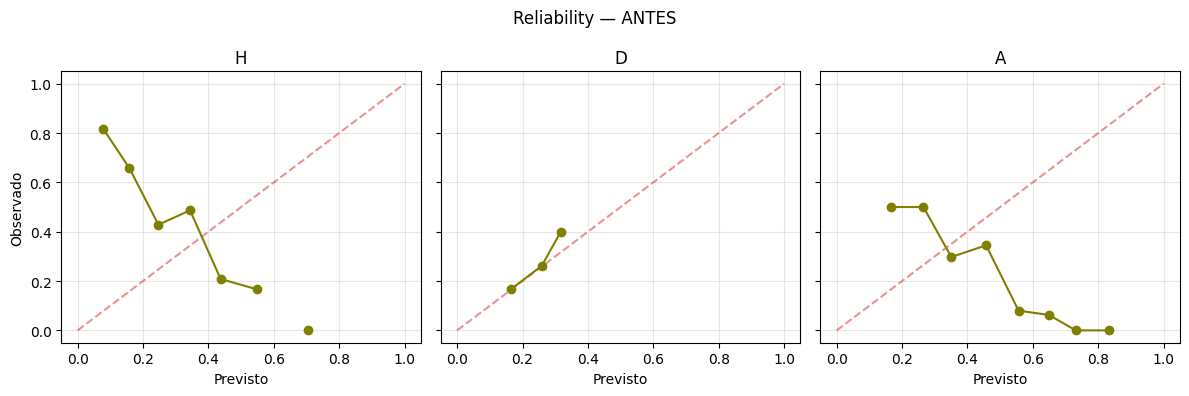

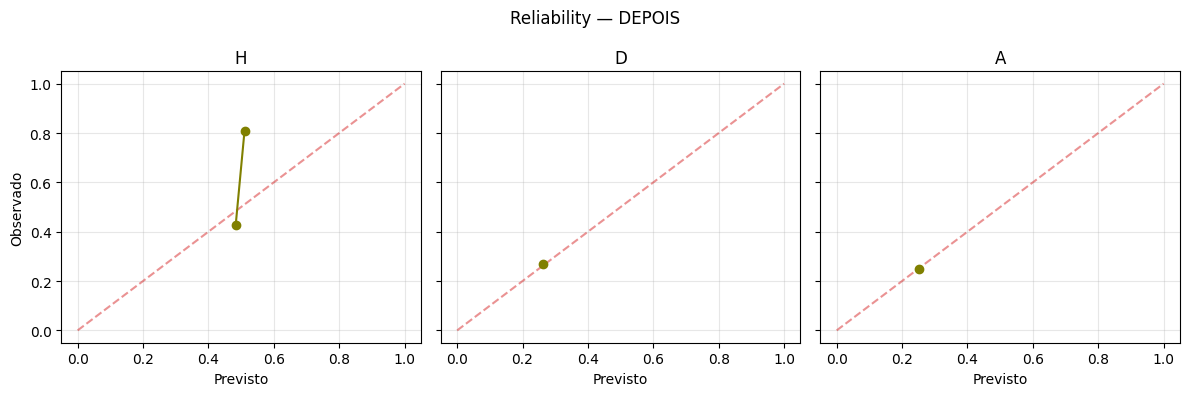

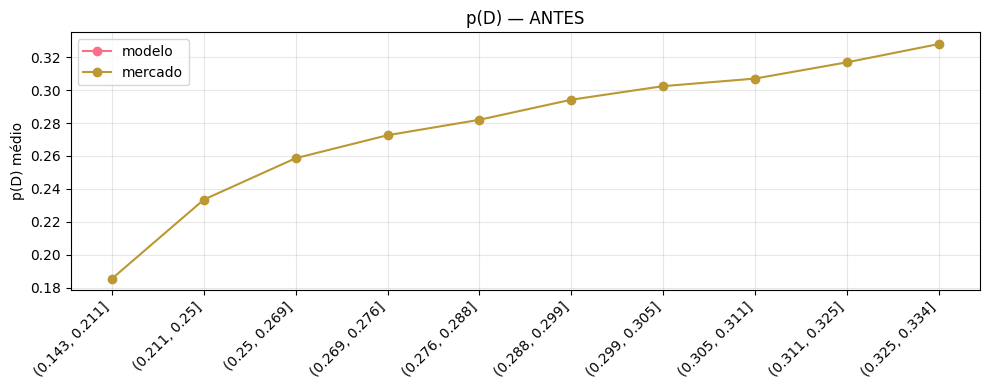

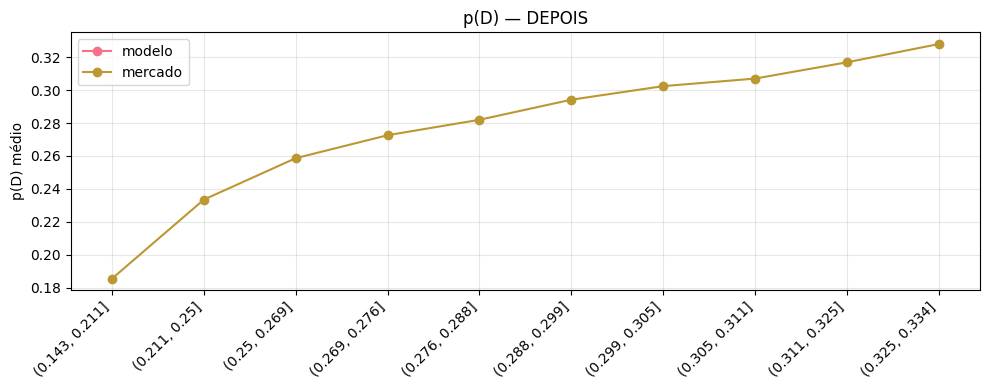

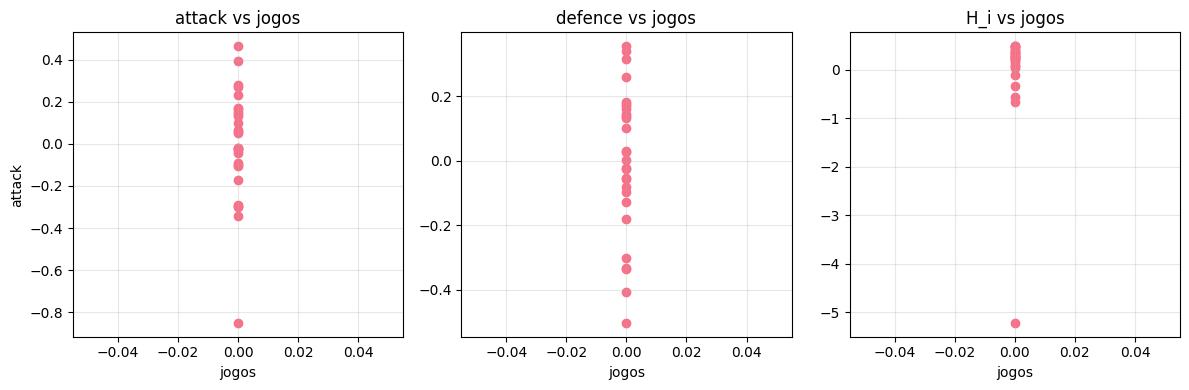

In [ ]:
# ============================================
# 1) Calibração por classe (isotônica 1x2)
# ============================================
import numpy as np
import pandas as pd
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

class Isotonic1x2:
    """Calibrador por classe: 3 regressões isotônicas (H, D, A) + renormalização linha-a-linha."""
    def __init__(self, y_min=0.0, y_max=1.0, out_of_bounds='clip'):
        self.models = [
            IsotonicRegression(y_min=y_min, y_max=y_max, out_of_bounds=out_of_bounds),
            IsotonicRegression(y_min=y_min, y_max=y_max, out_of_bounds=out_of_bounds),
            IsotonicRegression(y_min=y_min, y_max=y_max, out_of_bounds=out_of_bounds),
        ]
        self.fitted_ = False

    def fit(self, P: np.ndarray, y: np.ndarray):
        P = np.asarray(P, float)
        y = np.asarray(y, int)
        assert P.ndim == 2 and P.shape[1] == 3, "P deve ser (n,3)."
        for k in range(3):
            self.models[k].fit(P[:, k], (y == k).astype(int))
        self.fitted_ = True
        return self

    def transform(self, P: np.ndarray) -> np.ndarray:
        assert self.fitted_, "Chame .fit antes de .transform."
        P = np.asarray(P, float)
        out = np.column_stack([self.models[k].transform(P[:, k]) for k in range(3)])
        s = out.sum(axis=1, keepdims=True)
        s[s <= 0] = 1.0
        return out / s

    def fit_transform(self, P, y):
        return self.fit(P, y).transform(P)


# ============================================
# 2) Métricas + reliability (reaproveita seu helper)
# ============================================
def _y_true_1x2(df):
    gH = df['Goals_H_FT'].to_numpy()
    gA = df['Goals_A_FT'].to_numpy()
    return np.where(gH>gA, 0, np.where(gH==gA, 1, 2))

def multiclass_brier(P, y):
    n = len(y)
    Y = np.eye(3)[y]
    return float(np.sum((P - Y)**2) / n)

def reliability_table(df, P_cols=('P_H','P_D','P_A'), n_bins=10):
    y = _y_true_1x2(df)
    out = []
    classes = ['H','D','A']
    for k, c in enumerate(P_cols):
        p = df[c].astype(float).to_numpy()
        edges = np.linspace(0, 1, n_bins+1)
        idx = np.clip(np.digitize(p, edges, right=True)-1, 0, n_bins-1)
        for b in range(n_bins):
            m = (idx == b)
            nb = int(m.sum())
            if nb == 0:
                out.append(dict(classe=classes[k], bin_left=edges[b], bin_right=edges[b+1],
                                n=0, p_mean=np.nan, freq_obs=np.nan))
                continue
            out.append(dict(
                classe=classes[k], bin_left=edges[b], bin_right=edges[b+1],
                n=nb, p_mean=float(p[m].mean()), freq_obs=float((y[m]==k).mean())
            ))
    return pd.DataFrame(out)

def plot_reliability(rel_df, title='Reliability (previsto vs. observado)'):
    fig, axarr = plt.subplots(1, 3, figsize=(12,4), sharex=True, sharey=True)
    for i, cls in enumerate(['H','D','A']):
        t = rel_df[rel_df['classe']==cls].sort_values('bin_left')
        ax = axarr[i]
        ax.plot([0,1],[0,1], linestyle='--', color='tab:red', alpha=0.5)
        ax.plot(t['p_mean'], t['freq_obs'], marker='o', color='olive')
        ax.set_title(cls); ax.set_xlabel('Previsto');
        if i==0: ax.set_ylabel('Observado')
        ax.grid(True, alpha=0.3)
    fig.suptitle(title); plt.tight_layout()
    return fig

def evaluate_calibration(df, P_cols=('P_H','P_D','P_A'), tag='modelo'):
    y = _y_true_1x2(df)
    P = df[list(P_cols)].astype(float).to_numpy()
    metrics = {
        'tag': tag,
        'logloss': float(log_loss(y, P, labels=[0,1,2])),
        'brier': multiclass_brier(P, y),
        'acc_top1': float((P.argmax(1) == y).mean()),
        'n': int(len(df))
    }
    rel = reliability_table(df, P_cols=P_cols, n_bins=10)
    return metrics, rel


# ============================================
# 3) Mercado robusto + buckets p(D)
# ============================================
def devig_3way(oH: float, oX: float, oA: float, eps: float = 1e-9):
    oH, oX, oA = float(oH), float(oX), float(oA)
    if (oH <= 1) or (oX <= 1) or (oA <= 1) or not np.isfinite(oH+oX+oA):
        return (1/3, 1/3, 1/3)
    inv = np.array([1.0/oH, 1.0/oX, 1.0/oA], dtype=float)
    s = inv.sum()
    if s <= 0 or not np.isfinite(s): return (1/3, 1/3, 1/3)
    p = np.clip(inv/s, eps, 1-eps); p /= p.sum()
    return float(p[0]), float(p[1]), float(p[2])

def add_p_mkt_robusto(df, odd_cols=('Odd_H_FT','Odd_D_FT','Odd_A_FT')):
    oH, oD, oA = odd_cols
    tmp = df.copy()
    for c in (oH, oD, oA):
        tmp[c] = pd.to_numeric(tmp[c], errors='coerce')
    pm = tmp[[oH,oD,oA]].apply(lambda r: devig_3way(r[oH], r[oD], r[oA]), axis=1, result_type='expand')
    pm.columns = ['p_mkt_H','p_mkt_D','p_mkt_A']
    return pd.concat([tmp.reset_index(drop=True), pm.astype(float)], axis=1)

def compare_draw_buckets_robusto(df, P_cols=('P_H','P_D','P_A'),
                                 odd_cols=('Odd_H_FT','Odd_D_FT','Odd_A_FT'),
                                 n_bins=10, by='p_mkt_D'):
    tmp = df.copy()
    for c in P_cols: tmp[c] = pd.to_numeric(tmp[c], errors='coerce')
    tmp = add_p_mkt_robusto(tmp, odd_cols)
    if by == 'Odd_D_FT':
        bins = pd.qcut(tmp['Odd_D_FT'], q=n_bins, duplicates='drop')
    else:
        bins = pd.qcut(tmp['p_mkt_D'], q=n_bins, duplicates='drop')
    tmp = tmp.assign(bucket=bins)

    def _agg(g):
        return pd.Series({
            'pD_model': float(np.nanmean(g[P_cols[1]].to_numpy(dtype=float))),
            'pD_market': float(np.nanmean(g['p_mkt_D'].to_numpy(dtype=float))),
            'n': int(len(g))
        })
    out = (tmp.groupby('bucket', observed=True).apply(_agg).reset_index())
    print("linhas:", len(tmp), "| P_D NaN%:", float(tmp[P_cols[1]].isna().mean()),
          "| p_mkt_D NaN%:", float(tmp['p_mkt_D'].isna().mean()))
    return out

def plot_draw_buckets(buckets_df, title='p(D) — modelo vs mercado (por bucket)'):
    x = np.arange(len(buckets_df))
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(x, buckets_df['pD_model'], marker='o', label='modelo')
    ax.plot(x, buckets_df['pD_market'], marker='o', label='mercado')
    ax.set_xticks(x); ax.set_xticklabels([str(c) for c in buckets_df['bucket']], rotation=45, ha='right')
    ax.set_ylabel('p(D) médio'); ax.set_title(title); ax.grid(True, alpha=0.3); ax.legend()
    plt.tight_layout()
    return fig


# ============================================
# 4) Sanity dos efeitos por time (mesmo de antes)
# ============================================
def sanity_check_team_effects(dc_model: dict, df_train: pd.DataFrame,
                              n_thresh: int = 20, z_thresh: float = 2.0) -> pd.DataFrame:
    atk = pd.Series(dc_model['attack'])
    dfn = pd.Series(dc_model['defence'])
    Hi  = pd.Series(dc_model['home_advantage_team'])
    teams = sorted(set(df_train['Home']).union(df_train['Away']))

    n_games = (
        df_train[['Home','Away']]
        .melt(value_name='team')[['team']]
        .value_counts()
        .reindex(teams).fillna(0).astype(int)
    )
    def _z(s):
        m, sd = s.mean(), s.std(ddof=1); sd = sd if sd>0 else 1.0
        return (s - m)/sd

    z_atk, z_dfn, z_H = _z(atk), _z(dfn), _z(Hi)

    out = pd.DataFrame({
        'team': teams,
        'n_games': n_games.values,
        'attack': atk.reindex(teams).values,
        'defence': dfn.reindex(teams).values,
        'H_i': Hi.reindex(teams).values,
        'z_attack': z_atk.reindex(teams).values,
        'z_defence': z_dfn.reindex(teams).values,
        'z_H_i': z_H.reindex(teams).values,
    }).sort_values('n_games')
    out['flag_low_n_high_z'] = (
        (out['n_games'] < n_thresh) &
        ((out['z_attack'].abs() > z_thresh) |
         (out['z_defence'].abs() > z_thresh) |
         (out['z_H_i'].abs() > z_thresh))
    )
    return out

def plot_effects_vs_sample(df_eff):
    fig, ax = plt.subplots(1,3, figsize=(12,4), sharey=False)
    ax[0].scatter(df_eff['n_games'], df_eff['attack']); ax[0].set_title('attack vs jogos'); ax[0].set_xlabel('jogos'); ax[0].set_ylabel('attack')
    ax[1].scatter(df_eff['n_games'], df_eff['defence']); ax[1].set_title('defence vs jogos'); ax[1].set_xlabel('jogos')
    ax[2].scatter(df_eff['n_games'], df_eff['H_i']);     ax[2].set_title('H_i vs jogos');     ax[2].set_xlabel('jogos')
    for a in ax: a.grid(True, alpha=0.3)
    plt.tight_layout();
    return fig


# ============================================
# 5) RELATÓRIO ÚNICO (métricas + calibração + buckets + sanity)
# ============================================
def dc_full_report(df_val_old: pd.DataFrame,
                   df_val_new: pd.DataFrame,
                   dc_model: dict,
                   df_train_for_sanity: pd.DataFrame,
                   plot=True,
                   odd_cols=('Odd_H_FT','Odd_D_FT','Odd_A_FT'),
                   prob_cols=('P_H','P_D','P_A')):
    # -- métricas + reliability
    m_old, rel_old = evaluate_calibration(df_val_old, prob_cols, tag='antes')
    m_new, rel_new = evaluate_calibration(df_val_new, prob_cols, tag='depois')
    print(m_old); print(m_new)

    figs = []
    if plot:
        figs.append(plot_reliability(rel_old, 'Reliability — ANTES'))
        figs.append(plot_reliability(rel_new, 'Reliability — DEPOIS'))

    # -- buckets p(D)
    draw_old = compare_draw_buckets_robusto(df_val_old, P_cols=prob_cols, odd_cols=odd_cols)
    draw_new = compare_draw_buckets_robusto(df_val_new, P_cols=prob_cols, odd_cols=odd_cols)
    if plot:
        figs.append(plot_draw_buckets(draw_old, 'p(D) — ANTES'))
        figs.append(plot_draw_buckets(draw_new, 'p(D) — DEPOIS'))

    # -- sanity efeitos por time
    eff = sanity_check_team_effects(dc_model, df_train_for_sanity, n_thresh=25, z_thresh=2.5)
    if plot:
        figs.append(plot_effects_vs_sample(eff))

    # pacote de saída
    return {
        'metrics_old': m_old, 'metrics_new': m_new,
        'reliability_old': rel_old, 'reliability_new': rel_new,
        'draw_buckets_old': draw_old, 'draw_buckets_new': draw_new,
        'team_effects': eff,
        'figs': figs
    }


# ============================================
# 6) Exemplo de uso da calibração por classe
# ============================================
y_true_no_treino_calibracao = _y_true_1x2(df_val_old)  # por ex., use um holdout (ou cauda do treino)
P_old = df_val_old[['P_H','P_D','P_A']].to_numpy(float)
iso_cal = Isotonic1x2().fit(P_old, y_true_no_treino_calibracao)

# # Aplicar nos novos scores (pós-DC/pós-power)
P_new_raw = df_val_new[['P_H','P_D','P_A']].to_numpy(float)
P_new_cal = iso_cal.transform(P_new_raw)
df_val_new[['P_H','P_D','P_A']] = P_new_cal  # substitui pelas calibradas

# # Rodar relatório:
report = dc_full_report(df_val_old, df_val_new, dixon_coles_model, dados_historicos, plot=True)
display(report['draw_buckets_old'])
display(report['draw_buckets_new'])
display(report['team_effects'].head(20))


In [ ]:
# =====================================================
# HOTFIX: normaliza modelo DC (formato antigo -> novo)
# e reamarra o alias _dc_probs_1x2_em_lote
# =====================================================

def _normalize_dc_model(model: dict) -> dict:
    """Garante chaves esperadas pelo fast: attack/defence dict, teams, team_to_idx,
       home_advantage_team (H_i) e c0/c1 (rho paramétrico)."""
    import numpy as np
    m = dict(model)  # cópia rasa

    # --- teams ---
    teams = m.get('teams', None)
    if teams is None:
        atk_keys = set(m.get('attack', {}).keys()) if isinstance(m.get('attack'), dict) else set()
        dfn_keys = set(m.get('defence', {}).keys()) if isinstance(m.get('defence'), dict) else set()
        teams = sorted(atk_keys | dfn_keys)
        m['teams'] = teams

    # --- attack/defence como dict por time ---
    if 'attack' in m and not isinstance(m['attack'], dict):
        m['attack'] = dict(zip(teams, np.asarray(m['attack']).ravel()))
    if 'defence' in m and not isinstance(m['defence'], dict):
        m['defence'] = dict(zip(teams, np.asarray(m['defence']).ravel()))

    # --- team_to_idx ---
    if 'team_to_idx' not in m or not isinstance(m['team_to_idx'], dict):
        m['team_to_idx'] = {t: i for i, t in enumerate(teams)}

    # --- H_i por time (home_advantage_team) ---
    if 'home_advantage_team' not in m:
        # preferir H_i se existir; senão replicar escalar home_advantage; fallback 0
        if isinstance(m.get('H_i'), dict) and set(m['H_i'].keys()) >= set(teams):
            m['home_advantage_team'] = {t: float(m['H_i'][t]) for t in teams}
        else:
            ha = float(m.get('home_advantage', 0.0))
            m['home_advantage_team'] = {t: ha for t in teams}

    # --- ρ(λ) paramétrico (c0, c1). Se não vier, derive de rho escalar (c1=0) ou zere.
    if 'c0' not in m:
        m['c0'] = float(m.get('rho', 0.0))
    if 'c1' not in m:
        m['c1'] = 0.0

    return m

# Reamarra o alias para SEMPRE normalizar antes do fast
def _dc_probs_1x2_em_lote(df_subset, parametros_dc, max_goals=None):
    md = _normalize_dc_model(parametros_dc)
    # _dc_probs_1x2_em_lote_fast deve existir do módulo DC novo
    return _dc_probs_1x2_em_lote_fast(df_subset, md, max_goals=max_goals)


In [ ]:
# === Trust update (robusto): cria colunas que faltam e calcula TRUST ===
import numpy as np
import pandas as pd

# ------------- helpers -------------
def ensure_prob_columns_for_trust(df_hist_raw: pd.DataFrame, bases_candidatas):
    """
    Garante que df tenha colunas P_H_*, P_D_*, P_A_* para as bases disponíveis.
    Faz backfill para DC e (opcionalmente) para bases ML se houver features.
    Retorna (df_hist_completo, bases_presentes).
    """
    df = df_hist_raw.copy()
    bases_presentes = []

    # Detecta bases do ambiente
    bases_existentes = []
    if 'BASES_1x2' in globals() and isinstance(BASES_1x2, dict):
        bases_existentes.extend(list(BASES_1x2.keys()))
    if 'dixon_coles_model' in globals():
        bases_existentes.append('DC')

    # Filtra pela lista candidata passada
    bases_alvo = [b for b in bases_candidatas if b in set(bases_existentes)]

    # Checa quais já existem em df
    faltando = []
    for b in bases_alvo:
        trio = [f'P_H_{b}', f'P_D_{b}', f'P_A_{b}']
        if all(c in df.columns for c in trio):
            bases_presentes.append(b)
        else:
            faltando.append(b)

    # --- Backfill DC se faltar ---
    if ('DC' in faltando) and ('dixon_coles_model' in globals()):
        try:
            pH, pD, pA = _dc_probs_1x2_em_lote(df, dixon_coles_model)
            df['P_H_DC'], df['P_D_DC'], df['P_A_DC'] = pH, pD, pA
            bases_presentes.append('DC')
            faltando = [b for b in faltando if b != 'DC']
            print("✓ Backfill DC para histórico concluído.")
        except Exception as e:
            print(f"⚠️ Backfill DC falhou: {e}")

    # --- Backfill ML se features disponíveis (STACK1x2_COLS + SCALER) ---
    have_feats = ('STACK1x2_COLS' in globals() and
                  'STACK1x2_SCALER' in globals() and
                  isinstance(globals().get('STACK1x2_COLS'), (list, tuple)) and
                  all(c in df.columns for c in STACK1x2_COLS))
    if have_feats and 'BASES_1x2' in globals():
        try:
            X = (df[STACK1x2_COLS]
                 .replace([np.inf,-np.inf], np.nan)
                 .fillna(0.0)
                 .to_numpy(copy=False))
            Xs = STACK1x2_SCALER.transform(X)
            for b in [bb for bb in faltando if bb in BASES_1x2]:
                try:
                    P = np.clip(BASES_1x2[b].predict_proba(Xs), 1e-9, 1-1e-9)
                    df[f'P_H_{b}'], df[f'P_D_{b}'], df[f'P_A_{b}'] = P[:,0], P[:,1], P[:,2]
                    bases_presentes.append(b)
                    print(f"✓ Backfill {b} para histórico concluído.")
                except Exception as ee:
                    print(f"⚠️ Backfill base {b} falhou: {ee}")
        except Exception as e:
            print(f"⚠️ Falha ao preparar features para backfill ML: {e}")

    bases_presentes = sorted(set(bases_presentes), key=lambda x: bases_alvo.index(x) if x in bases_alvo else 999)
    return df, bases_presentes

def _devig_row(r):
    from math import isfinite
    oH, oD, oA = float(r['Odd_H_FT']), float(r['Odd_D_FT']), float(r['Odd_A_FT'])
    if oH<=1 or oD<=1 or oA<=1 or not isfinite(oH+oD+oA):
        return pd.Series([1/3,1/3,1/3], index=['p_mkt_H','p_mkt_D','p_mkt_A'])
    inv = np.array([1/oH, 1/oD, 1/oA], float)
    p = inv / inv.sum()
    p = np.clip(p, 1e-9, 1-1e-9); p /= p.sum()
    return pd.Series(p, index=['p_mkt_H','p_mkt_D','p_mkt_A'])

# ------------- prepara df_hist com as colunas necessárias -------------
# Bases candidatas (ajuste conforme seu ensemble):
bases_candidatas = ["NB","LGBM","MLP","CAT","XGB","DC"]

col_base = ["Date","Home","Away","Goals_H_FT","Goals_A_FT","Odd_H_FT","Odd_D_FT","Odd_A_FT"]
if not set(col_base) <= set(dados_historicos.columns):
    raise ValueError("dados_historicos precisa ter: " + ", ".join(col_base))

df_hist_raw = dados_historicos[col_base].copy()

# garante probs de mercado (devig)
if not {"p_mkt_H","p_mkt_D","p_mkt_A"} <= set(df_hist_raw.columns):
    df_hist_raw = pd.concat([df_hist_raw, df_hist_raw.apply(_devig_row, axis=1)], axis=1)

# cria/garante colunas P_*_BASE por base disponível
df_hist_ready, bases_presentes = ensure_prob_columns_for_trust(df_hist_raw, bases_candidatas)
print("Bases com colunas disponíveis para TRUST:", bases_presentes)

if len(bases_presentes) == 0:
    print("⚠️ Nenhuma base com P_* disponível. Mantendo TRUST_SCORES_1X2=1.0 para todas.")
    TRUST_SCORES_1X2 = {b: 1.0 for b in ["NB","LGBM","MLP","CAT","XGB","DC"]}
    # 2) Aplique o resultado medido (apenas DC), sem EMA e sem renormalizar as demais
    apply_trust_scores_1x2({'DC': 1.0}, ema=None, renorm=False)
    print(TRUST_SCORES_1X2)
    # Esperado: todas = 1.0
else:
    prob_cols = [f'{c}_{b}' for b in bases_presentes for c in ['P_H','P_D','P_A']]
    df_hist = df_hist_ready[col_base + ['p_mkt_H','p_mkt_D','p_mkt_A'] + prob_cols].copy()

    # ===== calcula TRUST (usa seus helpers já definidos) =====
    trust_new = recompute_trust_scores_1x2(
        df_hist,
        bases=bases_presentes,
        half_life_days=180,
        window_days=540,
        metric="logloss",
        compare_to_market=True,
        min_rows=300,
        target_eff_weight=250.0,
        clip_range=(0.6, 1.25)
    )
    print("trust_new:", trust_new)

    apply_trust_scores_1x2(trust_new, ema=0.35)
    print("TRUST_SCORES_1X2 atualizado:", TRUST_SCORES_1X2)

    # (opcional) persistir
    try:
        import json
        with open("trust_scores_1x2.json","w") as f:
            json.dump(TRUST_SCORES_1X2, f, indent=2)
    except Exception as e:
        print(f"⚠️ Falha ao salvar trust_scores_1x2.json: {e}")


✓ Backfill DC para histórico concluído.
Bases com colunas disponíveis para TRUST: ['DC']
trust_new: {'DC': 1.0}
TRUST_SCORES_1X2 atualizado: {'NB': 1.0, 'LGBM': 1.0, 'MLP': 1.0, 'CAT': 1.0, 'XGB': 1.0, 'DC': 0.87}



# ETAPA 7 — Validação Walk-Forward (5 janelas) + Calibração de Probabilidades

Objetivos desta seção:
- Criar **5 janelas rolantes** no tempo (treino cumulativo → validação na janela seguinte), reservando a **última temporada** como **holdout** intocado.
- Em cada janela, treinar **todos os modelos** com os **hiperparâmetros otimizados** (se disponíveis) e escolher o **melhor por AUC** naquela janela.
- Agregar as probabilidades do **melhor modelo de cada janela**, depois **calibrar** usando **Isotonic** e **Platt (Logística)**.
- Reportar **média e desvio** de **ROC AUC**, **Brier score** e **Log-loss** entre as janelas.
- Produzir **reliability plot** (curva de calibração).
- Avaliar um **holdout final** (última temporada) com e sem calibração.


In [ ]:
# ==========================================
# KERAS MLP CLASSIFIER (MULTICLASSE OU BINÁRIO)
# ==========================================
def _safe_mlp_multiclass(
    hidden=(256, 128),
    dropout=0.10,
    l2=1e-4,
    lr=1e-3,
    epochs=200,
    batch_size=128,
    patience=20,
    val_split=0.10,
    verbose=0,
    seed=42,
    n_classes=3
):
    """
    Wrapper seguro para KerasMLPClassifier.
    - Se TENSORFLOW_AVAILABLE=False, fallback para LogisticRegression multiclasse.
    - Evita crash no stack se TF não disponível.
    """
    global TENSORFLOW_AVAILABLE
    if TENSORFLOW_AVAILABLE:
        return KerasMLPClassifier(
            n_classes=n_classes,
            hidden=hidden,
            dropout=dropout,
            l2=l2,
            lr=lr,
            epochs=epochs,
            batch_size=batch_size,
            patience=patience,
            val_split=val_split,
            verbose=verbose,
            seed=seed
        )
    else:
        print("⚠️ TF não disponível — fallback para LogisticRegression multiclasse.")
        from sklearn.linear_model import LogisticRegression
        return LogisticRegression(
            multi_class="multinomial",
            solver="lbfgs",
            C=1.0 / l2,  # Inverso de l2 para simular regularização
            max_iter=epochs,
            random_state=seed,
            class_weight="balanced"  # Para multiclasse
        )
class KerasMLPClassifier:
    """
    Wrapper estilo sklearn para MLP multiclasses.
    - n_classes >= 2 (para binário usar n_classes=2)
    - y deve ser inteiro 0..K-1
    - predict_proba retorna matriz (n, K)
    """
    def __init__(self,
                 n_classes: int = 3,
                 hidden=(256, 128),
                 dropout: float = 0.10,
                 l2: float = 1e-4,
                 lr: float = 1e-3,
                 epochs: int = 200,
                 batch_size: int = 128,
                 patience: int = 20,
                 val_split: float = 0.10,
                 verbose: int = 0,
                 seed: int = 42):
        self.n_classes  = int(n_classes)
        self.hidden     = tuple(hidden)
        self.dropout    = float(dropout)
        self.l2         = float(l2)
        self.lr         = float(lr)
        self.epochs     = int(epochs)
        self.batch_size = int(batch_size)
        self.patience   = int(patience)
        self.val_split  = float(val_split)
        self.verbose    = int(verbose)
        self.seed       = int(seed)
        self.model_     = None
        self.input_dim_ = None

    def _build(self, input_dim: int):
        tf.keras.utils.set_random_seed(self.seed)
        inputs = layers.Input(shape=(input_dim,))
        x = inputs
        for units in self.hidden:
            x = layers.Dense(units, activation="relu",
                             kernel_regularizer=regularizers.l2(self.l2))(x)
            if self.dropout > 0:
                x = layers.Dropout(self.dropout)(x)
        if self.n_classes == 2:
            # Saída 2 classes via softmax
            outputs = layers.Dense(2, activation="softmax")(x)
            loss_fn = "sparse_categorical_crossentropy"
        else:
            outputs = layers.Dense(self.n_classes, activation="softmax")(x)
            loss_fn = "sparse_categorical_crossentropy"

        model = models.Model(inputs, outputs)
        model.compile(
            optimizer=optimizers.Adam(learning_rate=self.lr),
            loss=loss_fn,
            metrics=["accuracy"],
        )
        return model

    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float32)
        y = np.asarray(y, dtype=np.int32)
        self.input_dim_ = X.shape[1]
        self.model_ = self._build(self.input_dim_)
        es = callbacks.EarlyStopping(
            monitor="val_loss", patience=self.patience,
            restore_best_weights=True, verbose=0
        )
        self.model_.fit(
            X, y,
            validation_split=self.val_split,
            epochs=self.epochs,
            batch_size=self.batch_size,
            verbose=self.verbose,
            shuffle=False,  # séries temporais
            callbacks=[es],
        )
        return self

    def predict_proba(self, X):
        X = np.asarray(X, dtype=np.float32)
        P = self.model_.predict(X, verbose=0)
        P = np.asarray(P, float)
        # Robustez: se por algum motivo vier (n,1) no binário, converte p->[1-p, p]
        if P.ndim == 2 and P.shape[1] == 1:
            p1 = np.clip(P.ravel(), 1e-6, 1-1e-6)
            P = np.column_stack([1.0 - p1, p1])
        # Clip e normaliza
        P = np.clip(P, 1e-6, 1-1e-6)
        P = P / P.sum(axis=1, keepdims=True)
        return P
# ==========================================
# CALIBRADOR DIRICHLET (Kull et al., 2017)
# ==========================================
class DirichletCalibrator:
    """
    Regressão logística multinomial nos features:
      [log p1, ..., log pK, log(1-p1), ..., log(1-pK)]
    """
    def __init__(self, C=1.0, max_iter=2000, fit_intercept=True):
        self.clf = LogisticRegression(
            C=C, max_iter=max_iter, multi_class="multinomial", solver="lbfgs",
            fit_intercept=fit_intercept
        )
        self.fitted_ = False

    @staticmethod
    def _phi(P):
        P = np.clip(np.asarray(P, float), 1e-6, 1-1e-6)
        lp = np.log(P)
        lq = np.log(1 - P)
        return np.concatenate([lp, lq], axis=1)

    def fit(self, P_raw, y):
        X = self._phi(P_raw)
        self.clf.fit(X, np.asarray(y, int))
        self.fitted_ = True
        return self

    def transform(self, P_raw):
        if not self.fitted_:
            raise RuntimeError("DirichletCalibrator não ajustado.")
        X = self._phi(P_raw)
        P = self.clf.predict_proba(X)
        P = np.clip(P, 1e-6, 1-1e-6)
        P = P / P.sum(axis=1, keepdims=True)
        return P

    def predict_proba(self, P_raw):
        return self.transform(P_raw)

In [ ]:
# =========================================================================================
# ETAPA 8 — VALIDAÇÃO WALK-FORWARD E PREPARAÇÃO DOS DADOS
# As funções abaixo preparam os dados e as janelas para a validação temporal.
# =========================================================================================

def preparar_features_para_walk_forward(dataframe_com_momentum: pd.DataFrame) -> pd.DataFrame:
    """
    VERSÃO ATUALIZADA: Prepara o DataFrame (que já tem features de momentum)
    para o processo de walk-forward.

    1) Garante que as features de odds também foram criadas.
    2) Garante a coluna de data '__DF_DATE__' para ordenação temporal.
    """
    print("🛠️  Preparando DataFrame completo para o Walk-Forward...")

    # O DataFrame de entrada já deve ter as features de momentum.
    # A função abaixo garante que as features de odds também estão presentes.
    dataframe_com_features_completas = criar_features_basicas(dataframe_com_momentum).copy()

    # Lógica para garantir a coluna de data para ordenação (sem alterações)
    for nome_coluna_data in ['Date', 'date', 'DATA', 'Data', 'DATE']:
        if nome_coluna_data in dataframe_com_features_completas.columns:
            dataframe_com_features_completas['__DF_DATE__'] = pd.to_datetime(dataframe_com_features_completas[nome_coluna_data], errors='coerce')
            break

    if '__DF_DATE__' not in dataframe_com_features_completas.columns:
        dataframe_com_features_completas['__DF_DATE__'] = pd.date_range(start='2000-01-01', periods=len(dataframe_com_features_completas), freq='D')

    dataframe_com_features_completas = dataframe_com_features_completas.sort_values('__DF_DATE__').reset_index(drop=True)

    print("✅ DataFrame para Walk-Forward pronto.")
    return dataframe_com_features_completas

def gerar_janelas_por_indice(dataframe: pd.DataFrame, numero_de_janelas: int = 5, fracao_minima_treino: float = 0.05, amostras_minimas_treino: int = 50):
    tamanho_dataframe = len(dataframe)
    tamanho_holdout = max(1, int(round(0.10 * tamanho_dataframe)))

    inicio_holdout = tamanho_dataframe - tamanho_holdout
    fim_holdout = tamanho_dataframe

    dataframe_restante = dataframe.iloc[:inicio_holdout]
    tamanho_restante = len(dataframe_restante)

    tamanho_minimo_treino = max(amostras_minimas_treino, int(fracao_minima_treino * tamanho_restante))
    tamanho_minimo_treino = min(tamanho_minimo_treino, max(1, tamanho_restante - 2))

    pontos_de_corte = np.linspace(0, tamanho_restante, numero_de_janelas + 1, dtype=int)

    janelas = []
    for i in range(numero_de_janelas):
        inicio_validacao = max(pontos_de_corte[i], tamanho_minimo_treino)
        fim_validacao = pontos_de_corte[i+1]

        if fim_validacao - inicio_validacao > 1:
            if janelas and inicio_validacao <= janelas[-1][0]:
                inicio_validacao = janelas[-1][0] + 1
            if fim_validacao - inicio_validacao > 1:
                janelas.append((int(inicio_validacao), int(fim_validacao)))

    if len(janelas) > numero_de_janelas:
        janelas = janelas[-numero_de_janelas:]

    return janelas, (int(inicio_holdout), int(fim_holdout))

def gerar_janelas_por_ano_ou_indice(dataframe_com_features: pd.DataFrame, numero_de_janelas: int = 5, fracao_minima_treino: float = 0.05, amostras_minimas_treino: int = 50):
    dataframe = dataframe_com_features
    if '__DF_DATE__' in dataframe.columns:
        anos = dataframe['__DF_DATE__'].dt.year.values
        anos_unicos = np.unique(anos)
        if len(anos_unicos) >= 6:
            ano_holdout = anos_unicos[-1]
            mask_holdout = (anos == ano_holdout)
            inicio_holdout = int(np.nonzero(mask_holdout)[0][0])
            fim_holdout = int(np.nonzero(mask_holdout)[0][-1]) + 1
            anos_para_janelas = anos_unicos[:-1]
            anos_de_validacao = list(anos_para_janelas[-numero_de_janelas:])
            janelas_brutas = []
            for ano_validacao in anos_de_validacao:
                indices_validacao = np.nonzero(anos == ano_validacao)[0]
                inicio_validacao, fim_validacao = int(indices_validacao[0]), int(indices_validacao[-1]) + 1
                janelas_brutas.append((inicio_validacao, fim_validacao))

            tamanho_dados_treino = inicio_holdout
            tamanho_minimo_treino = max(amostras_minimas_treino, int(fracao_minima_treino * tamanho_dados_treino))
            tamanho_minimo_treino = min(tamanho_minimo_treino, max(1, tamanho_dados_treino - 2))

            janelas_filtradas = [(iv, fv) for (iv, fv) in janelas_brutas if iv >= tamanho_minimo_treino and fv - iv > 1]

            if len(janelas_filtradas) < numero_de_janelas:
                janelas_por_indice, _ = gerar_janelas_por_indice(dataframe.iloc[:inicio_holdout], numero_de_janelas=numero_de_janelas, fracao_minima_treino=fracao_minima_treino, amostras_minimas_treino=amostras_minimas_treino)
                todas_as_janelas = sorted(list(dict.fromkeys(janelas_filtradas + janelas_por_indice)), key=lambda x: x[0])
                return todas_as_janelas[-numero_de_janelas:], (inicio_holdout, fim_holdout)

            return janelas_filtradas[-numero_de_janelas:], (inicio_holdout, fim_holdout)
        else:
            return gerar_janelas_por_indice(dataframe, numero_de_janelas=numero_de_janelas, fracao_minima_treino=fracao_minima_treino, amostras_minimas_treino=amostras_minimas_treino)
    else:
        return gerar_janelas_por_indice(dataframe, numero_de_janelas=numero_de_janelas, fracao_minima_treino=fracao_minima_treino, amostras_minimas_treino=amostras_minimas_treino)

def instanciar_modelo_pelos_melhores_params(nome_modelo: str):
    melhores = globals().get('MELHORES_HIPERPARAMETROS_MODELOS_ML', None)

    if nome_modelo == "CatBoost":
        if melhores and "CatBoost" in melhores:
            return CatBoostClassifier(verbose=0, random_seed=42, **melhores["CatBoost"]["best_params"])
        return CatBoostClassifier(iterations=300, depth=6, learning_rate=0.1, verbose=0, random_seed=42)

    if nome_modelo == "XGBoost":
        if melhores and "XGBoost" in melhores:
            return XGBClassifier(verbosity=0, n_jobs=-1, random_state=42, **melhores["XGBoost"]["best_params"])
        return XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.1, random_state=42, verbosity=0)

    if nome_modelo == "LightGBM":
        if melhores and "LightGBM" in melhores:
            return LGBMClassifier(verbosity=-1, random_state=42, n_jobs=-1, **melhores["LightGBM"]["best_params"])
        return LGBMClassifier(n_estimators=300, max_depth=6, learning_rate=0.1, random_state=42, verbosity=-1)

    if nome_modelo == "RandomForest":
        if melhores and "RandomForest" in melhores:
            return RandomForestClassifier(random_state=42, n_jobs=-1, **melhores["RandomForest"]["best_params"])
        return RandomForestClassifier(n_estimators=500, max_depth=12, random_state=42)

    if nome_modelo == "NaiveBayes":
        if melhores and "NaiveBayes" in melhores:
            return GaussianNB(**melhores["NaiveBayes"]["best_params"])
        return GaussianNB()

    if nome_modelo == "MLP":
        # hiperparâmetros padrão razoáveis para tabular
        return KerasMLPClassifier(
            hidden=(128, 64), dropout=0.10, l2=1e-4,
            lr=1e-3, epochs=200, batch_size=128,
            patience=20, val_split=0.10, verbose=0, seed=42
        )

    raise ValueError(f"Modelo '{nome_modelo}' não suportado.")


def agregar_metricas_janelas(regs: List[Dict]) -> Dict:
    aucs, briers, lls = [], [], []
    for reg in regs:
        mm = reg["melhor_modelo"]; met = reg["metricas_por_modelo"][mm]
        aucs.append(met["ROC_AUC"]); briers.append(met["Brier"]); lls.append(met["LogLoss"])
    return {"ROC_AUC_media":float(np.mean(aucs)), "ROC_AUC_desvio":float(np.std(aucs,ddof=1)) if len(aucs)>1 else 0.0,
            "Brier_media":float(np.mean(briers)), "Brier_desvio":float(np.std(briers,ddof=1)) if len(briers)>1 else 0.0,
            "LogLoss_media":float(np.mean(lls)), "LogLoss_desvio":float(np.std(lls,ddof=1)) if len(lls)>1 else 0.0}

In [ ]:
# ==========================================
# GERAR alvo 1x2 ROBUSTO: Resultado_1X2 (0=Home,1=Draw,2=Away)
# ==========================================
TARGET_1X2 = "Resultado_1X2"   # 0=Home, 1=Draw, 2=Away

def _from_goals(df: pd.DataFrame):
    # 1) nomes exatos que você tem
    if ("Goals_H_FT" in df.columns) and ("Goals_A_FT" in df.columns):
        h = pd.to_numeric(df["Goals_H_FT"], errors="coerce")
        a = pd.to_numeric(df["Goals_A_FT"], errors="coerce")
        return np.where(h>a,0,np.where(h==a,1,2))

    # 2) aliases
    cand_home = ["Goals_H_FT","FTHG","FT_HG","HomeGoals","Gols_Casa","HG","Home_Goals","FT_H","Goals_Home"]
    cand_away = ["Goals_A_FT","FTAG","FT_AG","AwayGoals","Gols_Fora","AG","Away_Goals","FT_A","Goals_Away"]
    hcol = next((c for c in cand_home if c in df.columns), None)
    acol = next((c for c in cand_away if c in df.columns), None)
    if hcol and acol:
        h = pd.to_numeric(df[hcol], errors="coerce")
        a = pd.to_numeric(df[acol], errors="coerce")
        return np.where(h>a,0,np.where(h==a,1,2))

    # 3) padrões 'goals_h' / 'goals_a'
    cols = df.columns
    h_guess = next((c for c in cols if re.search(r'(?i)\bgoals?_?h(_?ft)?\b', c)), None)
    a_guess = next((c for c in cols if re.search(r'(?i)\bgoals?_?a(_?ft)?\b', c)), None)
    if h_guess and a_guess:
        h = pd.to_numeric(df[h_guess], errors="coerce")
        a = pd.to_numeric(df[a_guess], errors="coerce")
        if h.notna().any() and a.notna().any():
            return np.where(h>a,0,np.where(h==a,1,2))

    return None

def _from_rotulo_categorico(df: pd.DataFrame):
    # mapeia FTR/Resultado para 0/1/2
    mapa = {"H":0, "D":1, "A":2, "1":0, "X":1, "2":2, "HOME":0, "DRAW":1, "AWAY":2, 0:0, 1:1, 2:2}
    cand = [c for c in df.columns if re.search(r'(FTR|resultado|res_?1x2|winner|vencedor)', c, re.I)]
    for col in cand:
        s = df[col]
        if s.dtype == object:
            s_norm = s.astype(str).str.upper().str.strip().map(mapa)
            if s_norm.notna().any():
                return s_norm.fillna(1).astype(int).values
        # numérico 0/1/2
        u = pd.to_numeric(s, errors="coerce")
        if u.notna().any() and set(pd.unique(u.dropna())) <= {0,1,2}:
            return u.fillna(1).astype(int).values
    return None

def _from_score_string(df: pd.DataFrame):
    pat = re.compile(r'^\s*(\d+)\s*[-–xX]\s*(\d+)\s*$')
    for col in df.columns:
        s = df[col].astype(str).str.strip()
        m = s.map(lambda v: bool(pat.match(v)))
        if m.mean() > 0.2:
            def decide(v):
                mm = pat.match(v)
                if not mm: return np.nan
                hg, ag = int(mm.group(1)), int(mm.group(2))
                return 0 if hg>ag else (1 if hg==ag else 2)
            out = s.map(decide).values
            return pd.Series(out).fillna(method='ffill').fillna(method='bfill').fillna(1).astype(int).values
    return None

def garantir_target_1x2(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if TARGET_1X2 in df.columns:
        return df
    s = _from_goals(df)
    if s is None:
        s = _from_rotulo_categorico(df)
    if s is None:
        s = _from_score_string(df)
    if s is None:
        raise KeyError("Não consegui criar 'Resultado_1X2'. Forneça gols FT, FTR/Resultado (H/D/A) ou placar (ex.: 2-1).")
    # s pode ser np.ndarray ou Series; garanta Series alinhada
    if isinstance(s, np.ndarray):
        s = pd.Series(s, index=df.index)
    df[TARGET_1X2] = s.astype(int).values
    return df


In [ ]:
# ==========================================
# DC 1x2 (fallback) + TREINO DO STACK 1x2 + SALVAR BASES
# ==========================================


def treinar_stack_1x2_dirichlet(
    dataframe_com_features: pd.DataFrame,
    lista_de_features_selecionadas: list,
    coluna_alvo: str = "Resultado_1X2",
    numero_de_splits: int = 5,
    coluna_ordem_temporal: str = 'Date',
    usar_naive_bayes=True,
    usar_lightgbm=True,
    usar_mlp=True,
    usar_catboost=True,
    usar_xgboost=True
):
    """
    VERSÃO FINAL: Função de treino pura que recebe a lista final de features (pré-selecionadas)
    e treina o modelo de stacking completo.

    Gera previsões Out-of-Fold (OOF) para os modelos base e treina um meta-modelo sobre elas.
    Calibra a previsão final com o Calibrador Dirichlet e salva todos os artefatos (modelos, scaler, etc.)
    nas variáveis globais para uso posterior.
    """
    # Imports opcionais (assuma já importados no notebook; adicione se necessário)
    from sklearn.model_selection import TimeSeriesSplit
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LogisticRegression
    import numpy as np

    LGBMClassifier_ = None
    CatBoostClassifier_ = None
    XGBClassifier_ = None
    if usar_lightgbm:
        try: from lightgbm import LGBMClassifier as LGBMClassifier_
        except Exception: usar_lightgbm = False
    if usar_catboost:
        try: from catboost import CatBoostClassifier as CatBoostClassifier_
        except Exception: usar_catboost = False
    if usar_xgboost:
        try: from xgboost import XGBClassifier as XGBClassifier_
        except Exception: usar_xgboost = False

    # --- PASSO 1: PREPARAR DADOS DE ENTRADA ---
    # Garante a ordenação temporal antes de qualquer coisa
    dataframe_ordenado = dataframe_com_features.sort_values(coluna_ordem_temporal).reset_index(drop=True)

    matriz_de_features = dataframe_ordenado[lista_de_features_selecionadas].replace([np.inf,-np.inf], np.nan).fillna(0.0)
    vetor_alvo = dataframe_ordenado[coluna_alvo].astype(int).values

    scaler_geral = StandardScaler().fit(matriz_de_features)
    matriz_de_features_escalada = scaler_geral.transform(matriz_de_features)

    # Define o splitter, que será usado de forma consistente
    time_series_split = TimeSeriesSplit(n_splits=numero_de_splits)
    numero_de_amostras, numero_de_classes = len(vetor_alvo), 3

    # Estruturas para armazenar as previsões Out-of-Fold (OOF)
    previsoes_oof = {}
    if usar_naive_bayes: previsoes_oof["NB"]   = np.zeros((numero_de_amostras, numero_de_classes))
    if usar_lightgbm:    previsoes_oof["LGBM"] = np.zeros((numero_de_amostras, numero_de_classes))
    if usar_mlp:         previsoes_oof["MLP"]  = np.zeros((numero_de_amostras, numero_de_classes))
    if usar_catboost:    previsoes_oof["CAT"]  = np.zeros((numero_de_amostras, numero_de_classes))
    if usar_xgboost:     previsoes_oof["XGB"]  = np.zeros((numero_de_amostras, numero_de_classes))
    previsoes_oof["DC"] = np.zeros((numero_de_amostras, numero_de_classes))

    print(f"\n🚀 Iniciando o treinamento do Stack (Walk-Forward) com {len(lista_de_features_selecionadas)} features selecionadas...")

    # --- PASSO 2: LOOP DE VALIDAÇÃO CRUZADA TEMPORAL (WALK-FORWARD) ---
    for indices_de_treino, indices_de_validacao in time_series_split.split(matriz_de_features_escalada):
        X_treino_escalado, X_validacao_escalado = matriz_de_features_escalada[indices_de_treino], matriz_de_features_escalada[indices_de_validacao]
        y_treino = vetor_alvo[indices_de_treino]

        # Treinamento dos modelos base para gerar previsões OOF
        if usar_naive_bayes:
            modelo_nb = OvRNB(K=numero_de_classes).fit(X_treino_escalado, y_treino)
            previsoes_oof["NB"][indices_de_validacao,:] = np.clip(modelo_nb.predict_proba(X_validacao_escalado), 1e-6, 1-1e-6)

        if usar_lightgbm and LGBMClassifier_:
            modelo_lgbm = LGBMClassifier_(objective="multiclass", num_class=numero_de_classes, random_state=42, verbosity=-1).fit(X_treino_escalado, y_treino)
            previsoes_oof["LGBM"][indices_de_validacao,:] = np.clip(modelo_lgbm.predict_proba(X_validacao_escalado), 1e-6, 1-1e-6)

        if usar_mlp:
            modelo_mlp = _safe_mlp_multiclass(hidden=(256,128), dropout=0.10, l2=1e-4, lr=1e-3, epochs=200, batch_size=128, patience=20, val_split=0.10, verbose=0, seed=42, n_classes=numero_de_classes).fit(X_treino_escalado, y_treino)
            previsoes_oof["MLP"][indices_de_validacao,:] = np.clip(modelo_mlp.predict_proba(X_validacao_escalado), 1e-6, 1-1e-6)

        if usar_catboost and CatBoostClassifier_:
            modelo_cat = CatBoostClassifier_(loss_function="MultiClass", iterations=500, random_state=42, verbose=False).fit(X_treino_escalado, y_treino)
            previsoes_oof["CAT"][indices_de_validacao,:] = np.clip(np.asarray(modelo_cat.predict_proba(X_validacao_escalado)), 1e-6, 1-1e-6)

        if usar_xgboost and XGBClassifier_:
            modelo_xgb = XGBClassifier_(objective="multi:softprob", n_estimators=500, tree_method="hist", random_state=42, n_jobs=-1).fit(X_treino_escalado, y_treino)
            previsoes_oof["XGB"][indices_de_validacao,:] = np.clip(np.asarray(modelo_xgb.predict_proba(X_validacao_escalado)), 1e-6, 1-1e-6)

        dataframe_de_validacao = dataframe_com_features.iloc[indices_de_validacao]
        probabilidades_dc = _dc_probs_1x2_em_lote(dataframe_de_validacao, globals().get("dixon_coles_model", None))

        # Correção: Stack tupla para matriz (n_valid, 3)
        probabilidades_dc_matrix = np.column_stack(probabilidades_dc)

        # Clip e assign
        previsoes_oof["DC"][indices_de_validacao, :] = np.clip(probabilidades_dc_matrix, 1e-6, 1-1e-6)

    # --- PASSO 3: MONTAGEM E TREINO DO META-MODELO (STACKING) ---
    odds_completas = dataframe_com_features[["Odd_H_FT","Odd_D_FT","Odd_A_FT"]].astype(float).values
    probabilidades_mercado = np.vstack([devig_3way(h,d,a) for (h,d,a) in odds_completas])
    logits_mercado = np.log(np.clip(probabilidades_mercado, 1e-6, 1-1e-6))

    partes_do_stack = [logits_mercado]
    ordem_dos_modelos = []
    for nome_modelo in ["NB", "LGBM", "MLP", "CAT", "XGB"]:
        if nome_modelo in previsoes_oof:
            partes_do_stack.append(previsoes_oof[nome_modelo])
            ordem_dos_modelos.append(nome_modelo)
    partes_do_stack.append(previsoes_oof["DC"])

    matriz_de_features_do_stack = np.concatenate(partes_do_stack, axis=1)

    meta_modelo = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=1.0, max_iter=3000, random_state=42).fit(matriz_de_features_do_stack, vetor_alvo)
    previsoes_brutas_oof = np.clip(meta_modelo.predict_proba(matriz_de_features_do_stack), 1e-6, 1-1e-6)
    calibrador_dirichlet = DirichletCalibrator(C=1.0, max_iter=2000, fit_intercept=True).fit(previsoes_brutas_oof, vetor_alvo)
    previsoes_calibradas_oof = np.clip(calibrador_dirichlet.transform(previsoes_brutas_oof), 1e-6, 1-1e-6)

    # --- PASSO 4: TREINAMENTO DOS MODELOS FINAIS PARA USO NO DIA A DIA ---
    print("\nTreinando modelos base finais com os dados completos e features selecionadas...")
    modelos_base_finais = {}
    if usar_naive_bayes: modelos_base_finais["NB"] = OvRNB(K=numero_de_classes).fit(matriz_de_features_escalada, vetor_alvo)
    if usar_lightgbm and LGBMClassifier_: modelos_base_finais["LGBM"] = LGBMClassifier_(objective="multiclass", num_class=numero_de_classes, random_state=42, verbosity=-1).fit(matriz_de_features_escalada, vetor_alvo)
    if usar_mlp: modelos_base_finais["MLP"] = _safe_mlp_multiclass(hidden=(256,128), dropout=0.10, l2=1e-4, lr=1e-3, epochs=200, batch_size=128, patience=20, val_split=0.10, verbose=0, seed=42, n_classes=numero_de_classes).fit(matriz_de_features_escalada, vetor_alvo)
    if usar_catboost and CatBoostClassifier_: modelos_base_finais["CAT"] = CatBoostClassifier_(loss_function="MultiClass", iterations=700, random_state=42, verbose=False).fit(matriz_de_features_escalada, vetor_alvo)
    if usar_xgboost and XGBClassifier_: modelos_base_finais["XGB"] = XGBClassifier_(objective="multi:softprob", n_estimators=700, tree_method="hist", random_state=42, n_jobs=-1).fit(matriz_de_features_escalada, vetor_alvo)

    # --- PASSO 5: SALVAR TODOS OS ARTEFATOS PARA USO POSTERIOR ---
    globals().update({
        "STACK1x2_META":   meta_modelo,
        "STACK1x2_CAL":    calibrador_dirichlet,
        "STACK1x2_SCALER": scaler_geral,
        "BASES_1x2":       modelos_base_finais,
        "STACK1x2_ORDER":  ["MKT_LOG"] + ordem_dos_modelos + ["DC"],
        "STACK1x2_COLS":   lista_de_features_selecionadas, # Salva a lista de features que foi efetivamente usada
    })

    print("✅ STACK1x2 pronto: | bases:", list(modelos_base_finais.keys()))
    return {"P_raw_oof": previsoes_brutas_oof, "P_cal_oof": previsoes_calibradas_oof, "y": vetor_alvo}


In [ ]:
# ==========================================
# RELIABILITY PLOT 1x2 (por classe e macro)
# ==========================================


def plot_reliability_1x2(oof_pack: Dict[str, np.ndarray], n_bins: int = 10):
    assert all(k in oof_pack for k in ["P_raw_oof","P_cal_oof","y"]), "Pacote OOF incompleto."
    P_raw = oof_pack["P_raw_oof"]; P_cal = oof_pack["P_cal_oof"]; y_true = oof_pack["y"]
    K = P_raw.shape[1]
    labels = ["Home","Draw","Away"][:K]

    def reliab_bins(y, p, n_bins=10):
        q = np.quantile(p, np.linspace(0,1,n_bins+1))
        q[0], q[-1] = 0.0, 1.0
        bins = np.digitize(p, q[1:-1], right=False)
        out = []
        for b in range(n_bins):
            idx = (bins == b)
            if idx.sum() == 0:
                out.append((np.nan, np.nan, 0))
            else:
                out.append((p[idx].mean(), y[idx].mean(), idx.sum()))
        dfb = pd.DataFrame(out, columns=["p_mean","freq","n"]).dropna()
        return dfb

    # Por classe
    plt.figure(figsize=(6,6))
    plt.plot([0,1], [0,1], '--', label='perfeita')
    for k in range(K):
        yk = (y_true == k).astype(int)
        df_raw = reliab_bins(yk, P_raw[:,k], n_bins=n_bins)
        df_cal = reliab_bins(yk, P_cal[:,k], n_bins=n_bins)
        plt.plot(df_raw["p_mean"], df_raw["freq"], marker='o', label=f'{labels[k]} raw')
        plt.plot(df_cal["p_mean"], df_cal["freq"], marker='o', label=f'{labels[k]} cal')
    plt.xlabel('probabilidade prevista'); plt.ylabel('frequência observada')
    plt.title('Reliability 1x2 por classe (raw vs cal)')
    plt.legend(); plt.show()

    # Macro
    plt.figure(figsize=(6,6))
    plt.plot([0,1], [0,1], '--', label='perfeita')
    grid = np.linspace(0.05, 0.95, n_bins)
    for name, P in [("raw", P_raw), ("cal", P_cal)]:
        curves = []
        for k in range(K):
            yk = (y_true == k).astype(int)
            dfb = reliab_bins(yk, P[:,k], n_bins=n_bins)
            curves.append(np.interp(grid, dfb["p_mean"], dfb["freq"], left=np.nan, right=np.nan))
        macro = np.nanmean(np.vstack(curves), axis=0)
        plt.plot(grid, macro, marker='o', label=f'macro {name}')
    plt.xlabel('probabilidade prevista'); plt.ylabel('frequência observada (macro)')
    plt.title('Reliability 1x2 (macro)')
    plt.legend(); plt.show()


In [ ]:
print("ORDER salva:", globals().get("STACK1x2_ORDER"))
print("Bases 1x2:", list(globals().get("BASES_1x2", {}).keys()))
meta = globals().get("STACK1x2_META")
print("Meta espera n_features_in_:", getattr(meta, "n_features_in_", None),
      "=> blocos:", getattr(meta, "n_features_in_", 0)//3)


ORDER salva: ['MKT_LOG', 'NB', 'LGBM', 'MLP', 'CAT', 'XGB', 'DC']
Bases 1x2: ['NB', 'LGBM', 'MLP', 'CAT', 'XGB']
Meta espera n_features_in_: 21 => blocos: 7


In [ ]:

# ---------- função principal com skill + bootstrap ----------
def avaliar_holdout_1x2(df_feat: pd.DataFrame,
                        features: list,
                        alvo_col: str,
                        holdout_mask=None,
                        holdout_frac: float | None = None,
                        *,
                        odds_cols=('Odd_H_FT','Odd_D_FT','Odd_A_FT'),
                        title_suffix: str = "Holdout",
                        n_boot_ci: int = 5000,
                        seed_ci: int = 42) -> dict:
    """
    Avalia o stack no holdout, imprime Skill vs Mercado (RAW/CAL) e IC95% por bootstrap.
    Requer STACK1x2_META/STACK1x2_CAL globais e a função montar_Z_1x2(df).
    """
    assert 'STACK1x2_META' in globals(), "STACK1x2_META não encontrado."
    meta = globals()['STACK1x2_META']
    cal = globals().get('STACK1x2_CAL', None)

    df = df_feat.copy()

    # define máscara do holdout
    if holdout_mask is None:
        assert holdout_frac is not None and 0 < holdout_frac < 1, "Forneça holdout_mask ou holdout_frac."
        n = len(df)
        k = int(np.ceil(n * (1 - holdout_frac)))
        mask = np.zeros(n, dtype=bool); mask[k:] = True
    else:
        mask = np.asarray(holdout_mask, bool)

    df_test = df.loc[mask].copy()
    y_test_raw = df_test[alvo_col].values

    # rótulos 0..K-1
    if not np.issubdtype(y_test_raw.dtype, np.integer):
        y_test, _ = pd.factorize(y_test_raw)
    else:
        classes_sorted = np.unique(y_test_raw)
        map_classes = {c:i for i,c in enumerate(classes_sorted)}
        y_test = pd.Series(y_test_raw).map(map_classes).to_numpy()

    # garantir xG implícito e lista de features
    df_test = _ensure_xg_implied(df_test)
    globals()['STACK1x2_COLS'] = features

    # Z e P_mkt
    Z, P_mkt_try = montar_Z_1x2(df_test)
    P_mkt = (market_probs_from_odds(df_test, cols=odds_cols)
             if (P_mkt_try is None or np.any(~np.isfinite(P_mkt_try)))
             else P_mkt_try)

    # previsões
    P_raw = np.clip(meta.predict_proba(Z), 1e-12, 1-1e-12)
    P_cal = np.clip(cal.transform(P_raw), 1e-12, 1-1e-12) if cal is not None else P_raw

    # métricas padrão
    K = P_raw.shape[1]; labels = list(range(K))
    raw = {"LogLoss": log_loss(y_test, P_raw, labels=labels),
           "Brier":   brier_multiclass(y_test, P_raw)}
    cal_m = {"LogLoss": log_loss(y_test, P_cal, labels=labels),
             "Brier":   brier_multiclass(y_test, P_cal)}

    # uniform & mercado
    P_uniform = np.full_like(P_raw, 1.0 / K)
    LL_uniform = log_loss(y_test, P_uniform, labels=labels)
    LL_mkt = log_loss(y_test, P_mkt, labels=labels)
    B_mkt  = brier_multiclass(y_test, P_mkt)

    # skill point estimates
    skill_raw = {
        "LL_model": raw["LogLoss"], "LL_market": LL_mkt, "LL_uniform": LL_uniform,
        "LL_skill_vs_uniform": 1.0 - (raw["LogLoss"] / LL_uniform),
        "LL_gain_vs_market":   raw["LogLoss"] - LL_mkt,
        "Brier_model": raw["Brier"], "Brier_market": B_mkt,
        "Brier_Skill_Score": 1.0 - (raw["Brier"] / B_mkt)
    }
    skill_cal = {
        "LL_model": cal_m["LogLoss"], "LL_market": LL_mkt, "LL_uniform": LL_uniform,
        "LL_skill_vs_uniform": 1.0 - (cal_m["LogLoss"] / LL_uniform),
        "LL_gain_vs_market":   cal_m["LogLoss"] - LL_mkt,
        "Brier_model": cal_m["Brier"], "Brier_market": B_mkt,
        "Brier_Skill_Score": 1.0 - (cal_m["Brier"] / B_mkt)
    }

    # -------- bootstrap CIs --------
    ci_raw = _bootstrap_skill_ci(y_test, P_raw, P_mkt, LL_uniform=LL_uniform,
                                 n_boot=n_boot_ci, seed=seed_ci)
    ci_cal = _bootstrap_skill_ci(y_test, P_cal, P_mkt, LL_uniform=LL_uniform,
                                 n_boot=n_boot_ci, seed=seed_ci)

    # -------- impressão --------
    def _fmt_ci(triple, pct=False):
        m, lo, hi = triple
        return (f"{m:.4f} [{lo:.4f}, {hi:.4f}]" if not pct
                else f"{m*100:.2f}% [{lo*100:.2f}%, {hi*100:.2f}%]")

    print(f"\n=== Skill vs. Mercado ({title_suffix}) — RAW ===")
    print(f"LogLoss(modelo):   {skill_raw['LL_model']:.4f}")
    print(f"LogLoss(mercado):  {skill_raw['LL_market']:.4f}")
    print(f"LogLoss(uniforme): {skill_raw['LL_uniform']:.4f}")
    print(f"LL skill vs unif:  {skill_raw['LL_skill_vs_uniform']:.2%}  | CI95: {_fmt_ci(ci_raw['LL_skill'], pct=True)}")
    print(f"LL gain vs mkt:    {skill_raw['LL_gain_vs_market']:.4f} | CI95: {_fmt_ci(ci_raw['LL_gain'])}  (negativo = melhor)")
    print(f"Brier(modelo):     {skill_raw['Brier_model']:.4f}")
    print(f"Brier(mercado):    {skill_raw['Brier_market']:.4f}")
    print(f"Brier SkillScore:  {skill_raw['Brier_Skill_Score']:.2%} | CI95: {_fmt_ci(ci_raw['BSS'], pct=True)}")

    print(f"\n=== Skill vs. Mercado ({title_suffix}) — CAL ===")
    print(f"LogLoss(modelo):   {skill_cal['LL_model']:.4f}")
    print(f"LogLoss(mercado):  {skill_cal['LL_market']:.4f}")
    print(f"LogLoss(uniforme): {skill_cal['LL_uniform']:.4f}")
    print(f"LL skill vs unif:  {skill_cal['LL_skill_vs_uniform']:.2%}  | CI95: {_fmt_ci(ci_cal['LL_skill'], pct=True)}")
    print(f"LL gain vs mkt:    {skill_cal['LL_gain_vs_market']:.4f} | CI95: {_fmt_ci(ci_cal['LL_gain'])}  (negativo = melhor)")
    print(f"Brier(modelo):     {skill_cal['Brier_model']:.4f}")
    print(f"Brier(mercado):    {skill_cal['Brier_market']:.4f}")
    print(f"Brier SkillScore:  {skill_cal['Brier_Skill_Score']:.2%} | CI95: {_fmt_ci(ci_cal['BSS'], pct=True)}")

    return {
        "raw": raw,
        "cal": cal_m,
        "n_test": int(mask.sum()),
        "skill_raw": skill_raw,
        "skill_cal": skill_cal,
        "skill_raw_ci": ci_raw,
        "skill_cal_ci": ci_cal
    }


In [ ]:
def montar_Z_1x2(df: pd.DataFrame):
    """
    Constrói a matriz Z no MESMO formato do treino do meta 1x2.
    Faz auto-alinhamento: usa exatamente K blocos onde K = meta.n_features_in_ // 3.
    """
    assert "STACK1x2_SCALER" in globals(), "STACK1x2_SCALER não encontrado (rode o treino 1x2)."
    assert "STACK1x2_COLS"   in globals(), "STACK1x2_COLS não encontrado."
    assert "STACK1x2_ORDER"  in globals(), "STACK1x2_ORDER não encontrado."
    assert "STACK1x2_META"   in globals(), "STACK1x2_META não encontrado."

    scaler  = globals()["STACK1x2_SCALER"]
    cols    = globals()["STACK1x2_COLS"]
    order0  = list(globals()["STACK1x2_ORDER"])  # ordem salva no treino
    bases   = globals().get("BASES_1x2", {})

    # --- calcula quantos blocos o meta espera ---
    meta = globals()["STACK1x2_META"]
    n_in = getattr(meta, "n_features_in_", None)
    if n_in is None:
        raise RuntimeError("Meta 1x2 sem atributo n_features_in_.")
    need_blocks = int(n_in // 3)

    # --- monta componentes disponíveis ---
    P_mkt   = market_probs_from_odds(df)                     # (n,3)
    MKT_LOG = np.log(P_mkt)                      # (n,3)

    X = df[cols].replace([np.inf,-np.inf], np.nan).fillna(0.0)
    Xs = scaler.transform(X)

    comps = {"MKT_LOG": MKT_LOG}
    for name, model in bases.items():
        P = np.asarray(model.predict_proba(Xs))
        if P.ndim == 1:
            P = np.column_stack([1-P, P, np.full_like(P, 1e-9)])
        comps[name] = np.clip(P, 1e-9, 1-1e-9)

    # Correção: Chama _dc_probs_1x2_em_lote e stack para (n,3)
    p_h_dc, p_d_dc, p_a_dc = _dc_probs_1x2_em_lote(df, globals().get("dixon_coles_model", None))
    P_dc = np.column_stack([p_h_dc, p_d_dc, p_a_dc])
    comps["DC"] = np.clip(P_dc, 1e-9, 1-1e-9)

    # --- ordem efetiva: usa APENAS os primeiros K blocos disponíveis ---
    # garante que todos os nomes existem em comps; se não existir, pula
    order_eff = [k for k in order0 if k in comps][:need_blocks]
    if len(order_eff) != need_blocks:
        faltam = need_blocks - len(order_eff)
        raise ValueError(
            f"Desalinhamento: meta espera {need_blocks} blocos (={n_in} feats), "
            f"mas consegui montar {len(order_eff)} a partir de STACK1x2_ORDER. "
            f"Rode o treino 1x2 novamente ou garanta que as bases da ordem existam."
        )

    parts = [comps[k] for k in order_eff]
    Z = np.concatenate(parts, axis=1)            # (n, 3*need_blocks)

    return Z, P_mkt

In [ ]:
# =================================================================================
# Seleção HÍBRIDA com SHAP (multiclasse, time-aware, estável) - VERSÃO DEFINITIVA E AUTOCONTIDA
# =================================================================================
def selecionar_features_com_shap_hibrido(
    dataframe_completo: pd.DataFrame,
    lista_features_total: list,
    coluna_alvo: str,
    k: int = 15,
    obrigatorias: list = ('Prob_H_Adj', 'Prob_D_Adj', 'Prob_A_Adj'),
    *,
    coluna_ordem_temporal: str = 'Date',
    n_splits: int = 5,
    lgbm_params: dict | None = None,
    random_state: int = 42,
    plotar: bool = True
):
    """
    Seleciona k melhores features candidatas via SHAP em múltiplos folds (time-aware),
    preservando 'obrigatorias'. Robusto para diferentes formatos de saída do SHAP:
    - lista de arrays (um por classe)
    - array 3D (n_samples, n_features, n_classes)
    - array 2D (n_samples, n_features)

    Retorna:
      lista_final (list[str]): obrigatorias + top-k candidatas
      imp_df (pd.DataFrame): ['feature', 'mean_abs_shap'] ordenado desc
    """
    rng = check_random_state(random_state)

    # 0) separar obrigatórias e candidatas que de fato existem
    obrigatorias_existentes = [f for f in obrigatorias if f in lista_features_total]
    candidatas = [f for f in lista_features_total if f not in obrigatorias_existentes]
    if not candidatas:
        print("⚠️ Não há candidatas além das obrigatórias; retornando apenas obrigatórias.")
        imp_df_vazio = pd.DataFrame({'feature': obrigatorias_existentes, 'mean_abs_shap': np.nan})
        return obrigatorias_existentes, imp_df_vazio

    # 1) prepara X/y
    X_candidatas = dataframe_completo[candidatas].copy()
    y_alvo_raw = dataframe_completo[coluna_alvo].copy()

    # segurança: codificar rótulos em inteiros 0..C-1
    if not np.issubdtype(y_alvo_raw.dtype, np.integer):
        y_alvo, class_names = pd.factorize(y_alvo_raw)
    else:
        # mesmo se for inteiro, garanta que começam em 0 e são consecutivos
        classes_sorted = np.unique(y_alvo_raw)
        mapper = {c: i for i, c in enumerate(classes_sorted)}
        y_alvo = y_alvo_raw.map(mapper).to_numpy()
        class_names = [str(c) for c in classes_sorted]

    # ordenar por tempo (se a coluna existir)
    if coluna_ordem_temporal in dataframe_completo.columns:
        order_idx = np.argsort(pd.to_datetime(dataframe_completo[coluna_ordem_temporal]).values)
        X_candidatas = X_candidatas.iloc[order_idx].reset_index(drop=True)
        y_alvo = y_alvo[order_idx]

    # 2) splits time-aware
    splitter = TimeSeriesSplit(n_splits=n_splits)
    split_iter = splitter.split(X_candidatas, y_alvo)

    # 3) hiperparâmetros do "modelo juiz"
    n_classes = int(len(np.unique(y_alvo)))
    default_params = {
        'random_state': random_state,
        'n_estimators': 500,
        'learning_rate': 0.05,
    }
    # set objetivo multiclasse automaticamente, se necessário
    if n_classes > 2:
        default_params.setdefault('objective', 'multiclass')
        default_params.setdefault('num_class', n_classes)

    if lgbm_params:
        default_params.update(lgbm_params)

    importancias_acumuladas = np.zeros(len(candidatas), dtype=float)
    print(f"🕵️  Iniciando seleção HÍBRIDA em {n_splits} folds...")

    ultimo_shap_values_para_plot = None
    ultima_X_validacao_para_plot = None
    ultimo_class_names_para_plot = class_names  # para uso no summary_plot

    for fold, (train_idx, valid_idx) in enumerate(split_iter, 1):
        X_treino, X_validacao = X_candidatas.iloc[train_idx], X_candidatas.iloc[valid_idx]
        y_treino, y_valid = y_alvo[train_idx], y_alvo[valid_idx]

        modelo_juiz = LGBMClassifier(**default_params)
        modelo_juiz.fit(
            X_treino, y_treino,
            eval_set=[(X_validacao, y_valid)],
            eval_metric=('multi_logloss' if n_classes > 2 else 'logloss'),
            callbacks=[early_stopping(15, verbose=False)]
        )

        # ====== SHAP robusto: tenta probability+interventional, senão cai para raw ======
        n_bg = min(2000, len(X_treino))
        bg = X_treino.sample(n=n_bg, random_state=random_state) if n_bg > 0 else X_treino

        try:
            explainer = shap.TreeExplainer(
                modelo_juiz,
                data=bg,
                feature_perturbation="interventional",
                model_output="probability"
            )
            shap_values_fold = explainer.shap_values(X_validacao)
        except Exception:
            explainer = shap.TreeExplainer(
                modelo_juiz,
                model_output="raw"  # sempre suportado com tree_path_dependent
            )
            shap_values_fold = explainer.shap_values(X_validacao)
        # ====== fim bloco SHAP ======

        # --- AGREGAÇÃO ROBUSTA PARA (n_features,) ---
        if isinstance(shap_values_fold, list):
            # lista de (n_samples, n_features) por classe
            importancia_do_fold = np.zeros(X_validacao.shape[1], dtype=float)
            for arr in shap_values_fold:
                importancia_do_fold += np.abs(arr).mean(axis=0)
        else:
            arr = np.asarray(shap_values_fold)
            if arr.ndim == 3:
                # (n_samples, n_features, n_classes)
                importancia_do_fold = np.abs(arr).mean(axis=(0, 2))
            elif arr.ndim == 2:
                # (n_samples, n_features)
                importancia_do_fold = np.abs(arr).mean(axis=0)
            else:
                raise ValueError(f"Formato inesperado dos SHAP values: shape={arr.shape}, ndim={arr.ndim}")

        importancias_acumuladas += importancia_do_fold
        ultimo_shap_values_para_plot = shap_values_fold
        ultima_X_validacao_para_plot = X_validacao

    # 4) consolidação e top-k
    importancia_media = importancias_acumuladas / n_splits
    imp_df = (
        pd.DataFrame({'feature': candidatas, 'mean_abs_shap': importancia_media})
        .sort_values('mean_abs_shap', ascending=False)
        .reset_index(drop=True)
    )

    melhores_candidatas = imp_df.head(k)['feature'].tolist()
    lista_final = obrigatorias_existentes + melhores_candidatas

    print(f"\n✅ Seleção concluída. {len(obrigatorias_existentes)} obrigatórias + {len(melhores_candidatas)} candidatas = {len(lista_final)} no total.")
    # opcional: exibir as listas
    # print("Obrigatórias:", obrigatorias_existentes)
    # print("Top candidatas:", melhores_candidatas)

    # 5) plots
    if plotar:
        top_plot = imp_df.head(max(25, k))
        plt.figure(figsize=(10, 8))
        plt.barh(top_plot['feature'][::-1], top_plot['mean_abs_shap'][::-1])
        plt.xlabel('Média do |Valor SHAP| (agregado em folds e classes)')
        plt.title('Importância das Features Candidatas')
        plt.tight_layout()
        plt.show()

        if ultimo_shap_values_para_plot is not None:
            print("\nGráfico Detalhado de SHAP (último fold):")
            # Se vier lista, podemos informar class_names; se não, deixamos padrão
            if isinstance(ultimo_shap_values_para_plot, list) and ultimo_class_names_para_plot is not None:
                shap.summary_plot(
                    ultimo_shap_values_para_plot,
                    ultima_X_validacao_para_plot,
                    show=False,
                    class_names=ultimo_class_names_para_plot
                )
            else:
                shap.summary_plot(
                    ultimo_shap_values_para_plot,
                    ultima_X_validacao_para_plot,
                    show=False
                )
            plt.show()

    return lista_final, imp_df



In [ ]:
class OvRNB:
    """
    Wrapper One-vs-Rest para Gaussian Naive Bayes multiclasse.
    - K: Número de classes (ex: 3 para 1X2).
    - predict_proba: Retorna probs (n, K).
    """
    def __init__(self, K: int):
        self.K = int(K)
        self.model = OneVsRestClassifier(GaussianNB())

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict_proba(self, X):
        P = self.model.predict_proba(X)
        return np.clip(P, 1e-6, 1-1e-6)  # Clip para estabilidade (como no seu código)

In [ ]:
# ==========================================
# Tuning de α por bucket (por classe H/D/A), via OOF
# ==========================================
# ================================
# α(odd) CONTÍNUO — Isotonic por classe
# ================================
from sklearn.isotonic import IsotonicRegression

def _alpha_star_1vsall(y_bin, p_raw, p_cal, eps=1e-8):
    """
    α* que minimiza o Brier 1-vs-all de (α p_cal + (1-α) p_raw) vs y_bin∈{0,1}.
    Fórmula fechada: α* = (y - p_raw) / (p_cal - p_raw), clip 0..1.
    """
    y_bin = np.asarray(y_bin, float)
    p_raw = np.asarray(p_raw, float)
    p_cal = np.asarray(p_cal, float)
    den = p_cal - p_raw
    # evita explosão quando cal≈raw
    mask = np.abs(den) > eps
    alpha_star = np.full_like(den, 0.5, dtype=float)  # neutro quando den≈0
    alpha_star[mask] = (y_bin[mask] - p_raw[mask]) / den[mask]
    return np.clip(alpha_star, 0.0, 1.0)

def fit_alpha_curves_isotonic(P_raw_oof, P_cal_oof, df_feat,
                              odds_cols=('Odd_H_FT','Odd_D_FT','Odd_A_FT'),
                              n_bins_reduce=0):
    """
    Treina α(odd) por classe com IsotonicRegression a partir de OOF.
    Retorna dict em globals()['ALPHA_MODELS_1X2'] com 3 regressões (H/D/A).
    """
    assert all(c in df_feat.columns for c in odds_cols), "Faltam odds para treinar α(odd)."
    odds = df_feat.loc[:, list(odds_cols)].astype(float).to_numpy()
    y = np.asarray(globals()['oof_pack_1x2']['y'], int)

    models = {}
    meta = {}
    labels = ['H','D','A']

    for k, lab in enumerate(labels):
        y_bin = (y == k).astype(float)
        pr = np.clip(P_raw_oof[:, k], 1e-9, 1-1e-9)
        pc = np.clip(P_cal_oof[:, k], 1e-9, 1-1e-9)
        x  = odds[:, k].astype(float)
        a_star = _alpha_star_1vsall(y_bin, pr, pc)

        m = np.isfinite(x) & np.isfinite(a_star)
        x, a_star = x[m], a_star[m]

        # (opcional) reduzir ruído agregando por quantis
        if n_bins_reduce and len(x) > n_bins_reduce:
            qs = np.quantile(x, np.linspace(0, 1, n_bins_reduce+1))
            idx = np.digitize(x, qs[1:-1], right=False)
            xx, aa = [], []
            for b in range(n_bins_reduce):
                mb = (idx == b)
                if mb.any():
                    xx.append(np.median(x[mb]))
                    aa.append(np.mean(a_star[mb]))
            x_fit = np.asarray(xx); y_fit = np.asarray(aa)
        else:
            x_fit, y_fit = x, a_star

        ir = IsotonicRegression(
            y_min=0.0, y_max=1.0,
            increasing='auto',   # deixa aprender o sentido
            out_of_bounds='clip' # mantém 0..1 fora do range
        )
        ir.fit(x_fit, y_fit)
        models[lab] = ir
        meta[lab] = {"odd_min": float(np.nanmin(x)), "odd_max": float(np.nanmax(x)), "n": int(len(x_fit))}
    out = {"models": models, "meta": meta, "odds_cols": odds_cols}
    globals()["ALPHA_MODELS_1X2"] = out
    print("✅ α(odd) isotônico treinado:", {k: v["n"] for k,v in meta.items()})
    return out

def predict_alpha_isotonic(odds_row, ALPHA_MODELS):
    """
    odds_row: array-like [odd_H, odd_D, odd_A]
    retorna (aH, aD, aA) usando as regressões salvas.
    """
    mdl = ALPHA_MODELS["models"]
    aH = float(mdl['H'].predict([float(odds_row[0])])[0])
    aD = float(mdl['D'].predict([float(odds_row[1])])[0])
    aA = float(mdl['A'].predict([float(odds_row[2])])[0])
    return aH, aD, aA


# buckets padrão (fechados na esquerda, abertos na direita)
BUCKETS_1X2 = [(1.20,1.60),(1.60,2.00),(2.00,2.50),(2.50,3.20),(3.20,100.0)]
ALPHA_GRID  = (0.25, 0.50, 0.75, 1.00)



--- Iniciando Etapa 1: Preparação completa do DataFrame ---
🛠️  Preparando DataFrame completo para o Walk-Forward...
=== CRIANDO FEATURES PARA MACHINE LEARNING ===
📊 Detectados dados históricos (FT)
✅ Features criadas. Shape: (1415, 85)
✅ DataFrame para Walk-Forward pronto.

🤖 Adicionando features do Dixon-Coles...
Shape de probabilidades_dc_matrix: (1415, 3)

🧮 Adicionando features de xG Implícito do Mercado...

=== DATAFRAME COM TODAS AS FEATURES PRONTO ===
📊 Shape final das features: (1415, 96)

--- Iniciando Etapa 2: Criação da lista mestra de features ---

--- Iniciando Etapa 3: Seleção de features com SHAP ---
🕵️  Iniciando seleção HÍBRIDA em 5 folds...

✅ Seleção concluída. 3 obrigatórias + 15 candidatas = 18 no total.


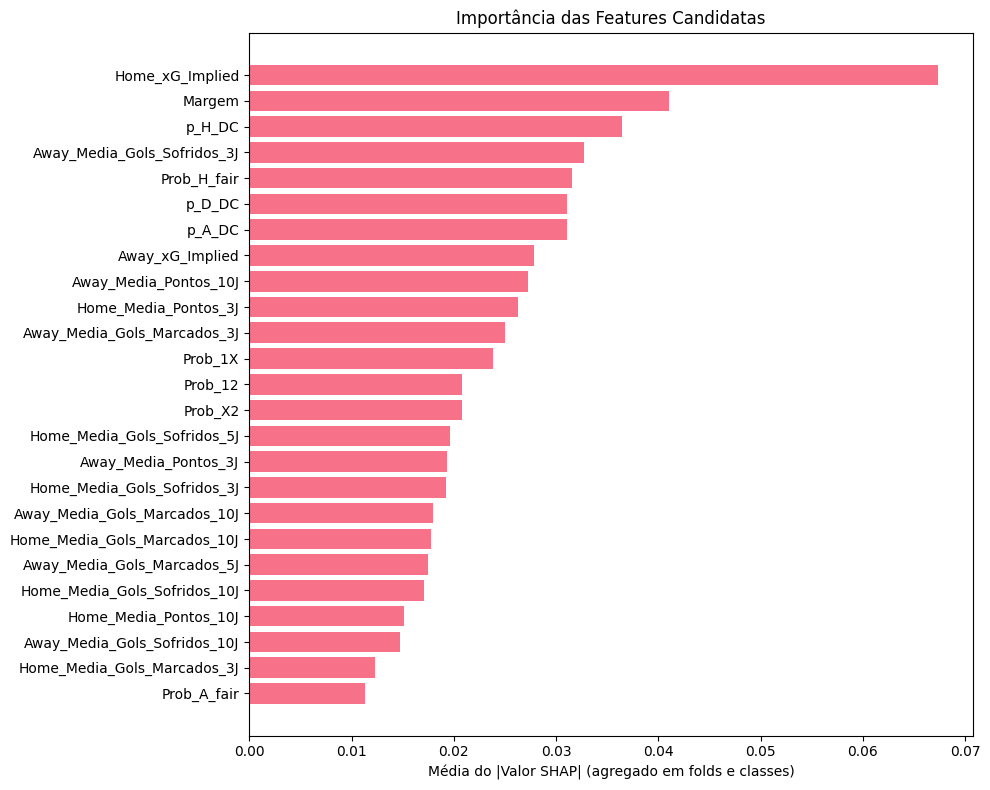


Gráfico Detalhado de SHAP (último fold):


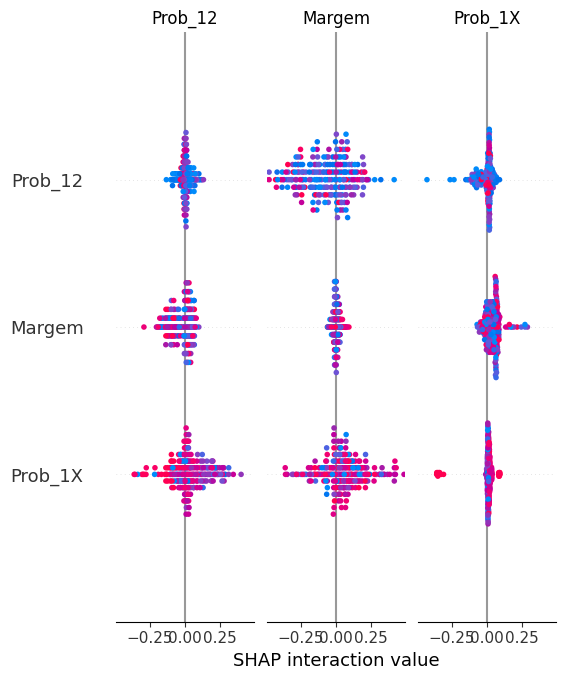

✅ Artefatos de seleção de features salvos na pasta 'artefatos_modelo'.

--- Iniciando Etapa 4: Treinamento do Stack (Walk-Forward) ---

🚀 Iniciando o treinamento do Stack (Walk-Forward) com 18 features selecionadas...

Treinando modelos base finais com os dados completos e features selecionadas...
✅ STACK1x2 pronto: | bases: ['NB', 'LGBM', 'MLP', 'CAT', 'XGB']
✅ α(odd) isotônico treinado: {'H': 61, 'D': 24, 'A': 56}


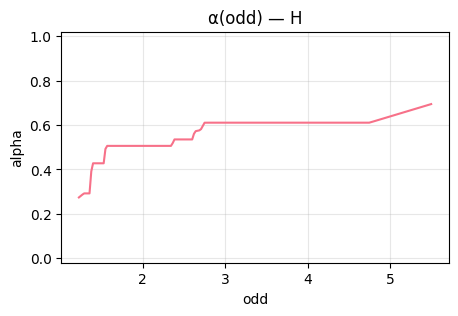

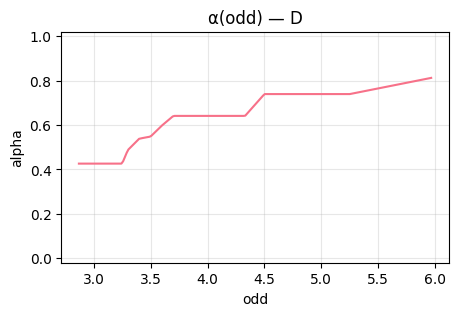

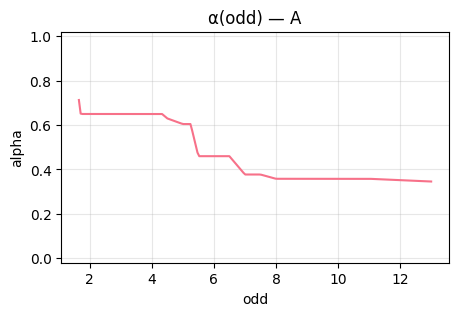


--- Iniciando Etapa 5: Avaliação de Performance ---


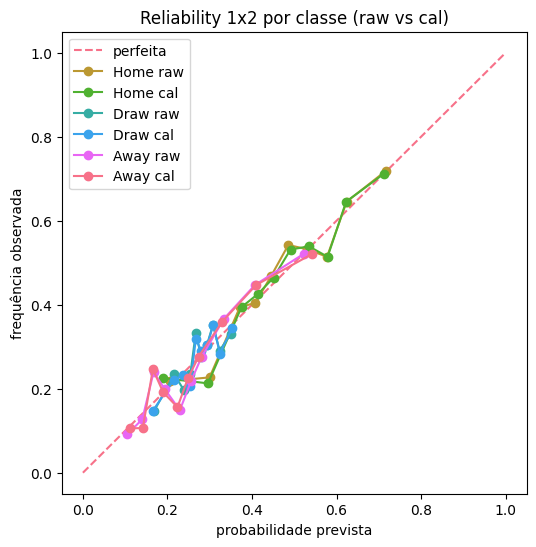

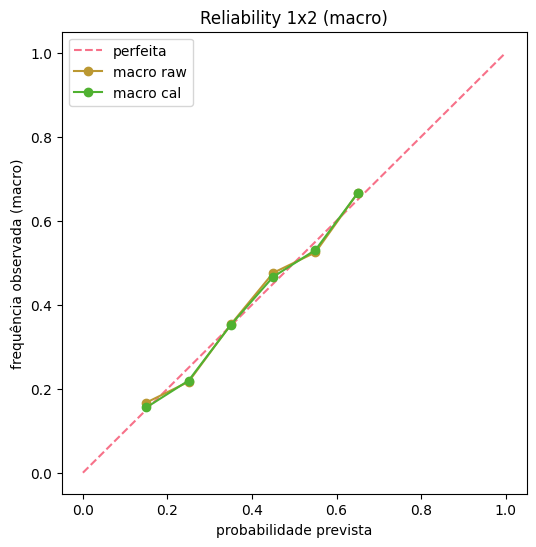


=== Skill vs. Mercado (Holdout 90d) — RAW ===
LogLoss(modelo):   0.8954
LogLoss(mercado):  0.9829
LogLoss(uniforme): 1.0986
LL skill vs unif:  18.50%  | CI95: 18.49% [11.96%, 24.81%]
LL gain vs mkt:    -0.0875 | CI95: -0.0876 [-0.1056, -0.0695]  (negativo = melhor)
Brier(modelo):     0.5300
Brier(mercado):    0.5884
Brier SkillScore:  9.93% | CI95: 9.97% [7.56%, 12.57%]

=== Skill vs. Mercado (Holdout 90d) — CAL ===
LogLoss(modelo):   0.8948
LogLoss(mercado):  0.9829
LogLoss(uniforme): 1.0986
LL skill vs unif:  18.55%  | CI95: 18.55% [11.92%, 24.93%]
LL gain vs mkt:    -0.0881 | CI95: -0.0883 [-0.1079, -0.0687]  (negativo = melhor)
Brier(modelo):     0.5286
Brier(mercado):    0.5884
Brier SkillScore:  10.17% | CI95: 10.22% [7.65%, 12.93%]

DESEMPENHO NO HOLDOUT (Jogos após 2025-07-18):
RAW: {'LogLoss': 0.8953942492494599, 'Brier': 0.5299713762294308}
CAL: {'LogLoss': 0.8947659976749173, 'Brier': 0.5285712497430144}
n_test: 145


In [ ]:
# =========================================================================================
# RUNNER FINAL: PREPARAÇÃO -> SELEÇÃO SHAP -> TREINO -> VALIDAÇÃO (VERSÃO ROBUSTA)
# =========================================================================================
def market_probs_from_odds(df: pd.DataFrame,
                           cols=('Odd_H_FT','Odd_D_FT','Odd_A_FT')) -> np.ndarray:
    probs = np.vstack([_devig_3way_shin_row(h,d,a)
                       for h,d,a in zip(df[cols[0]].astype(float).values,
                                        df[cols[1]].astype(float).values,
                                        df[cols[2]].astype(float).values)])
    probs = np.clip(probs, 1e-12, 1-1e-12)
    return probs / probs.sum(axis=1, keepdims=True)
# --- PASSO 0: CONFIGURAÇÕES E CHECAGENS DE INTEGRIDADE ---
np.random.seed(42)
random.seed(42)

COLUNA_DE_DATA = 'Date'

assert 'dados_historicos_com_momentum' in globals(), "A célula que cria as features de momentum precisa ser executada primeiro!"
assert 'dixon_coles_model' in globals(), "O modelo Dixon-Coles não foi treinado. Execute a célula de treino do DC."

dados_historicos_com_momentum = dados_historicos_com_momentum.sort_values(COLUNA_DE_DATA).reset_index(drop=True)
assert dados_historicos_com_momentum[COLUNA_DE_DATA].is_monotonic_increasing, "As datas no DataFrame histórico não estão em ordem crescente."

# --- PASSO 1: PREPARAÇÃO COMPLETA DO DATAFRAME COM TODAS AS FEATURES ---
print("--- Iniciando Etapa 1: Preparação completa do DataFrame ---")
dataframe_para_modelo = preparar_features_para_walk_forward(dados_historicos_com_momentum)
dataframe_para_modelo = garantir_target_1x2(dataframe_para_modelo)

print("\n🤖 Adicionando features do Dixon-Coles...")
probabilidades_dc = _dc_probs_1x2_em_lote(dataframe_para_modelo, dixon_coles_model)
probabilidades_dc_matrix = np.column_stack(probabilidades_dc)  # Shape: (n_jogos, 3)
dataframe_para_modelo[['p_H_DC', 'p_D_DC', 'p_A_DC']] = probabilidades_dc_matrix

# Verificação pós-correção (adicione para debug; remova após testar)
print(f"Shape de probabilidades_dc_matrix: {probabilidades_dc_matrix.shape}")
assert probabilidades_dc_matrix.shape[0] == len(dataframe_para_modelo), "Mismatch no número de linhas!"
assert np.allclose(probabilidades_dc_matrix.sum(axis=1), 1.0, atol=1e-5), "Probs não somam ~1 por linha!"

# --- Normalização de nomes de Over/Under antes do xG Implícito ---
# Aceita variações comuns e padroniza para Odd_Over25_FT / Odd_Under25_FT
ou_aliases = {
    'Odd_Over25': 'Odd_Over25_FT',
    'Odd_Under25': 'Odd_Under25_FT',
    'Odd_Over_FT': 'Odd_Over25_FT',
    'Odd_Under_FT': 'Odd_Under25_FT',
    'Over25': 'Odd_Over25_FT',
    'Under25': 'Odd_Under25_FT'
}
for antigo, novo in ou_aliases.items():
    if antigo in dataframe_para_modelo.columns and novo not in dataframe_para_modelo.columns:
        dataframe_para_modelo = dataframe_para_modelo.rename(columns={antigo: novo})

print("\n🧮 Adicionando features de xG Implícito do Mercado...")
# Passa explicitamente as colunas de odds usadas para bater com a etapa de previsão
dataframe_final_para_modelo = calcular_xg_implicito_v2(
    dataframe_para_modelo,
    line_overunder=2.5,
    odds_cols=('Odd_H_FT','Odd_D_FT','Odd_A_FT','Odd_Over25_FT','Odd_Under25_FT')
)

print("\n=== DATAFRAME COM TODAS AS FEATURES PRONTO ===")
print("📊 Shape final das features:", dataframe_final_para_modelo.shape)
assert dataframe_final_para_modelo['Resultado_1X2'].notna().all(), "A coluna alvo 'Resultado_1X2' possui valores nulos."

# --- PASSO 2: CRIAÇÃO DA LISTA MESTRA DE FEATURES PARA ANÁLISE ---
print("\n--- Iniciando Etapa 2: Criação da lista mestra de features ---")
LISTA_DE_FEATURES_BASE = [
    'Prob_H_Adj','Prob_D_Adj','Prob_A_Adj','Margem','Prob_1X','Prob_12','Prob_X2',
    'Prob_Over25','Prob_BTTS_Yes','Prob_H_fair','Prob_D_fair','Prob_A_fair',
    'Logit_H_fair','Logit_D_fair','Logit_A_fair',
    'p_H_DC','p_D_DC','p_A_DC',
    'Home_xG_Implied','Away_xG_Implied'
]
lista_de_features_momentum = [c for c in dataframe_final_para_modelo.columns if 'Media_' in c]
LISTA_DE_FEATURES_TOTAIS = [c for c in dict.fromkeys(LISTA_DE_FEATURES_BASE + lista_de_features_momentum)
                            if c in dataframe_final_para_modelo.columns]

# --- PASSO 3: SELEÇÃO DE FEATURES COM O SHAP HÍBRIDO E CONSISTENTE ---
print("\n--- Iniciando Etapa 3: Seleção de features com SHAP ---")
LISTA_DE_FEATURES_FINAL, dataframe_de_importancia = selecionar_features_com_shap_hibrido(
    dataframe_completo=dataframe_final_para_modelo,
    lista_features_total=LISTA_DE_FEATURES_TOTAIS,
    coluna_alvo=TARGET_1X2,
    k=15,
    obrigatorias=['Prob_H_Adj','Prob_D_Adj','Prob_A_Adj'],
    coluna_ordem_temporal=COLUNA_DE_DATA,
    n_splits=5,
    plotar=True,
    random_state=42
)

# Persistência de artefatos
os.makedirs("artefatos_modelo", exist_ok=True)
dataframe_de_importancia.to_csv("artefatos_modelo/importancia_features_shap.csv", index=False)
pd.Series(LISTA_DE_FEATURES_FINAL, name="features").to_csv("artefatos_modelo/lista_features_final.csv", index=False)
print("✅ Artefatos de seleção de features salvos na pasta 'artefatos_modelo'.")

# >>> Deixa disponível globalmente para a etapa de PREVISÃO <<<
STACK1x2_COLS = LISTA_DE_FEATURES_FINAL

# --- PASSO 4: TREINAMENTO DO STACK COM SPLITS CONSISTENTES ---
print("\n--- Iniciando Etapa 4: Treinamento do Stack (Walk-Forward) ---")
oof_pack_1x2 = treinar_stack_1x2_dirichlet(
    dataframe_com_features=dataframe_final_para_modelo,
    lista_de_features_selecionadas=LISTA_DE_FEATURES_FINAL,
    coluna_alvo=TARGET_1X2,
    numero_de_splits=5,
    coluna_ordem_temporal=COLUNA_DE_DATA
)

# --- α(odd) contínuo a partir do OOF ---
ALPHA_MODELS_1X2 = fit_alpha_curves_isotonic(
    oof_pack_1x2["P_raw_oof"],
    oof_pack_1x2["P_cal_oof"],
    dataframe_final_para_modelo,
    odds_cols=('Odd_H_FT','Odd_D_FT','Odd_A_FT'),
    n_bins_reduce=100   # opcional (0 = desliga)
)

def _plot_alpha_curve(ALPHA_MODELS, df, odds_cols=('Odd_H_FT','Odd_D_FT','Odd_A_FT'), n_pts=200):
    import matplotlib.pyplot as plt
    labs = ['H','D','A']
    odds = df[list(odds_cols)].astype(float).to_numpy()
    for k, lab in enumerate(labs):
        x = np.linspace(np.nanpercentile(odds[:,k], 1),
                        np.nanpercentile(odds[:,k], 99), n_pts)
        y = ALPHA_MODELS['models'][lab].predict(x)
        plt.figure(figsize=(5,3))
        plt.plot(x, y)
        plt.title(f"α(odd) — {lab}")
        plt.xlabel('odd'); plt.ylabel('alpha'); plt.ylim(-0.02,1.02)
        plt.grid(True, alpha=.3); plt.show()

_plot_alpha_curve(ALPHA_MODELS_1X2, dataframe_final_para_modelo)


# --- PASSO 5: AVALIAÇÃO FINAL COM HOLDOUT POR DATA ---
print("\n--- Iniciando Etapa 5: Avaliação de Performance ---")
plot_reliability_1x2(oof_pack_1x2, n_bins=10)

# Holdout = últimos 90 dias
data_max = pd.to_datetime(dataframe_final_para_modelo[COLUNA_DE_DATA]).max()
data_de_corte_holdout = data_max - pd.Timedelta(days=90)
mascara_holdout = (pd.to_datetime(dataframe_final_para_modelo[COLUNA_DE_DATA]) > data_de_corte_holdout)

res_hold = avaliar_holdout_1x2(
    df_feat=dataframe_final_para_modelo,
    features=LISTA_DE_FEATURES_FINAL,
    alvo_col=TARGET_1X2,
    holdout_mask=mascara_holdout,  # ou use holdout_frac=0.10
    title_suffix="Holdout 90d"
)

print(f"\nDESEMPENHO NO HOLDOUT (Jogos após {data_de_corte_holdout.date()}):")
print("RAW:", res_hold["raw"])
print("CAL:", res_hold["cal"])
print("n_test:", res_hold["n_test"])


In [ ]:
# ============================================================
# RELATÓRIO POR SEGMENTO (classe × bucket × liga × lado)
# ============================================================

def market_probs_from_odds(df: pd.DataFrame,
                           cols=('Odd_H_FT','Odd_D_FT','Odd_A_FT')) -> np.ndarray:
    probs = np.vstack([_devig_3way_shin_row(h,d,a)
                       for h,d,a in zip(df[cols[0]].astype(float).values,
                                        df[cols[1]].astype(float).values,
                                        df[cols[2]].astype(float).values)])
    probs = np.clip(probs, 1e-12, 1-1e-12)
    return probs / probs.sum(axis=1, keepdims=True)

def segment_report_1x2(
    df: pd.DataFrame,
    y: np.ndarray,
    P_model: np.ndarray,             # use P_cal_oof (ou P_cal_hold)
    buckets: list,
    *,
    odds_cols=('Odd_H_FT','Odd_D_FT','Odd_A_FT'),
    league_col: str = 'League',
    min_n_per_segment: int = 15,
    segment_by_league: bool = True
) -> pd.DataFrame:
    """Métricas por (classe × bucket × (liga) × lado). Usando máscara por comparação direta."""
    assert len(df) == len(y) == len(P_model), "Alinhamento OOF/Holdout com DF falhou."

    # 1D garantido
    y = np.asarray(y, dtype=int).ravel()
    P_model = np.asarray(P_model, dtype=float)
    K = P_model.shape[1]
    labels = list(range(K))

    odds = df.loc[:, list(odds_cols)].astype(float).to_numpy()
    if segment_by_league and (league_col in df.columns):
        leagues = df[league_col].astype(str).to_numpy().ravel()
    else:
        leagues = np.repeat('ALL', len(df))
        segment_by_league = False

    P_mkt = market_probs_from_odds(df, cols=odds_cols)

    rows = []
    classes = ['H','D','A']

    for k, cls in enumerate(classes):
        side = 'Home' if k == 0 else ('Away' if k == 2 else 'Neutral')
        odd_k = odds[:, k]
        odd_k = np.asarray(odd_k, float)

        for (lo, hi) in buckets:
            # máscara 1D robusta; também remove não-finitos
            mask_b = (odd_k >= lo) & (odd_k < hi) & np.isfinite(odd_k)
            idx_b = np.where(mask_b)[0]
            if idx_b.size == 0:
                continue

            if segment_by_league:
                leagues_b = leagues[idx_b]
                unique_leagues = np.unique(leagues_b)
            else:
                unique_leagues = np.array(['ALL'])

            for lg in unique_leagues:
                if segment_by_league:
                    idx_seg = idx_b[leagues_b == lg]
                else:
                    idx_seg = idx_b

                n_seg = idx_seg.size
                if n_seg < min_n_per_segment:
                    continue

                y_s  = y[idx_seg]
                Pm_s = P_model[idx_seg]
                Pk_s = P_mkt[idx_seg]

                LL_m = log_loss(y_s, Pm_s, labels=labels)
                LL_k = log_loss(y_s, Pk_s, labels=labels)

                Y_onehot = np.eye(K, dtype=float)[y_s]
                Br_m = float(np.mean(np.sum((Y_onehot - Pm_s)**2, axis=1)))
                Br_k = float(np.mean(np.sum((Y_onehot - Pk_s)**2, axis=1)))

                rows.append({
                    "class": cls,
                    "side": side,
                    "bucket": f"{lo:.2f}-{hi:.2f}",
                    "league": (lg if segment_by_league else 'ALL'),
                    "n": int(n_seg),
                    "LL_model": LL_m,
                    "LL_market": LL_k,
                    "LL_gain": LL_m - LL_k,     # NEGATIVO = melhor que mercado
                    "Brier_model": Br_m,
                    "Brier_market": Br_k,
                    "BSS": 1.0 - (Br_m / Br_k) # POSITIVO = melhor que mercado
                })

    cols = ["class","side","bucket","league","n",
            "LL_model","LL_market","LL_gain",
            "Brier_model","Brier_market","BSS"]
    rep = pd.DataFrame(rows, columns=cols)

    if rep.empty:
        print(f"⚠️ Nenhum segmento atingiu min_n_per_segment={min_n_per_segment}. "
              f"Tente reduzir ou usar segment_by_league=False.")
        return rep

    rep = rep.sort_values(["class","bucket","league"]).reset_index(drop=True)
    print("Top 15 segmentos (LL_gain mais negativo):")
    display(rep.sort_values("LL_gain").head(15))
    print("\nTop 15 segmentos (BSS mais alto):")
    display(rep.sort_values("BSS", ascending=False).head(15))
    return rep





# ===== Executar relatório com OOF calibrado =====
rep_oof = segment_report_1x2(
    dataframe_final_para_modelo,
    oof_pack_1x2["y"],
    oof_pack_1x2["P_cal_oof"],
    BUCKETS_1X2,
    odds_cols=('Odd_H_FT','Odd_D_FT','Odd_A_FT'),
    league_col='League',
    min_n_per_segment=3,
    segment_by_league=False   # <- como você só tem BRAZIL 1
)


print(dataframe_final_para_modelo[['League','Odd_H_FT','Odd_D_FT','Odd_A_FT']].head())
print(dataframe_final_para_modelo[['League']].nunique())

Top 15 segmentos (LL_gain mais negativo):


,class,side,bucket,league,n,LL_model,LL_market,LL_gain,Brier_model,Brier_market,BSS
0,A,Away,1.20-1.60,ALL,8,0.824189,1.182643,-0.358454,0.494980,0.701066,0.293962
1,A,Away,1.60-2.00,ALL,66,1.063275,1.174389,-0.111115,0.644085,0.718608,0.103706
11,H,Home,3.20-100.00,ALL,178,1.036753,1.117315,-0.080562,0.626653,0.678631,0.076592
5,D,Neutral,2.50-3.20,ALL,365,1.035255,1.094957,-0.059702,0.624685,0.664284,0.059612
10,H,Home,2.50-3.20,ALL,242,1.044709,1.102330,-0.057621,0.628909,0.669451,0.060560
3,A,Away,2.50-3.20,ALL,233,1.038668,1.095525,-0.056857,0.625316,0.664673,0.059211
2,A,Away,2.00-2.50,ALL,139,1.029945,1.085657,-0.055711,0.619503,0.658239,0.058847
7,H,Home,1.20-1.60,ALL,217,0.870139,0.919183,-0.049044,0.503719,0.532576,0.054182
6,D,Neutral,3.20-100.00,ALL,1050,0.985055,1.030635,-0.045579,0.587730,0.616720,0.047007
9,H,Home,2.00-2.50,ALL,333,1.017876,1.060097,-0.042221,0.611504,0.640601,0.045421



Top 15 segmentos (BSS mais alto):


,class,side,bucket,league,n,LL_model,LL_market,LL_gain,Brier_model,Brier_market,BSS
0,A,Away,1.20-1.60,ALL,8,0.824189,1.182643,-0.358454,0.494980,0.701066,0.293962
1,A,Away,1.60-2.00,ALL,66,1.063275,1.174389,-0.111115,0.644085,0.718608,0.103706
11,H,Home,3.20-100.00,ALL,178,1.036753,1.117315,-0.080562,0.626653,0.678631,0.076592
10,H,Home,2.50-3.20,ALL,242,1.044709,1.102330,-0.057621,0.628909,0.669451,0.060560
5,D,Neutral,2.50-3.20,ALL,365,1.035255,1.094957,-0.059702,0.624685,0.664284,0.059612
3,A,Away,2.50-3.20,ALL,233,1.038668,1.095525,-0.056857,0.625316,0.664673,0.059211
2,A,Away,2.00-2.50,ALL,139,1.029945,1.085657,-0.055711,0.619503,0.658239,0.058847
7,H,Home,1.20-1.60,ALL,217,0.870139,0.919183,-0.049044,0.503719,0.532576,0.054182
6,D,Neutral,3.20-100.00,ALL,1050,0.985055,1.030635,-0.045579,0.587730,0.616720,0.047007
9,H,Home,2.00-2.50,ALL,333,1.017876,1.060097,-0.042221,0.611504,0.640601,0.045421


     League  Odd_H_FT  Odd_D_FT  Odd_A_FT
0  BRAZIL 1      1.75       3.4      5.25
1  BRAZIL 1      3.75       3.4      2.05
2  BRAZIL 1      1.45       4.2      7.00
3  BRAZIL 1      1.90       3.2      4.50
4  BRAZIL 1      1.60       3.8      5.75
League    1
dtype: int64


In [ ]:
# ============================================================
# TUNING DE GATES POR SEGMENTO (classe × bucket)
# ============================================================
def _compute_ev_edge(P_model_row, P_mkt_row, odds_row, k):
    p = float(P_model_row[k]); pm = float(P_mkt_row[k]); odd = float(odds_row[k])
    EV   = p*odd - 1.0
    EDGE = p - pm
    return EV, EDGE, p, odd, pm

def tune_gates_by_segment(
    df: pd.DataFrame,
    y: np.ndarray,
    P_model: np.ndarray,                          # use P_cal_oof
    buckets: list,
    *,
    odds_cols=('Odd_H_FT','Odd_D_FT','Odd_A_FT'),
    grids=None,
    min_bets_per_segment=20,
    use_consensus=True
):
    """
    Para cada (classe × bucket), escolhe gates (MIN_EV, EDGE_MIN, ODD_MIN, ODD_MAX)
    que maximizam (-LL_gain vs mercado), depois EV médio, depois volume.
    """
    if grids is None:
        grids = {
            "MIN_EV":  [0.00,0.025, 0.02, 0.04, 0.06, 0.08],
            "EDGE_MIN":[0.00, 0.01, 0.02, 0.03, 0.05],
            "ODD_TIGHT": [0.00, 0.05, 0.10]
        }

    # 1D garantido
    y = np.asarray(y, int).ravel()
    print(f"DEBUG: Type of P_model before asarray: {type(P_model)}") # Added debug print
    P_model = np.asarray(P_model, float)
    print(f"DEBUG: P_model dtype after asarray: {P_model.dtype}") # Added debug print
    assert len(df) == len(y) == len(P_model), "Alinhamento OOF/Holdout com DF falhou."

    P_mkt = market_probs_from_odds(df, cols=odds_cols)
    odds  = df.loc[:, list(odds_cols)].astype(float).to_numpy()

    consenso_ok = (df["consenso_ok"].to_numpy(dtype=bool).ravel()
                   if (use_consensus and "consenso_ok" in df.columns)
                   else np.ones(len(df), dtype=bool))

    classes = ['H','D','A']
    out = {c:{} for c in classes}

    def _compute_ev_edge(P_model_row, P_mkt_row, odds_row, k):
        p = float(P_model_row[k]); pm = float(P_mkt_row[k]); odd = float(odds_row[k])
        EV   = p*odd - 1.0
        EDGE = p - pm
        return EV, EDGE, p, odd, pm

    for k, cls in enumerate(classes):
        odd_k = odds[:, k]
        odd_k = np.asarray(odd_k, float)

        for (lo, hi) in buckets:
            # máscara 1D robusta; também remove não-finitos
            mask_b = (odd_k >= lo) & (odd_k < hi) & np.isfinite(odd_k)
            idx = np.where(mask_b & consenso_ok)[0]
            if idx.size < min_bets_per_segment:
                continue

            y_s   = y[idx]
            Pm_s  = P_model[idx]
            Pk_s  = P_mkt[idx]
            odds_s= odds[idx]

            best = None  # (score_tuple, gates_dict, stats)

            for ev_min in grids["MIN_EV"]:
                for edge_min in grids["EDGE_MIN"]:
                    for tight in grids["ODD_TIGHT"]:
                        odd_min = lo + (hi - lo)*tight
                        odd_max = hi - (hi - lo)*tight

                        EVs = []
                        sel = []
                        for i in range(len(idx)):
                            EV, EDGE, p, odd, pm = _compute_ev_edge(Pm_s[i], Pk_s[i], odds_s[i], k)
                            ok = (EV >= ev_min) and (EDGE >= edge_min) and (odd_min <= odd <= odd_max)
                            sel.append(ok)
                            EVs.append(EV)
                        sel = np.array(sel, bool)
                        EVs = np.array(EVs, float)

                        n_bets = int(sel.sum())
                        if n_bets < min_bets_per_segment:
                            continue

                        y_bet   = y_s[sel]
                        Pm_bet  = Pm_s[sel]
                        Pk_bet  = Pk_s[sel]
                        EV_mean = float(np.mean(EVs[sel]))

                        LL_m   = log_loss(y_bet, Pm_bet, labels=list(range(3)))
                        LL_k   = log_loss(y_bet, Pk_bet, labels=list(range(3)))
                        LL_gain= LL_m - LL_k  # <0 melhor que mercado

                        # objetivo: 1) LL_gain mais negativo, 2) EV maior, 3) mais volume
                        score = ( -LL_gain, -EV_mean, -n_bets )

                        if (best is None) or (score < best[0]):
                            best = (score,
                                    {"MIN_EV":ev_min, "EDGE_MIN":edge_min,
                                     "ODD_MIN":odd_min, "ODD_MAX":odd_max},
                                    {"n_bets": n_bets, "LL_gain": LL_gain, "EV_mean": EV_mean})
            if best is not None:
                out[cls][(lo,hi)] = best[1] | best[2]
    return out

def build_GATES_BUCKETS_from_tuning(gates_tunados, buckets, defaults=None):
    if defaults is None:
        defaults = {"MIN_EV":EV_MIN_GLOBAL,"EDGE_MIN":0.00,"ODD_MIN":1.50,"ODD_MAX":100.0}
    out = {"H":{}, "D":{}, "A":{}}
    for cls in out:
        for b in buckets:
            gg = gates_tunados.get(cls, {}).get(b, None)
            out[cls][b] = (gg if gg is not None else defaults).copy()
    return out

# ===== Executar tuning de gates com OOF calibrado =====
print(f"DEBUG: Content of oof_pack_1x2: {oof_pack_1x2}")
print(f"DEBUG: Content of dataframe_final_para_modelo head: {dataframe_final_para_modelo.head()}")

gates_tunados = tune_gates_by_segment(
    dataframe_final_para_modelo,
    oof_pack_1x2["y"], # Use "y" from oof_pack_1x2
    oof_pack_1x2["P_cal_oof"], # Correctly use "P_cal_oof" for P_model
    BUCKETS_1X2,
    odds_cols=('Odd_H_FT','Odd_D_FT','Odd_A_FT'),
    grids=None,                    # pode customizar
    min_bets_per_segment=20,
    use_consensus=("consenso_ok" in dataframe_final_para_modelo.columns)
)

def sanitize_gates(
    gates_tunados: dict,
    *,
    min_bets: int = 50,              # volume padrão exigido
    max_ll_gain: float = -0.01,      # precisa superar mercado por > 0.01
    min_ev_floor: dict = {"H":EV_MIN_GLOBAL, "D":EV_MIN_GLOBAL, "A":EV_MIN_GLOBAL},  # pisos por classe
    edge_floor: float = 0.01,        # pelo menos 1pp acima do mercado
    # ---- exceção de edge forte com menos volume ----
    strong_gain: float = -0.04,      # se LL_gain <= -0.04
    min_bets_strong: int = 30,       # e n_bets >= 30
    ev_mean_floor: dict = {"H":0.05, "D":0.03, "A":0.05}  # exigir EV médio mínimo
):
    """
    Mantém bucket se:
      - (n_bets >= min_bets) e (LL_gain <= max_ll_gain) e (EV_mean >= ev_mean_floor), ou
      - EXCEÇÃO: (LL_gain <= strong_gain) e (n_bets >= min_bets_strong) e (EV_mean >= ev_mean_floor)
    Caso contrário, desliga o bucket.
    """
    cleaned = {"H":{}, "D":{}, "A":{}}
    dropped = []

    for cls in cleaned.keys():
        for b, g in gates_tunados.get(cls, {}).items():
            nb   = int(g.get("n_bets", 0))
            gain = float(g.get("LL_gain", 0.0)) # Corrigido: remova "LL_gain, 0"
            evm  = float(g.get("EV_mean", 0.0))

            keep_regular = (nb >= min_bets) and (gain <= max_ll_gain) and (evm >= ev_mean_floor.get(cls, 0.0))
            keep_strong  = (gain <= strong_gain) and (nb >= min_bets_strong) and (evm >= ev_mean_floor.get(cls, 0.0))

            if keep_regular or keep_strong:
                gg = g.copy()
                gg["MIN_EV"]   = max(gg.get("MIN_EV", 0.0), min_ev_floor.get(cls, 0.0))
                gg["EDGE_MIN"] = max(gg.get("EDGE_MIN", 0.0), edge_floor)
                cleaned[cls][b] = gg
            else:
                cleaned[cls][b] = {
                    "MIN_EV":  1.00,
                    "EDGE_MIN": 1.00,
                    "ODD_MIN":  1e9,
                    "ODD_MAX": -1e9,
                    "n_bets": nb,
                    "LL_gain": gain,
                    "EV_mean": evm,
                    "DISABLED": True
                }
                dropped.append((cls, b, nb, gain, evm))

    return cleaned, dropped

def count_pass_with_gates(df: pd.DataFrame,
                          P_model: np.ndarray,
                          gates: dict,
                          *,
                          odds_cols=('Odd_H_FT','Odd_D_FT','Odd_A_FT'),
                          mkt_cols=('MKT_H','MKT_D','MKT_A'),
                          use_consensus=True,
                          apply_kelly=True,
                          kelly_base=KELLY_BASE_GLOBAL,
                          drawdown=0.0,
                          dd_cap=0.30,
                          ent_weight=ENT_WEIGHT):
    """
    Conta quantos passes por classe aplicando:
      - gates por classe×bucket
      - consenso_ok (se existir e use_consensus=True)
      - Kelly adaptativo > 0 (se apply_kelly=True)
    """
    odds = df.loc[:, list(odds_cols)].astype(float).to_numpy()
    Pm   = np.asarray(P_model, float)

    if all(c in df.columns for c in mkt_cols):
        Pk = df.loc[:, list(mkt_cols)].astype(float).to_numpy()
    else:
        Pk = market_probs_from_odds(df, cols=odds_cols)

    if use_consensus and ("consenso_ok" in df.columns):
        cons = df["consenso_ok"].to_numpy(bool).ravel()
    else:
        cons = np.ones(len(df), dtype=bool)

    tags = ['H','D','A']
    passed = {t:0 for t in tags}
    total  = len(df)

    for i in range(total):
        for k, t in enumerate(tags):
            odd = float(odds[i,k]); p = float(Pm[i,k]); pm = float(Pk[i,k])
            EV = p*odd - 1.0; EDGE = p - pm

            # bucket do odd
            b = None
            for lo,hi in BUCKETS_1X2:
                if lo <= odd < hi:
                    b = (lo,hi); break
            if b is None: b = BUCKETS_1X2[-1]

            # Corrigido: Use get com default correto
            g = gates.get(t, {}).get(b, {"MIN_EV":EV_MIN_GLOBAL,"EDGE_MIN":0.00,"ODD_MIN":1.50,"ODD_MAX":100.0})
            pass_gate = (EV >= g["MIN_EV"]) and (EDGE >= g["EDGE_MIN"]) and (g["ODD_MIN"] <= odd <= g["ODD_MAX"])

            if use_consensus:
                pass_gate = pass_gate and bool(cons[i])

            if apply_kelly and pass_gate:
                # entropia normalizada 0..1
                Prow = np.clip(Pm[i], 1e-12, 1-1e-12)
                H = -np.sum(Prow*np.log(Prow)) / np.log(3.0)
                frac = kelly_adaptativo(p, odd, kelly_base=kelly_base,
                                        drawdown=drawdown, dd_cap=dd_cap,
                                        entropy01=float(H), ent_weight=ENT_WEIGHT)
                pass_gate = pass_gate and (frac > 0)

            if pass_gate:
                passed[t] += 1

    return {"total": total, **passed}

# 1) higieniza com regra de edge forte
cleaned_gates, dropped = sanitize_gates(
    gates_tunados,
    min_bets=50, max_ll_gain=-0.01,
    min_ev_floor={"H":0.02,"D":0.02,"A":0.03},
    edge_floor=0.01,
    strong_gain=-0.04, min_bets_strong=30,
    ev_mean_floor={"H":0.05,"D":0.03,"A":0.05}
)
print("Buckets desabilitados (classe, bucket, n_bets, LL_gain, EV_mean):")
for it in dropped: print("  ", it)

GATES_BUCKETS = build_GATES_BUCKETS_from_tuning(cleaned_gates, BUCKETS_1X2)

# 2) volume “realista” aplicando consenso e Kelly
counts = count_pass_with_gates(
    dataframe_final_para_modelo,
    oof_pack_1x2["P_cal_oof"],
    GATES_BUCKETS,
    odds_cols=('Odd_H_FT','Odd_D_FT','Odd_A_FT'),
    use_consensus=True,
    apply_kelly=True,
    kelly_base=KELLY_BASE_GLOBAL, drawdown=0.0, dd_cap=0.30, ent_weight=ENT_WEIGHT
)
print("Passam nos gates (OOF, com consenso & Kelly>0):", counts)

DEBUG: Content of oof_pack_1x2: {'P_raw_oof': array([[0.45545909, 0.29451756, 0.25002335],
       [0.39385847, 0.32084628, 0.28529525],
       [0.51807703, 0.24891745, 0.23300552],
       ...,
       [0.62877132, 0.24739015, 0.12383852],
       [0.48080752, 0.24624592, 0.27294656],
       [0.34029884, 0.2550705 , 0.40463066]]), 'P_cal_oof': array([[0.46320161, 0.29378815, 0.24301025],
       [0.40120323, 0.32118708, 0.2776097 ],
       [0.52595805, 0.24564004, 0.22840192],
       ...,
       [0.62117686, 0.25286357, 0.12595957],
       [0.48824393, 0.24372135, 0.26803472],
       [0.33530277, 0.25772999, 0.40696724]]), 'y': array([1, 1, 2, ..., 0, 0, 0])}
DEBUG: Content of dataframe_final_para_modelo head:          Id       Date   Time    League Season    Round         Home  \
0  phbhGYqc 2022-04-09  16:30  BRAZIL 1   2022  ROUND 1   Fluminense   
1  YHWu7U6q 2022-04-09  19:00  BRAZIL 1   2022  ROUND 1  Atletico GO   
2  67n1ECE9 2022-04-09  21:00  BRAZIL 1   2022  ROUND 1    Palmeiras

In [ ]:
# ==========================================
# SISTEMA APOSTAS 1x2 (prever_1x2 + aplicar_kelly_1x2)
# ==========================================
#ver quantos jogos geram aposta
def count_games_with_bet(df, P_model, gates, *,
                         odds_cols=('Odd_H_FT','Odd_D_FT','Odd_A_FT'),
                         mkt_cols=('MKT_H','MKT_D','MKT_A'),
                         use_consensus=True,
                         kelly_base=KELLY_BASE_GLOBAL, drawdown=0.0, dd_cap=0.30, ent_weight=ENT_WEIGHT):
    import numpy as np
    odds = df.loc[:, list(odds_cols)].astype(float).to_numpy()
    Pm   = np.asarray(P_model, float)
    if all(c in df.columns for c in mkt_cols):
        Pk = df.loc[:, list(mkt_cols)].astype(float).to_numpy()
    else:
        Pk = market_probs_from_odds(df, cols=odds_cols)
    cons = df["consenso_ok"].to_numpy(bool).ravel() if (use_consensus and "consenso_ok" in df.columns) else np.ones(len(df), bool)

    def entropy01(p):
        p = np.clip(np.asarray(p,float), 1e-12, 1-1e-12); return float(-(p*np.log(p)).sum()/np.log(3))
    def kelly(p, odd, *, kb=0.25, dd=0.0, dd_cap=0.30, ent01=0.5, ent_w=0.35):
        q=1-p; b=odd-1.0;
        if b<=0: return 0.0
        f = max(0.0, (b*p - q)/b)
        ent_shrink = max(0.0, 1.0 - ent_w*ent01)
        dd_shrink  = max(0.0, 1.0 - min(max(dd,0.0), dd_cap)/dd_cap)
        return kb * f * ent_shrink * dd_shrink

    tags = ['H','D','A']; buckets = [(1.20,1.60),(1.60,2.00),(2.00,2.50),(2.50,3.20),(3.20,100.0)]
    n_games, n_bets = len(df), 0
    for i in range(len(df)):
        if use_consensus and not cons[i]:
            continue
        cands = []
        for k,t in enumerate(tags):
            odd = float(odds[i,k]); p=float(Pm[i,k]); pm=float(Pk[i,k])
            EV = p*odd - 1.0; EDGE = p - pm
            # bucket do odd
            b = next((bb for bb in buckets if bb[0] <= odd < bb[1]), buckets[-1])
            g = gates.get(t, {}).get(b, {"MIN_EV":EV_MIN_GLOBAL,"EDGE_MIN":0.00,"ODD_MIN":1.50,"ODD_MAX":100.0})
            pass_gate = (EV >= g["MIN_EV"]) and (EDGE >= g["EDGE_MIN"]) and (g["ODD_MIN"] <= odd <= g["ODD_MAX"])
            if not pass_gate:
                continue
            frac = kelly(p, odd, kb=kelly_base, dd=0.0, dd_cap=dd_cap, ent01=entropy01(Pm[i]), ent_w=ent_weight)
            if frac > 0:
                cands.append((EV, t))
        if cands:
            # 1 aposta por jogo: escolhe maior EV
            n_bets += 1
    return {"games": n_games, "bets_one_per_game": n_bets}

games_count = count_games_with_bet(
    dataframe_final_para_modelo,
    oof_pack_1x2["P_cal_oof"],
    GATES_BUCKETS,
    odds_cols=('Odd_H_FT','Odd_D_FT','Odd_A_FT'),
    use_consensus=True,
    kelly_base=KELLY_BASE_GLOBAL, drawdown=0.0, dd_cap=0.30, ent_weight=ENT_WEIGHT
)
print("Jogos vs apostas (OOF):", games_count)


Jogos vs apostas (OOF): {'games': 1415, 'bets_one_per_game': 536}


In [ ]:
# =================================================================================
# CLASSE DO SISTEMA APOSTAS (VERSÃO ATUALIZADA c/ per-base + outcome p/ AUDIT)
# =================================================================================

class SistemaApostas1x2:
    def __init__(self,
                 *,
                 consenso_std: float = CONSENSO_STD_GLOBAL,
                 consenso_min_models: int = 4):
        # Pega objetos globais treinados
        assert 'STACK1x2_META' in globals() and 'STACK1x2_CAL' in globals(), "Treine o stack 1x2 antes."
        assert 'STACK1x2_SCALER' in globals() and 'BASES_1x2' in globals(), "Bases/Scaler não encontrados."

        self.meta   = globals()['STACK1x2_META']
        self.cal    = globals()['STACK1x2_CAL']
        self.scaler = globals()['STACK1x2_SCALER']
        self.bases  = globals()['BASES_1x2']

        # lista de features usada no dia (falls back p/ lista ampla)
        self.cols   = globals().get('STACK1x2_COLS', globals().get('LISTA_DE_FEATURES_TUDO', []))

        self.consenso_std = float(consenso_std)
        self.consenso_min_models = int(consenso_min_models)

    def prever_1x2(self, df_dia: pd.DataFrame) -> pd.DataFrame:
        """
        Previsão multiclasse 1X2 para jogos do dia, com:
          - garantia de xG implícito (se houver O/U),
          - meta (stack) + calibração,
          - blend por α classe-a-classe (isotônico/bucket),
          - previsões por modelo-base (para AUDIT),
          - consenso robusto ponderado e 'shrink' do DC quando for outlier,
          - colunas auxiliares para auditoria.

        Pré-requisitos globais:
          - STACK1x2_META, STACK1x2_CAL, STACK1x2_SCALER, BASES_1x2
          - STACK1x2_COLS (ou LISTA_DE_FEATURES_TUDO)
          - (opcional) dixon_coles_model + _dc_probs_1x2_em_lote
          - (opcional) CFG_CONSENSO_DEFAULT  (limiares/pesos do DC)
          - helper _weighted_std_row(values, weights)

        Retorna um DataFrame com:
          - P_H/P_D/P_A (blend final), p_consenso_H/D/A (se consenso disponível),
          - MKT_H/MKT_D/MKT_A (devig),
          - alpha_H/alpha_D/alpha_A usados,
          - outcome_model (argmax do blend), voto_consenso,
          - p_std (desvio ponderado entre bases) e flags de consenso,
          - colunas P_*_BASE e voto_BASE para cada base, e P_*_DC/voto_DC (se DC disponível),
          - coluna 'jogo' (Home vs Away) para joins.
        """
        # -------------------- 0) Preparos e saneamento --------------------
        df = df_dia.copy().reset_index(drop=True)
        assert all(c in df.columns for c in ["Home","Away","Odd_H_FT","Odd_D_FT","Odd_A_FT"]), \
            "Faltam colunas básicas (Home/Away/odds)."

        # Garante 'jogo' (útil para joins)
        if "jogo" not in df.columns:
            df["jogo"] = df["Home"].astype(str) + " vs " + df["Away"].astype(str)

        # -------------------- 1) Garantir xG implícito --------------------
        need_xg = any(c not in df.columns for c in ("Home_xG_Implied","Away_xG_Implied"))
        have_ou = any(c in df.columns for c in ("Odd_Over25_FT","Odd_Under25_FT","Odd_Over_FT","Odd_Under_FT","Odd_Over25","Odd_Under25"))
        if need_xg and have_ou:
            # normaliza aliases de O/U
            ou_aliases = {
                'Odd_Over25': 'Odd_Over25_FT',
                'Odd_Under25': 'Odd_Under25_FT',
                'Odd_Over_FT': 'Odd_Over25_FT',
                'Odd_Under_FT': 'Odd_Under25_FT',
                'Over25': 'Odd_Over25_FT',
                'Under25': 'Odd_Under25_FT'
            }
            for velho, novo in ou_aliases.items():
                if velho in df.columns and novo not in df.columns:
                    df = df.rename(columns={velho: novo})
            try:
                df = calcular_xg_implicito_v2(
                    df,
                    2.5,
                    ('Odd_H_FT','Odd_D_FT','Odd_A_FT','Odd_Over25_FT','Odd_Under25_FT')
                )
            except Exception as e:
                print(f"⚠️ Erro ao calcular xG implícito: {e} — usando 0.0.")
                for c in ("Home_xG_Implied","Away_xG_Implied"):
                    if c not in df.columns:
                        df[c] = 0.0
        else:
            for c in ("Home_xG_Implied","Away_xG_Implied"):
                if c not in df.columns:
                    df[c] = 0.0

        # -------------------- 2) Monta features e P_mkt -------------------
        Z, P_mkt = montar_Z_1x2(df)  # P_mkt: probs de mercado devigadas (H,D,A)

        # -------------------- 3) Meta (stack) e calibração ----------------
        try:
            P_raw = np.clip(self.meta.predict_proba(Z), 1e-9, 1-1e-9)
            assert P_raw.shape[1] == 3, "Probs não em 3 classes."
        except Exception as e:
            print(f"⚠️ Erro em predict_proba do meta: {e} — fallback probs uniformes.")
            P_raw = np.full((len(df), 3), 1/3)

        P_cal = np.clip(self.cal.transform(P_raw), 1e-9, 1-1e-9) if self.cal is not None else P_raw

        # -------------------- 4) Blend por α classe-a-classe --------------
        odds = df[["Odd_H_FT","Odd_D_FT","Odd_A_FT"]].astype(float).values
        ALPHA_M = globals().get("ALPHA_MODELS_1X2", None)   # isotônico por classe (se treinado)
        ALPHA_B = globals().get("ALPHA_BUCKETS_1X2", None)  # fallback por buckets

        P_final = np.zeros_like(P_raw)
        aH_list, aD_list, aA_list = [], [], []
        for i in range(len(df)):
            if ALPHA_M is not None:
                aH, aD, aA = predict_alpha_isotonic(odds[i], ALPHA_M)
            elif ALPHA_B is not None:
                BUCKS = globals().get("BUCKETS_1X2",
                         [(1.20,1.60),(1.60,2.00),(2.00,2.50),(2.50,3.20),(3.20,100.0)])
                bH = next((b for b in BUCKS if b[0] <= odds[i,0] < b[1]), BUCKS[-1])
                bD = next((b for b in BUCKS if b[0] <= odds[i,1] < b[1]), BUCKS[-1])
                bA = next((b for b in BUCKS if b[0] <= odds[i,2] < b[1]), BUCKS[-1])
                aH = ALPHA_B.get("H", {}).get(bH, 0.75)
                aD = ALPHA_B.get("D", {}).get(bD, 0.75)
                aA = ALPHA_B.get("A", {}).get(bA, 0.75)
            else:
                aH, aD, aA = 0.80, 0.70, 0.70

            Pf = np.empty(3, float)
            Pf[0] = aH*P_cal[i,0] + (1-aH)*P_raw[i,0]
            Pf[1] = aD*P_cal[i,1] + (1-aD)*P_raw[i,1]
            Pf[2] = aA*P_cal[i,2] + (1-aA)*P_raw[i,2]
            s = Pf.sum(); Pf = (Pf/s) if s>0 else np.array([1/3,1/3,1/3])

            P_final[i,:] = Pf
            aH_list.append(float(aH)); aD_list.append(float(aD)); aA_list.append(float(aA))

        # -------------------- 5) Previsões por modelo-base ----------------
        out = df.copy()
        tags = np.array(['H','D','A'])

        # features escaladas p/ bases
        if not self.cols:
            raise ValueError("STACK1x2_COLS não definido. Rode o treino.")
        Xb = out[self.cols].replace([np.inf, -np.inf], np.nan).fillna(0.0).to_numpy(copy=False)
        Xb = self.scaler.transform(Xb)

        base_probs, base_names = [], []
        for nome, mdl in self.bases.items():
            try:
                Pm = np.clip(mdl.predict_proba(Xb), 1e-9, 1-1e-9)
                out[f"P_H_{nome}"] = Pm[:,0]
                out[f"P_D_{nome}"] = Pm[:,1]
                out[f"P_A_{nome}"] = Pm[:,2]
                out[f"voto_{nome}"] = tags[Pm.argmax(axis=1)]
                base_probs.append(Pm); base_names.append(nome)
            except Exception as e:
                print(f"⚠️ Erro ao prever com base {nome}: {e}")

        # Dixon-Coles como mais uma "base" (opcional)
        if 'dixon_coles_model' in globals():
            try:
                p_h_dc, p_d_dc, p_a_dc = _dc_probs_1x2_em_lote(out, globals().get("dixon_coles_model"))
                Pdc = np.clip(np.column_stack([p_h_dc, p_d_dc, p_a_dc]), 1e-9, 1-1e-9)
                out["P_H_DC"], out["P_D_DC"], out["P_A_DC"] = Pdc[:,0], Pdc[:,1], Pdc[:,2]
                out["voto_DC"] = tags[Pdc.argmax(axis=1)]
                base_probs.append(Pdc); base_names.append("DC")
            except Exception as e:
                print(f"⚠️ DC indisponível para o dia: {e}")

        # -------------------- 6) Consenso ponderado robusto ----------------
        cfgc = globals().get("CFG_CONSENSO_DEFAULT", {})
        min_models = int(cfgc.get("min_models", 3))

        if len(base_probs) >= min_models:
            # parâmetros do robustificador
            tukey_c   = float(cfgc.get("tukey_c", 1.0))
            w_anchor0 = float(cfgc.get("w_anchor", 1.5))
            power_sft = float(cfgc.get("consenso_power", 0.90))
            cap_lo    = float(cfgc.get("cap_lo", 0.06))
            cap_hi    = float(cfgc.get("cap_hi", 0.85))
            max_wr    = float(cfgc.get("max_weight_ratio", 3.0))

            # shrink/weight especial do DC (reaproveita sua lógica existente)
            idx_dc = base_names.index("DC") if "DC" in base_names else -1
            t_hi = float(cfgc.get("dc_shrink_thresh_hi", 0.30))
            t_lo = float(cfgc.get("dc_shrink_thresh_lo", 0.15))
            a_hi = float(cfgc.get("dc_alpha_hi", 0.30))
            a_lo = float(cfgc.get("dc_alpha_lo", 0.60))
            w_hi = float(cfgc.get("dc_weight_hi", 0.20))
            w_lo = float(cfgc.get("dc_weight_lo", 0.50))

            cons_H, cons_D, cons_A, pstd_list = [], [], [], []

            # confiança por base
            trust = {nm: float(globals().get("TRUST_SCORES_1X2", {}).get(nm, 1.0)) for nm in base_names}

            for i in range(len(out)):
                # 6.1) define âncora (estável)
                # média das MLs (sem DC) se existirem; senão usa P_final
                ml_idx = [j for j,nm in enumerate(base_names) if nm != "DC"]
                if ml_idx:
                    P_ml_mean = np.mean([base_probs[j][i, :] for j in ml_idx], axis=0)
                else:
                    P_ml_mean = P_final[i, :]

                P_anchor = 0.5 * (P_ml_mean + P_mkt[i, :])   # âncora = média ML + mercado
                P_anchor = np.clip(P_anchor, 1e-6, 1-1e-6)
                P_anchor /= P_anchor.sum()

                # 6.2) shrink do DC se outlier vs âncora/mercado/ML
                w_vec = np.ones(len(base_names), float)
                # aplica trust por base (se disponível)
                if "TRUST_SCORES_1X2" in globals():
                    for j, nome_base in enumerate(base_names):
                        w_vec[j] *= float(TRUST_SCORES_1X2.get(nome_base, 1.0))

                if idx_dc >= 0:
                    P_dc = base_probs[idx_dc][i, :]
                    g = float(max(
                        np.max(np.abs(P_dc - P_anchor)),
                        np.max(np.abs(P_dc - P_mkt[i, :])),
                        np.max(np.abs(P_dc - P_ml_mean))
                    ))
                    if g > t_hi:
                        alpha_dc, w_dc = a_hi, w_hi
                    elif g > t_lo:
                        alpha_dc, w_dc = a_lo, w_lo
                    else:
                        alpha_dc, w_dc = 0.90, 1.00

                    P_dc_shrunk = alpha_dc * P_dc + (1.0 - alpha_dc) * P_anchor
                    P_dc_shrunk = np.clip(P_dc_shrunk, 1e-6, 1-1e-6)
                    P_dc_shrunk /= P_dc_shrunk.sum()
                    base_probs[idx_dc][i, :] = P_dc_shrunk
                    w_vec[idx_dc] = w_dc

                # 6.3) pesos robustos por “distância” à âncora (em logit)
                z_anchor = _logit_clip(P_anchor)
                z_models = [_logit_clip(base_probs[j][i, :]) for j in range(len(base_names))]

                w_robust = []
                for j, z_m in enumerate(z_models):
                    # desvio escalar = norma L2 das diferenças de logit nas 3 classes
                    d = float(np.linalg.norm(z_m - z_anchor, ord=2))
                    wj = _tukey_weight(d, tukey_c)             # [0,1]
                    wj *= trust.get(base_names[j], 1.0)        # confiança por base
                    wj *= w_vec[j]                              # inclui peso DC ajustado
                    w_robust.append(wj)

                w_robust = np.asarray(w_robust, float)
                # evita um modelo dominar
                if w_robust.sum() > 0:
                    mx = w_robust.max()
                    w_robust = np.minimum(w_robust, max_wr * (w_robust.sum() - mx + 1e-9))

                # 6.4) mistura com âncora (âncora tem peso fixo w_anchor0)
                cols = np.array([bp[i, :] for bp in base_probs])   # (n_models,3)
                num = (cols * w_robust[:, None]).sum(axis=0) + w_anchor0 * P_anchor
                den = w_robust.sum() + w_anchor0
                p_cons = num / max(den, 1e-9)

                # 6.5) power smoothing e clamp
                p_cons = _dirichlet_power(p_cons, power_sft).clip(cap_lo, cap_hi)
                p_cons /= p_cons.sum()

                cons_H.append(float(p_cons[0]))
                cons_D.append(float(p_cons[1]))
                cons_A.append(float(p_cons[2]))

                # desvio ponderado (para debug/uso do w no Kelly)
                stds = []
                for k in range(3):
                    dif = cols[:,k] - p_cons[k]
                    w  = w_robust / max(w_robust.sum(), 1e-9)
                    stds.append(float(np.sqrt(np.sum(w * dif*dif))))
                pstd_list.append(max(stds))

            out["p_consenso_H"] = cons_H
            out["p_consenso_D"] = cons_D
            out["p_consenso_A"] = cons_A
            out["p_std"] = pstd_list
            out["consenso_ok"] = (out["p_std"] <= self.consenso_std) & (len(base_names) >= min_models)
            out["consenso_base"] = f"bases_{'_'.join(base_names)}_robust"
            out["voto_consenso"] = np.array(['H','D','A'])[out[["p_consenso_H","p_consenso_D","p_consenso_A"]].to_numpy().argmax(axis=1)]
        else:
            out["p_std"] = np.inf
            out["consenso_ok"] = False
            out["consenso_base"] = "consenso_fallback"
            out["voto_consenso"] = np.nan



        # -------------------- 7) Saídas principais / AUDIT ----------------
        out[["P_H","P_D","P_A"]]       = P_final
        out[["MKT_H","MKT_D","MKT_A"]] = P_mkt
        out["alpha_H"] = aH_list
        out["alpha_D"] = aD_list
        out["alpha_A"] = aA_list

        # outcomes p/ AUDIT
        out["outcome_model"] = tags[P_final.argmax(axis=1)]  # lado do blend final
        # voto_consenso já foi criado (se consenso disponível)

        return out



    def aplicar_kelly_1x2(self, dataframe_previsoes: pd.DataFrame, *, banca_inicial: float) -> pd.DataFrame:


        # ----------------- helpers locais (auto-contidos) -----------------
        def _fmt_brl(v):
            try:
                return f"R$ {float(v):,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")
            except Exception:
                return f"R$ {v}"

        def _sanitize_df_cols(df: pd.DataFrame) -> pd.DataFrame:
            df = df.copy()
            df.columns = [str(c).strip() for c in df.columns]
            if "jogo" not in df.columns and {"Home","Away"} <= set(df.columns):
                df["jogo"] = df["Home"].astype(str) + " vs " + df["Away"].astype(str)
            return df

        def _compute_outcome_model(df: pd.DataFrame) -> pd.Series:
            tags = np.array(["H","D","A"])
            if all(c in df.columns for c in ("P_H","P_D","P_A")):
                arr = df[["P_H","P_D","P_A"]].to_numpy()
            elif all(c in df.columns for c in ("p_consenso_H","p_consenso_D","p_consenso_A")):
                arr = df[["p_consenso_H","p_consenso_D","p_consenso_A"]].to_numpy()
            else:
                arr = np.full((len(df), 3), 1/3.0)
            om = tags[arr.argmax(axis=1)]
            om = np.where(om == "X", "D", om)
            return pd.Series(om, index=df.index, name="outcome_model")

        def _ensure_game_id(df: pd.DataFrame) -> pd.DataFrame:
            df = df.copy()
            if "game_id" in df.columns:
                return df
            bases = [c for c in ["League","Date","Home","Away"] if c in df.columns]
            if bases:
                key = df[bases].astype(str).agg("|".join, axis=1)
                gid = pd.util.hash_pandas_object(key, index=False).astype("int64").astype(str)
            else:
                gid = (df.reset_index().index + 1).astype(str)
            df["game_id"] = gid
            dups = df["game_id"].duplicated(keep=False)
            if dups.any():
                df.loc[dups, "game_id"] = df.loc[dups, "game_id"] + "_" + df.loc[dups].reset_index().index.astype(str)
            return df

        def _cast_odds_float(df: pd.DataFrame, cols=("Odd_H_FT","Odd_D_FT","Odd_A_FT")) -> pd.DataFrame:
            df = df.copy()
            for c in cols:
                if c in df.columns:
                    df[c] = pd.to_numeric(df[c], errors="coerce")
            return df

        # --------------- 1) Base + consenso + IDs estáveis -----------------
        df_base = _sanitize_df_cols(dataframe_previsoes.copy())
        df_base = df_base.drop(columns=[c for c in df_base.columns if c.strip()=="outcome_model"], errors="ignore")
        df_base = df_base.assign(outcome_model=_compute_outcome_model(df_base))

        cfg_consenso = globals().get("CFG_CONSENSO_DEFAULT", {})
        try:
            df_work = aplicar_filtro_consenso(df_base, cfg_consenso)
        except Exception as e:
            print(f"⚠️ aplicar_filtro_consenso falhou ({e}) — usando DF base.")
            df_work = df_base.copy()

        # IDs e tipos de odds garantidos
        df_base = _ensure_game_id(_cast_odds_float(_sanitize_df_cols(df_base)))
        df_work = _ensure_game_id(_cast_odds_float(_sanitize_df_cols(df_work)))

        # outcome_model sempre recalculado depois de filtros
        df_work = df_work.drop(columns=[c for c in df_work.columns if c.strip()=="outcome_model"], errors="ignore")
        df_work = df_work.assign(outcome_model=_compute_outcome_model(df_work))

        # --------------- 2) Escolha de fonte de prob -----------------------
        cfg_kelly   = globals().get("CFG_KELLY_DEFAULT", {})
        prob_source = str(cfg_kelly.get("prob_source", "consenso")).lower()
        if prob_source == "final" or not all(c in df_work.columns for c in ["p_consenso_H","p_consenso_D","p_consenso_A"]):
            cols_prob = ("P_H","P_D","P_A")
        elif prob_source == "consenso":
            cols_prob = ("p_consenso_H","p_consenso_D","p_consenso_A")
        else:
            cols_prob = ("P_H","P_D","P_A")  # 'mean' será tratado dentro do motor se necessário
        cols_odds = ("Odd_H_FT","Odd_D_FT","Odd_A_FT")

        # --------------- 3) Motor 1x2 (com game_id) ------------------------
        def _motor_1x2(df_in: pd.DataFrame, *, per_outcome: bool) -> pd.DataFrame:
            """
            Constrói a tabela longa H/D/A com EV + Kelly e, se per_outcome=False,
            escolhe 1 pick por jogo. NÃO depende de 'outcome_model' em nenhum ponto.

            Patches incluídos:
              (A) Blend dinâmico entre consenso e P_* final (caps, peso por p_std/consenso_ok).
              (B) Veto duro: DC e Mercado concordam contra o Consenso e consenso_ok=False → zera peso.
              (C) edge_mkt calculado na longa.
              (D) EV/edge recalculados no retorno final a partir de p_escolhido/odd_escolhido.
              (E) EV_H_all/EV_D_all/EV_A_all calculados direto do dfM com P_*_USED e odds (merge por game_id + jogo).
            """
            # ===== 0) Preparos =====
            dfM = df_in.drop(columns=['outcome_model'], errors='ignore').copy()
            dfM.columns = [str(c).strip() for c in dfM.columns]

            # garante 'jogo'
            if "jogo" not in dfM.columns and {"Home","Away"} <= set(dfM.columns):
                dfM["jogo"] = dfM["Home"].astype(str) + " vs " + dfM["Away"].astype(str)
            assert "jogo" in dfM.columns, "Faltou coluna 'jogo' (Home/Away)."

            # garante game_id (aplicar_kelly_1x2 já faz, mas reforçamos)
            if "game_id" not in dfM.columns:
                bases = [c for c in ["League","Date","Home","Away"] if c in dfM.columns]
                if bases:
                    key = dfM[bases].astype(str).agg("|".join, axis=1)
                    gid = pd.util.hash_pandas_object(key, index=False).astype("int64").astype(str)
                else:
                    gid = (dfM.reset_index().index + 1).astype(str)
                dfM["game_id"] = gid

            # dropa duplicados (evita “colagem” de jogos)
            if dfM["jogo"].duplicated().any():
                dfM = dfM.drop_duplicates(subset=["jogo"], keep="last").copy()

            # odds & nomes de colunas (vêm do escopo de aplicar_kelly_1x2)
            oH_col, oX_col, oA_col = cols_odds
            assert all(c in dfM.columns for c in [oH_col, oX_col, oA_col]), "Faltam colunas de odds."

            # ===== 1) Probabilidades de mercado devigadas (se precisar) =====
            if not {"p_mkt_H","p_mkt_D","p_mkt_A"} <= set(dfM.columns):
                pH_mkt, pD_mkt, pA_mkt = [], [], []
                for _, r in dfM[[oH_col, oX_col, oA_col]].astype(float).iterrows():
                    fh, fx, fa = devig_3way(r[oH_col], r[oX_col], r[oA_col])
                    pH_mkt.append(fh); pD_mkt.append(fx); pA_mkt.append(fa)
                dfM["p_mkt_H"], dfM["p_mkt_D"], dfM["p_mkt_A"] = pH_mkt, pD_mkt, pA_mkt

            # ===== 2) Blend dinâmico de probabilidades (consenso vs P_*) =====
            # Configs
            use_consenso  = (str(cfg_kelly.get("prob_source", "consenso")).lower() == "consenso")
            cap_lo        = float(cfg_kelly.get("consenso_cap_lo", 0.08))
            cap_hi        = float(cfg_kelly.get("consenso_cap_hi", 0.80))
            pstd_soft_k   = float(cfg_kelly.get("pstd_soft_k", 0.35))  # “comprimento” do desacordo

            # cap do consenso (evita extremos) + normalização posterior via P_*_USED
            for c in ("p_consenso_H","p_consenso_D","p_consenso_A"):
                if c in dfM.columns:
                    dfM[c] = dfM[c].astype(float).clip(cap_lo, cap_hi)

            # peso base a partir de p_std (numérico)
            if "p_std" in dfM.columns:
                w = 1.0 - np.clip(dfM["p_std"].astype(float) / pstd_soft_k, 0.0, 1.0)
            else:
                w = pd.Series(1.0, index=dfM.index, dtype=float)

            # consenso_ok como 0/1 numérico (evita broadcast estranho)
            if "consenso_ok" in dfM.columns:
                w = w * dfM["consenso_ok"].astype(float)

            # (PATCH B) Veto duro: DC e Mercado concordam contra Consenso e consenso_ok=False → zera peso
            if {"P_H_DC","P_D_DC","P_A_DC"} <= set(dfM.columns) and \
              {"p_consenso_H","p_consenso_D","p_consenso_A"} <= set(dfM.columns):
                argmax_dc = dfM[["P_H_DC","P_D_DC","P_A_DC"]].to_numpy().argmax(axis=1)
                argmax_mk = dfM[["p_mkt_H","p_mkt_D","p_mkt_A"]].to_numpy().argmax(axis=1)
                argmax_cs = dfM[["p_consenso_H","p_consenso_D","p_consenso_A"]].to_numpy().argmax(axis=1)
                hard_conflict = (argmax_dc == argmax_mk) & (argmax_cs != argmax_dc)
                if "consenso_ok" in dfM.columns:
                    hard_conflict &= (~dfM["consenso_ok"].astype(bool)).to_numpy()
                w.loc[hard_conflict] = 0.0

            # base do modelo (P_*)
            have_P  = {"P_H","P_D","P_A"} <= set(dfM.columns)
            have_CS = {"p_consenso_H","p_consenso_D","p_consenso_A"} <= set(dfM.columns)

            # constrói P_*_USED (blend)
            for cls, pc, pc_cons in [
                ("H", "P_H", "p_consenso_H"),
                ("D", "P_D", "p_consenso_D"),
                ("A", "P_A", "p_consenso_A"),
            ]:
                if use_consenso and have_CS and pc_cons in dfM.columns:
                    if have_P and pc in dfM.columns:
                        dfM[f"P_{cls}_USED"] = np.clip(
                            w.values * dfM[pc_cons].astype(float) + (1.0 - w.values) * dfM[pc].astype(float),
                            1e-9, 1-1e-9
                        )
                    else:
                        dfM[f"P_{cls}_USED"] = dfM[pc_cons].astype(float).clip(1e-9, 1-1e-9)
                else:
                    # usa modelo final
                    src = pc if (have_P and pc in dfM.columns) else pc_cons
                    assert src in dfM.columns, "Nem P_* nem consenso disponíveis para montar P_*_USED."
                    dfM[f"P_{cls}_USED"] = dfM[src].astype(float).clip(1e-9, 1-1e-9)

            # normaliza linha a linha
            s_used = dfM[["P_H_USED","P_D_USED","P_A_USED"]].sum(axis=1).replace(0, np.nan)
            dfM["P_H_USED"] /= s_used; dfM["P_D_USED"] /= s_used; dfM["P_A_USED"] /= s_used
            p_H_col, p_D_col, p_A_col = "P_H_USED","P_D_USED","P_A_USED"

            # ===== 3) Monta a tabela longa (H/D/A) e calcula EV/Kelly via aplicar_kelly_ev =====
            rows = []
            for side, pcol, ocol, pmcol in [
                ("H", p_H_col, oH_col, "p_mkt_H"),
                ("D", p_D_col, oX_col, "p_mkt_D"),
                ("A", p_A_col, oA_col, "p_mkt_A"),
            ]:
                tmp = dfM.copy()
                tmp["outcome"] = side
                # colunas temporárias para o motor binário
                p_tmp, o_tmp = f"__prob_{side}__", f"__odd_{side}__"
                tmp[p_tmp] = tmp[pcol].astype(float).clip(1e-8, 1-1e-8)
                tmp[o_tmp] = tmp[ocol].astype(float).clip(1.01, None)

                res = aplicar_kelly_ev(
                    tmp,
                    coluna_probabilidade=p_tmp,
                    coluna_odds=o_tmp,
                    banca_inicial=banca_inicial,
                    configuracao=None  # defaults do aplicar_kelly_ev
                )

                saida = pd.DataFrame({
                    "game_id": tmp["game_id"],
                    "jogo": tmp["jogo"],
                    "Home": tmp.get("Home", None),
                    "Away": tmp.get("Away", None),
                    "outcome": side,
                    "p": tmp[p_tmp].to_numpy(),
                    "odd": tmp[o_tmp].to_numpy(),
                    "p_mkt": tmp[pmcol].to_numpy(),
                    # do motor binário:
                    "EV": res["EV"].to_numpy(),
                    "kelly_full": res["kelly_pleno"].to_numpy(),
                    "stake_frac_final": res["fracao_final_kelly"].to_numpy(),
                    "stake_sugerido": res["valor_sugerido"].to_numpy(),
                    "valor_apostar": res["valor_apostar"].to_numpy(),
                    "valor_apostar_fmt": res["valor_apostar_formatado"].to_numpy(),
                    "pct_banca": res["percentual_banca"].to_numpy(),
                    "apostar?": res["apostar?"].to_numpy(),
                })

                # indicadores de consenso (se existirem)
                for c in ("Date","p_std","consenso_ok"):
                    if c in tmp.columns and c not in saida.columns:
                        saida[c] = tmp[c].values

                # (PATCH C) edge_mkt útil na longa também
                saida["edge_mkt"] = saida["p"].astype(float) - saida["p_mkt"].astype(float)

                rows.append(saida)

            long_df = pd.concat(rows, ignore_index=True)

            # ===== 4) Penalização adicional de Kelly por desacordo (p_std) =====
            round_dec = int(cfg_kelly.get("round_dec", 4))
            if "p_std" in dfM.columns:
                penal = np.clip(1.0 - dfM["p_std"].astype(float) / float(cfg_kelly.get("pstd_kelly_k", 0.40)),
                                0.20, 1.00)
                penal_rep = np.repeat(penal.values, 3)  # repetir por outcome
                long_df["stake_frac_final"] = np.round(long_df["stake_frac_final"].astype(float) * penal_rep, round_dec)
                long_df["stake_sugerido"]   = np.round(long_df["stake_frac_final"].astype(float) * float(banca_inicial), round_dec)
                long_df["valor_apostar"]    = long_df["stake_sugerido"].astype(float)
                long_df["pct_banca"]        = np.round(long_df["valor_apostar"].astype(float) / float(banca_inicial), round_dec)

            # ===== 5) Saídas =====
            if per_outcome:
                cols = [c for c in [
                    "game_id","jogo","Home","Away","Date","outcome","p","odd","p_mkt","EV",
                    "kelly_full","stake_frac_final","stake_sugerido","valor_apostar","valor_apostar_fmt",
                    "pct_banca","apostar?","edge_mkt","p_std","consenso_ok"
                ] if c in long_df.columns]
                return long_df[cols].sort_values(["jogo","outcome"]).reset_index(drop=True)

            # escolhe 1 por jogo
            aprov = long_df[long_df["apostar?"]].copy()
            if aprov.empty:
                # melhor EV por jogo
                idx = long_df.groupby("jogo")["EV"].idxmax()
                best_any = long_df.loc[idx].copy()
                best_any["apostar?"] = False
                # renomeia colunas finais
                best_any = best_any.rename(columns={
                    "outcome":"outcome_escolhido","odd":"odd_escolhido",
                    "p":"p_escolhido","p_mkt":"p_mkt_escolhido"
                })
                # (PATCH D) EV/edge recalculados a partir de p_escolhido/odd_escolhido
                best_any["EV"]       = best_any["p_escolhido"].astype(float) * best_any["odd_escolhido"].astype(float) - 1.0
                best_any["edge_mkt"] = best_any["p_escolhido"].astype(float) - best_any["p_mkt_escolhido"].astype(float)
                return best_any.sort_values("jogo").reset_index(drop=True)

            # com aprovadas: escolhe por EV
            idx = aprov.groupby("jogo")["EV"].idxmax()
            best = aprov.loc[idx].copy()
            best = best.rename(columns={
                "outcome":"outcome_escolhido","odd":"odd_escolhido",
                "p":"p_escolhido","p_mkt":"p_mkt_escolhido"
            })

            # (PATCH E) EV_H/D/A para auditoria — robusto direto do dfM (sem pivot da longa)
            ev_by_game = dfM[["game_id", "jogo", oH_col, oX_col, oA_col,
                              "P_H_USED", "P_D_USED", "P_A_USED"]].copy()

            ev_by_game["EV_H_all"] = (
                ev_by_game["P_H_USED"].astype(float) * ev_by_game[oH_col].astype(float) - 1.0
            )
            ev_by_game["EV_D_all"] = (
                ev_by_game["P_D_USED"].astype(float) * ev_by_game[oX_col].astype(float) - 1.0
            )
            ev_by_game["EV_A_all"] = (
                ev_by_game["P_A_USED"].astype(float) * ev_by_game[oA_col].astype(float) - 1.0
            )

            ev_by_game = ev_by_game[["game_id", "jogo", "EV_H_all", "EV_D_all", "EV_A_all"]]

            # junta nos 'best' pela chave estável
            best = best.merge(ev_by_game, on=["game_id", "jogo"], how="left")

            # (PATCH D) EV/edge recalculados (consistência total)
            best["EV"]       = best["p_escolhido"].astype(float) * best["odd_escolhido"].astype(float) - 1.0
            best["edge_mkt"] = best["p_escolhido"].astype(float) - best["p_mkt_escolhido"].astype(float)

            # arredonda EV_*_all se desejar
            try:
                best[["EV_H_all","EV_D_all","EV_A_all"]] = best[["EV_H_all","EV_D_all","EV_A_all"]].round(round_dec)
            except Exception:
                pass

            out_cols = [c for c in [
                "game_id","jogo","Home","Away","Date",
                "outcome_escolhido","odd_escolhido","p_escolhido","p_mkt_escolhido",
                "EV","apostar?","edge_mkt",
                "kelly_full","stake_frac_final","stake_sugerido","valor_apostar",
                "valor_apostar_fmt","pct_banca",
                "EV_H_all","EV_D_all","EV_A_all"
            ] if c in best.columns]
            return best[out_cols].sort_values("jogo").reset_index(drop=True)







        # executa o motor
        tabela_longa = _motor_1x2(df_work, per_outcome=True)
        melhores     = _motor_1x2(df_work, per_outcome=False)
        if melhores.empty:
            return tabela_longa

        # -------- 4) Injeta linha do lado do modelo (auditoria) por game_id --------
        base_model = df_work[["game_id"]].assign(outcome_model=_compute_outcome_model(df_work).values)
        tabela_longa = tabela_longa.merge(base_model, on="game_id", how="left")
        linhas_modelo = tabela_longa[tabela_longa["outcome"] == tabela_longa["outcome_model"]].copy()

        rename_map = {
            "outcome":"outcome_model_pick",
            "odd":"odd_model",
            "p":"p_model",
            "p_mkt":"p_mkt_model",
            "EV":"EV_model",
            "kelly_full":"kelly_full_model",
            "stake_frac_final":"stake_frac_final_model",
            "stake_sugerido":"stake_sugerido_model",
            "valor_apostar":"valor_apostar_model",
            "valor_apostar_fmt":"valor_apostar_fmt_model",
            "pct_banca":"pct_banca_model",
            "apostar?":"apostar_model",
        }
        if not linhas_modelo.empty:
            linhas_modelo = linhas_modelo.rename(columns=rename_map)
            melhores = melhores.merge(
                linhas_modelo[["game_id"] + list(rename_map.values())],
                on="game_id", how="left"
            )
        else:
            for k in rename_map.values():
                if k not in melhores.columns:
                    melhores[k] = np.nan
            for k in ["kelly_full_model","stake_frac_final_model","stake_sugerido_model",
                      "valor_apostar_model","pct_banca_model"]:
                melhores[k] = melhores[k].fillna(0.0)
            if "valor_apostar_fmt_model" not in melhores.columns:
                melhores["valor_apostar_fmt_model"] = _fmt_brl(0.0)
            if "apostar_model" not in melhores.columns:
                melhores["apostar_model"] = False

        # -------- 5) Trava para "virar" para o lado do modelo se diferença pequena ----
        ev_switch_margin = float(cfg_kelly.get("ev_switch_margin", 0.03))
        outcome_escolhido = melhores.get("outcome_escolhido")
        outcome_model_col = melhores.get("outcome_model_pick")  # veio da linhas_modelo renomeada
        ev_model = melhores.get("EV_model")

        melhores["nota_virada"] = ""
        if outcome_escolhido is not None and outcome_model_col is not None and ev_model is not None:
            cond_flip = (
                outcome_escolhido.notna() &
                outcome_model_col.notna() &
                (outcome_escolhido != outcome_model_col) &
                ev_model.notna() &
                ((melhores.get("EV") - ev_model) < ev_switch_margin)
            )
            if hasattr(cond_flip, "any") and cond_flip.any():
                overwrite = {
                    "outcome_escolhido":"outcome_model_pick",
                    "odd_escolhido":"odd_model",
                    "p_escolhido":"p_model",
                    "p_mkt_escolhido":"p_mkt_model",
                    "EV":"EV_model",
                    "kelly_full":"kelly_full_model",
                    "stake_frac_final":"stake_frac_final_model",
                    "stake_sugerido":"stake_sugerido_model",
                    "valor_apostar":"valor_apostar_model",
                    "valor_apostar_fmt":"valor_apostar_fmt_model",
                    "pct_banca":"pct_banca_model",
                    "apostar?":"apostar_model",
                }
                for left, right in overwrite.items():
                    melhores.loc[cond_flip, left] = melhores.loc[cond_flip, right]
                melhores.loc[cond_flip, "nota_virada"] = "forced_to_model (ΔEV < margin)"

        return melhores

In [ ]:
# =================================================================================
# REVISÃO DO DIA + KELLY (1 decisão por jogo) — versão robusta
# =================================================================================

# Garantias
assert 'jogos_do_dia_com_momentum' in globals(), "Execute a célula de preparação dos dados do dia!"
assert 'dixon_coles_model' in globals(), "Treine o modelo Dixon-Coles antes!"

# --- PASSO 1: PREPARAR DATAFRAME BASE PARA PREVISÃO ---
dataframe_para_previsao = jogos_do_dia_com_momentum.copy()

# normaliza colunas básicas/odds
mapa_de_nomes = {
    'Liga':'League','Casa':'Home','Fora':'Away',
    'Odd_Casa':'Odd_H_FT','Odd_Empate':'Odd_D_FT','Odd_Fora':'Odd_A_FT',
    'Odd_H':'Odd_H_FT','Odd_D':'Odd_D_FT','Odd_A':'Odd_A_FT',
    'Odd_1':'Odd_H_FT','Odd_X':'Odd_D_FT','Odd_2':'Odd_A_FT'
}
for velho, novo in mapa_de_nomes.items():
    if velho in dataframe_para_previsao.columns and novo not in dataframe_para_previsao.columns:
        dataframe_para_previsao = dataframe_para_previsao.rename(columns={velho: novo})

# cria features básicas
dataframe_pronto_para_previsao = criar_features_basicas(dataframe_para_previsao)

# --- PASSO 1.5: DIXON-COLES ---
print("\n🤖 Adicionando features do Dixon-Coles aos jogos do dia...")
probabilidades_dc_dia = _dc_probs_1x2_em_lote(dataframe_pronto_para_previsao, dixon_coles_model)
print(f"DEBUG: Shape de probabilidades_dc_dia: {np.asarray(probabilidades_dc_dia).shape}")
print(f"DEBUG: Length of dataframe_pronto_para_previsao: {len(dataframe_pronto_para_previsao)}")

# --- Correção: Stackar as probabilidades DC em uma matriz (n_jogos, 3) antes de atribuir ---
probabilidades_dc_matrix = np.column_stack(probabilidades_dc_dia)
dataframe_pronto_para_previsao[['p_H_DC', 'p_D_DC', 'p_A_DC']] = probabilidades_dc_matrix

# --- PASSO 1.6: xG Implícito do Mercado ---
print("\n🧮 Adicionando xG Implícito do Mercado aos jogos do dia...")

# normaliza nomes O/U -> *_FT
ou_aliases = {
    'Odd_Over25': 'Odd_Over25_FT',
    'Odd_Under25': 'Odd_Under25_FT',
    'Odd_Over_FT': 'Odd_Over25_FT',
    'Odd_Under_FT': 'Odd_Under25_FT',
    'Over25': 'Odd_Over25_FT',
    'Under25': 'Odd_Under25_FT'
}
for velho, novo in ou_aliases.items():
    if velho in dataframe_pronto_para_previsao.columns and novo not in dataframe_pronto_para_previsao.columns:
        dataframe_pronto_para_previsao = dataframe_pronto_para_previsao.rename(columns={velho: novo})

# chama a v2 (ou a atual por posicionais)
try:
    dataframe_pronto_para_previsao = calcular_xg_implicito_v2(
        dataframe_pronto_para_previsao,
        2.5,
        ('Odd_H_FT','Odd_D_FT','Odd_A_FT','Odd_Over25_FT','Odd_Under25_FT')
    )
except NameError:
    dataframe_pronto_para_previsao = calcular_xg_implicito(
        dataframe_pronto_para_previsao,
        2.5,
        ('Odd_H_FT','Odd_D_FT','Odd_A_FT','Odd_Over25_FT','Odd_Under25_FT')
    )

# se ainda faltar, cria fallback (não deve faltar)
for c in ('Home_xG_Implied','Away_xG_Implied'):
    if c not in dataframe_pronto_para_previsao.columns:
        dataframe_pronto_para_previsao[c] = 0.0

print("\n✅ DataFrame para previsão pronto, com odds, momentum, DC e xG implícito.")

# --- PASSO 2: PREVISÃO + KELLY ---
# garanta que as features do treino foram expostas
if 'STACK1x2_COLS' not in globals() and 'LISTA_DE_FEATURES_FINAL' in globals():
    STACK1x2_COLS = LISTA_DE_FEATURES_FINAL

sistema_de_apostas = SistemaApostas1x2(consenso_std=CONSENSO_STD_GLOBAL, consenso_min_models=3)
dcfg_consenso = globals().get("CFG_CONSENSO_DEFAULT", {})
# Assign the result back to dataframe_com_previsoes
dataframe_com_previsoes = sistema_de_apostas.prever_1x2(dataframe_pronto_para_previsao)
#print(dataframe_com_previsoes.columns.tolist())

# Adicionar coluna 'jogo' para a função aplicar_kelly_1x2
# This should already be in dataframe_com_previsoes from prever_1x2, but added here as a safeguard
if 'jogo' not in dataframe_com_previsoes.columns:
    dataframe_com_previsoes['jogo'] = dataframe_com_previsoes['Home'] + ' vs ' + dataframe_com_previsoes['Away']


# coluna alpha_bucket (se você usa em prints)
if "alpha_bucket" not in dataframe_com_previsoes.columns:
    dataframe_com_previsoes["alpha_bucket"] = dataframe_com_previsoes["alpha_H"] if "alpha_H" in dataframe_com_previsoes.columns else 0.75

banca_inicial = globals().get("BANCA_INICIAL", 100.0) # Assume banca_inicial is defined elsewhere


# Use the updated dataframe_com_previsoes directly
sugestoes = sistema_de_apostas.aplicar_kelly_1x2(dataframe_com_previsoes, banca_inicial=banca_inicial)
display(sugestoes)




=== CRIANDO FEATURES PARA MACHINE LEARNING ===
📊 Detectados dados históricos (FT)
✅ Features criadas. Shape: (1, 86)

🤖 Adicionando features do Dixon-Coles aos jogos do dia...
DEBUG: Shape de probabilidades_dc_dia: (3, 1)
DEBUG: Length of dataframe_pronto_para_previsao: 1

🧮 Adicionando xG Implícito do Mercado aos jogos do dia...

✅ DataFrame para previsão pronto, com odds, momentum, DC e xG implícito.


,game_id,jogo,Home,Away,outcome_escolhido,odd_escolhido,p_escolhido,p_mkt_escolhido,EV,apostar?,edge_mkt,kelly_full,stake_frac_final,stake_sugerido,valor_apostar,valor_apostar_fmt,pct_banca,EV_H_all,EV_D_all,EV_A_all,outcome_model_pick,odd_model,p_model,p_mkt_model,EV_model,kelly_full_model,stake_frac_final_model,stake_sugerido_model,valor_apostar_model,valor_apostar_fmt_model,pct_banca_model,apostar_model,nota_virada
0,7088173191713082601,Bahia vs Internacional,Bahia,Internacional,H,1.91,0.59508,0.499283,0.136602,True,0.095797,0.0555,0.0333,3.33,3.33,"R$ 3,33",0.0333,0.1366,-0.2267,-0.2315,H,1.91,0.59508,0.499283,0.1366,0.0555,0.0333,3.33,3.33,"R$ 3,33",0.0333,True,


In [ ]:
# --- PASSO 3: AUDITORIA E SUGESTÕES ---
print("\n🧾 AUDIT — Jogos do dia (P_H/P_D/P_A, MKT e alpha por bucket)")
'''
#simplificada
colunas_de_auditoria = [
    "League","Home","Away","Odd_H_FT","Odd_D_FT","Odd_A_FT",
    "P_H","P_D","P_A","MKT_H","MKT_D","MKT_A",
    "alpha_H","alpha_D","alpha_A",
    "outcome_model","voto_consenso","p_std","consenso_ok",
    "voto_NB",
    "voto_LGBM",
    "voto_MLP",
    "voto_CAT",
    "voto_XGB",
    # se estiver usando DC:
    "voto_DC",
]
'''
#completa
colunas_de_auditoria = [
    "League","Home","Away","Odd_H_FT","Odd_D_FT","Odd_A_FT",
    "P_H","P_D","P_A",           # blend final
    "p_consenso_H","p_consenso_D","p_consenso_A",  # média das bases
    "MKT_H","MKT_D","MKT_A",
    "alpha_H","alpha_D","alpha_A",
    "outcome_model","voto_consenso","p_std","consenso_ok",
    # probs + votos por base (ajuste nomes às suas bases reais)
    "P_H_NB","P_D_NB","P_A_NB","voto_NB",
    "P_H_LGBM","P_D_LGBM","P_A_LGBM","voto_LGBM",
    "P_H_MLP","P_D_MLP","P_A_MLP","voto_MLP",
    "P_H_CAT","P_D_CAT","P_A_CAT","voto_CAT",
    "P_H_XGB","P_D_XGB","P_A_XGB","voto_XGB",
    # se tiver DC:
    "P_H_DC","P_D_DC","P_A_DC","voto_DC",
]


colunas_de_auditoria = [coluna for coluna in colunas_de_auditoria if coluna in dataframe_com_previsoes.columns]
display(dataframe_com_previsoes[colunas_de_auditoria])
#dataframe_com_previsoes.columns.tolist()


🧾 AUDIT — Jogos do dia (P_H/P_D/P_A, MKT e alpha por bucket)


,League,Home,Away,Odd_H_FT,Odd_D_FT,Odd_A_FT,P_H,P_D,P_A,p_consenso_H,p_consenso_D,p_consenso_A,MKT_H,MKT_D,MKT_A,alpha_H,alpha_D,alpha_A,outcome_model,voto_consenso,p_std,consenso_ok,P_H_NB,P_D_NB,P_A_NB,voto_NB,P_H_LGBM,P_D_LGBM,P_A_LGBM,voto_LGBM,P_H_MLP,P_D_MLP,P_A_MLP,voto_MLP,P_H_CAT,P_D_CAT,P_A_CAT,voto_CAT,P_H_XGB,P_D_XGB,P_A_XGB,voto_XGB,P_H_DC,P_D_DC,P_A_DC,voto_DC
0,BRAZIL 1,Bahia,Internacional,1.91,3.4,4.33,0.570583,0.246424,0.182993,0.59508,0.227434,0.177486,0.499283,0.280479,0.220238,0.506034,0.538462,0.649662,H,H,0.101143,True,0.670698,0.29777,0.031532,H,0.881116,0.050075,0.068809,H,0.452538,0.272514,0.274948,H,0.751712,0.119992,0.128296,H,0.990083,0.001425,0.008492,H,0.28065,0.246693,0.472657,A


### 1. Probabilidades do Mercado (`MKT_H`, `MKT_D`, `MKT_A`)

Estas colunas representam a visão do mercado de apostas, ou seja, a "opinião da multidão".

* **`MKT_H` (Market Home)**
    * **O que é?** É a probabilidade "justa" da vitória do time da **Casa**, calculada a partir das odds depois de remover a margem de lucro da casa de apostas.
    * **Para que serve?** É o seu ponto de referência. O sistema compara a probabilidade que o *seu modelo* calculou (`P_H`) com a do mercado (`MKT_H`). A diferença entre elas (`P_H - MKT_H`) é o que gera o **"Edge"** (a vantagem). Se o seu modelo acha que a chance é de 55% (`P_H = 0.55`) e o mercado acha que é 50% (`MKT_H = 0.50`), você tem um Edge positivo de 5%.

* **`MKT_D` (Market Draw)**
    * **O que é?** A mesma coisa, mas para o **Empate**.

* **`MKT_A` (Market Away)**
    * **O que é?** A mesma coisa, mas para a vitória do time **Fora**.

---

### 2. Parâmetros de Mistura (`alpha_H`, `alpha_D`, `alpha_A`)

Essas colunas controlam a "receita" da sua probabilidade final, misturando duas versões da previsão do seu modelo.

* **`alpha_H` (Alpha Home)**
    * **O que é?** É um fator de ponderação (entre 0 e 1) usado para misturar a probabilidade **bruta** (`P_raw`) com a probabilidade **calibrada** (`P_cal`) para o resultado "Casa". A sua probabilidade final é calculada assim: `P_final = alpha * P_cal + (1 - alpha) * P_raw`.
    * **Para que serve?** É um ajuste fino. Seu código inteligentemente define um `alpha` diferente para cada faixa de odd, pois descobriu (na fase de tuning) que para certas odds, uma mistura específica funciona melhor do que usar apenas a probabilidade 100% calibrada. Um `alpha_H` de `0.75` significa que a previsão final para a vitória da casa usou 75% da versão calibrada e 25% da versão bruta.

* **`alpha_D` (Alpha Draw)**
    * **O que é?** O mesmo fator de mistura, mas aplicado à probabilidade de **Empate**.

* **`alpha_A` (Alpha Away)**
    * **O que é?** O mesmo fator de mistura, mas aplicado à probabilidade de vitória do time **Fora**.

---

### 3. Métricas de Consenso do Modelo (`p_std`, `consenso_ok`, `consenso_base`)

Estas colunas medem o grau de **acordo** entre os diferentes modelos que compõem o seu sistema. Elas funcionam como um importante controle de risco.

* **`p_std` (Probability Standard Deviation)**
    * **O que é?** É o desvio padrão entre as previsões dos seus modelos base (XGBoost, CatBoost, Dixon-Coles, etc.) para o resultado mais provável.
    * **Para que serve?** Mede a confiança do ensemble.
        * **`p_std` baixo:** Os modelos concordam entre si. A previsão é mais confiável.
        * **`p_std` alto:** Os modelos discordam. A previsão é incerta e arriscada.

* **`consenso_ok`**
    * **O que é?** Uma simples bandeira `True` ou `False`.
    * **Para que serve?** É um portão de segurança. Ela será `True` apenas se o `p_std` for menor que um limite que você definiu (ex: `0.12`). Se for `False`, o sistema pode ser programado para **não apostar** naquele jogo, mesmo que o EV pareça bom, porque os especialistas (seus modelos) estão em forte desacordo.

* **`consenso_base`**
    * **O que é?** Uma coluna de texto que informa qual método ou grupo de modelos foi usado para calcular o consenso.
    * **Para que serve?** É um registro para diagnóstico. No seu sistema final (`SistemaApostas1x2`), ele provavelmente mostrará sempre `"1x2"`, indicando que o consenso foi calculado entre os modelos que compõem o stack final para o mercado de Resultado Final.


## Colunas necessárias jogos do dia:

| id | League | Round | Date | Time | Home | Away | Odd_H_HT | Odd_D_HT | Odd_A_HT
| Odd_Over05_HT | Odd_Under05_HT | Odd_Over15_HT | Odd_Under15_HT | Odd_Over25_HT
| Odd_Under25_HT | Odd_H_FT | Odd_D_FT | Odd_A_FT | Odd_Over05_FT | Odd_Under05_FT
| Odd_Over15_FT | Odd_Under15_FT | Odd_Over25_FT | Odd_Under25_FT | Odd_Over35_FT | Odd_Under35_FT | Odd_Over45_FT
| Odd_Under45_FT | Odd_BTTS_Yes | Odd_BTTS_No | Odd_1X | Odd_12 | Odd_X2 | Odd_0x0 | Odd_0x1 | Odd_0x2 | Odd_0x3 | Odd_1x0
| Odd_1x1 | Odd_1x2 | Odd_1x3 | Odd_2x0 | Odd_2x1 | Odd_2x2 | Odd_2x3 | Odd_3x0 | Odd_3x1 | Odd_3x2 | Odd_3x3 | Odd_4x4 |


## Colunas dados históricos:
| Id | Date | Time | League | Season | Round | Home | Away | Odd_H_FT | Odd_D_FT | Odd_A_FT | Odd_Over05_FT
| Odd_Under05_FT | Odd_Over15_FT | Odd_Under15_FT | Odd_Over25_FT | Odd_Under25_FT | Odd_Over35_FT | Odd_Under35_FT
| Odd_Over45_FT | Odd_Under45_FT | Odd_H_HT | Odd_D_HT | Odd_A_HT | Odd_Over05_HT | Odd_Under05_HT | Odd_Over15_HT
| Odd_Under15_HT | Odd_Over25_HT | Odd_Under25_HT | Odd_1X_FT | Odd_12_FT | Odd_X2_FT | Odd_BTTS_Yes | Odd_BTTS_No
| Goals_H_HT | Goals_A_HT | Goals_H_FT | Goals_A_FT | Min_Goals_H | Min_Goals_A |

Explicação Metricas:
